# Bubble-Resilient Multi-Asset Portfolio (FICC + Alternatives) (2026–2030)

**Objective:** Build a roster-driven **multi-asset** long/short portfolio (FICC + alternatives) designed to be resilient during potential bubble bursts in **AI bubble / Private Credit bubble / Crypto bubble** expected in **2026–2030**.

**Live data policy (non-negotiable):** All prices/returns are pulled **live** from Yahoo Finance via `yfinance` each time you run the notebook. The roster CSV only supplies symbols/metadata/positioning; no static return series.

**Roster file:** `FICC_and_Alternatives_50_Ticker_Roster_Updated_Long_Short_Positions_2026_to_2030.csv`

**Important notes / limitations:**
- Some tickers in the roster may not have history back to 2000–2002; historical backtests renormalize weights to the subset with data in each window.
- Shorting, leverage, and derivatives/futures have financing/margin/roll costs not modeled here. This is a research notebook, not execution-ready.
- This is **not financial advice**.


## How to run

1. Install dependencies (recommended from terminal):
   - `python3 -m pip install -r requirements.txt`
2. Open `Bubble_Resilient_Portfolio.ipynb` and **Run All**.

All key knobs (ticker universe, constraints, stress windows, bubble tickers: AI bubble (QQQ), Private Credit bubble (HYG), Crypto bubble (BTC-USD)) are in **Section 1 (Configuration)**.


In [1]:
# 0) Setup: imports + plotting defaults

import importlib
import subprocess
import sys

REQUIRED = [
    'yfinance',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'scipy',
    'statsmodels',
    'requests',
]

missing = []
for pkg in REQUIRED:
    try:
        importlib.import_module(pkg)
    except Exception:
        missing.append(pkg)

if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + missing)
else:
    print('All required packages already installed.')

import numpy as np
import pandas as pd
import yfinance as yf
from IPython.display import display, Markdown

# Output/run controls (keep Section 12 user-facing by default)
# - Default: ONE simple early-warning table for the 3 bubbles.
# - Turn on flags below if you want the deeper research tables / validation / forecast outputs.
SHOW_ONLY_SIMPLE_EWS_TABLE = True
# News/headlines (Section 12): optional. Disabled by default to keep the notebook output simple.
RUN_SENTIMENT = False
RUN_YAHOO_HEADLINES = False
RUN_DETAILED_VALIDATION = False
RUN_FORECAST = False
INCLUDE_2026_2030_PROJECTION = True
ENABLE_EMAIL_ALERTS = False

# Explanation helper (keeps the notebook interpretable even as live Yahoo Finance data changes)
SHOW_EXPLANATIONS = True


def explain(title: str, bullets: list[str]) -> None:
    if not bool(SHOW_EXPLANATIONS):
        return
    body = "\n".join([f"- {b}" for b in bullets if b])
    md = f"### What this means now: {title}\n{body}" if body else f"### What this means now: {title}"
    try:
        display(Markdown(md))
    except Exception:
        # Fallback when Markdown display isn't available
        print("\n[Interpretation] " + title)
        if body:
            print(body)

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import requests

pd.set_option('display.max_columns', 80)
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


All required packages already installed.


## 0.5) Live market data update check (before Section 1)

This notebook pulls prices **live** from Yahoo Finance via `yfinance`.

Before we configure tickers/constraints, we run a quick **live-data check** so you can immediately see whether the latest Yahoo pull likely changed the rest of the notebook results.

We use a small watchlist:
We use a watchlist aligned to the bubble indicator tickers:
- **AI bubble:** QQQ, ROBT, U8S1.SG, ESIFF, WTAI, NMX101010.FGI
- **Private Credit bubble:** HYG, HYGU.L, HYIN, TAKMX, VPC
- **Crypto bubble:** BTC-USD, ^SPCMCFUE


In [2]:
# 0.5) Live market data update check (intraday-aware)

from zoneinfo import ZoneInfo
import json
import os

WATCH = {
    'AI bubble': ['QQQ', 'ROBT', 'U8S1.SG', 'ESIFF', 'WTAI', 'NMX101010.FGI'],
    'Private Credit bubble': ['HYG', 'HYGU.L', 'HYIN', 'TAKMX', 'VPC'],
    'Crypto bubble': ['BTC-USD', '^SPCMCFUE'],
}

tz = ZoneInfo('America/New_York')

now = pd.Timestamp.now(tz)
today = now.normalize()
is_weekend = now.dayofweek >= 5  # 5=Sat, 6=Sun

tickers = sorted({t for ts in WATCH.values() for t in ts})

def _to_close_df(raw: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    if raw is None or len(raw) == 0:
        return pd.DataFrame()
    if isinstance(raw.columns, pd.MultiIndex):
        field = 'Close' if ('Close' in raw.columns.get_level_values(0)) else ('Adj Close' if ('Adj Close' in raw.columns.get_level_values(0)) else None)
        if field is None:
            return pd.DataFrame()
        close = raw[field].copy()
    else:
        field = 'Close' if ('Close' in raw.columns) else ('Adj Close' if ('Adj Close' in raw.columns) else None)
        if field is None:
            return pd.DataFrame()
        if len(tickers) == 1:
            close = raw[[field]].rename(columns={field: tickers[0]}).copy()
        else:
            return pd.DataFrame()
    close.index = pd.to_datetime(close.index)
    return close

daily_raw = yf.download(
    tickers,
    period='14d',
    interval='1d',
    auto_adjust=True,
    progress=False,
    group_by='column',
    threads=True,
)
daily = _to_close_df(daily_raw, tickers)
daily = daily.sort_index().dropna(how='all')

intraday_raw = yf.download(
    tickers,
    period='5d',
    interval='60m',
    auto_adjust=True,
    progress=False,
    group_by='column',
    threads=True,
)
intraday = _to_close_df(intraday_raw, tickers)
if not intraday.empty:
    intraday_idx = pd.to_datetime(intraday.index)
    if intraday_idx.tz is None:
        intraday.index = intraday_idx.tz_localize('UTC').tz_convert(tz)
    else:
        intraday.index = intraday_idx.tz_convert(tz)

rows = []
if not daily.empty:
    daily = daily.sort_index().dropna(how='all')
    for bubble_name, t_list in WATCH.items():
        for t in t_list:
            s = daily[t].dropna() if t in daily.columns else pd.Series(dtype=float)
            if len(s) == 0:
                rows.append({'bubble': bubble_name, 'ticker': t, 'last_date': None, 'last_close': None, 'day_change_%': None})
                continue
            last_date = pd.to_datetime(s.index[-1]).date()
            last_close = float(s.iloc[-1])
            prev_close = float(s.iloc[-2]) if len(s) >= 2 else None
            day_chg = ((last_close / prev_close) - 1.0) * 100.0 if prev_close and prev_close != 0 else None
            rows.append({'bubble': bubble_name, 'ticker': t, 'last_date': str(last_date), 'last_close': last_close, 'day_change_%': day_chg})

live_tbl = pd.DataFrame(rows)

def _last_intraday(ts: pd.DataFrame, ticker: str):
    if ts is None or ts.empty or ticker not in ts.columns:
        return None, None
    s = ts[ticker].dropna()
    if len(s) == 0:
        return None, None
    return s.index[-1], float(s.iloc[-1])

snap_path = '.yahoo_last_watch_snapshot.json'
prev = None
if os.path.exists(snap_path):
    try:
        with open(snap_path, 'r', encoding='utf-8') as f:
            prev = json.load(f)
    except Exception:
        prev = None

latest = {r['ticker']: r for r in rows}
try:
    with open(snap_path, 'w', encoding='utf-8') as f:
        json.dump(latest, f, ensure_ascii=False, indent=2)
except Exception:
    pass

changed = False
if prev:
    for t, entry in latest.items():
        if t not in prev:
            changed = True
            break
        prev_last = prev[t].get('last_close')
        cur_last = entry.get('last_close')
        if (prev_last is not None) and (cur_last is not None):
            if abs(cur_last - prev_last) / max(prev_last, 1e-9) > 1e-4:
                changed = True
                break

print("\n[market] Live Yahoo Finance update check (intraday-aware)")
print('now (NY):', now)
qqq_date = live_tbl.loc[live_tbl['ticker'] == 'QQQ', 'last_date'].iloc[0] if 'QQQ' in live_tbl['ticker'].values else None
hyg_date = live_tbl.loc[live_tbl['ticker'] == 'HYG', 'last_date'].iloc[0] if 'HYG' in live_tbl['ticker'].values else None
print('US equities latest close date (QQQ/HYG):', qqq_date or 'N/A', hyg_date or 'N/A')

if not intraday.empty:
    print("\n[intraday] last bar (NY time):")
    for bubble_name, t_list in WATCH.items():
        for t in t_list:
            ts, px = _last_intraday(intraday, t)
            if ts is None:
                print(f"- {t} ({bubble_name}): no intraday data")
                continue
            age_minutes = (now - ts).total_seconds() / 60.0
            print(f"- {t} ({bubble_name}): {ts}  px={px:.2f}  age={age_minutes:.1f} min")
else:
    print("\n[intraday] no intraday data returned")

if len(live_tbl):
    live_tbl = live_tbl.sort_values('ticker')
    max_move = live_tbl['day_change_%'].abs().max() if live_tbl['day_change_%'].notna().any() else None
    print('max abs 1-day move (watchlist):', f"{max_move:.2f}%" if max_move is not None else 'n/a')

print('Live data changed since last run?', bool(changed))

# Dynamic interpretation (changes with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        explain(
            '0.5) Live market data update check',
            [
                f"Snapshot time (NY): {now}",
                f"Live data changed vs last snapshot: {bool(changed)}",
                'If this is True, rerun the notebook (Sections 1–13) to refresh all downstream tables, backtests, and recommendations.',
                'If this is False, results should be close to your previous run (small differences can still happen due to intraday bars / Yahoo data revisions).',
            ],
        )
    except Exception:
        pass
    


[market] Live Yahoo Finance update check (intraday-aware)
now (NY): 2026-02-05 11:07:37.455869-05:00
US equities latest close date (QQQ/HYG): 2026-02-05 2026-02-05

[intraday] last bar (NY time):
- QQQ (AI bubble): 2026-02-05 10:30:00-05:00  px=595.44  age=37.6 min
- ROBT (AI bubble): 2026-02-05 10:30:00-05:00  px=49.31  age=37.6 min
- U8S1.SG (AI bubble): 2026-02-05 10:00:00-05:00  px=0.15  age=67.6 min
- ESIFF (AI bubble): no intraday data
- WTAI (AI bubble): 2026-02-05 10:30:00-05:00  px=28.36  age=37.6 min
- NMX101010.FGI (AI bubble): 2026-02-05 10:00:00-05:00  px=1577.34  age=67.6 min
- HYG (Private Credit bubble): 2026-02-05 10:30:00-05:00  px=80.51  age=37.6 min
- HYGU.L (Private Credit bubble): 2026-02-05 09:00:00-05:00  px=7.28  age=127.6 min
- HYIN (Private Credit bubble): 2026-02-05 10:30:00-05:00  px=15.36  age=37.6 min
- TAKMX (Private Credit bubble): 2026-02-04 09:30:00-05:00  px=8.25  age=1537.6 min
- VPC (Private Credit bubble): 2026-02-05 10:30:00-05:00  px=17.06  age

### What this means now: 0.5) Live market data update check
- Snapshot time (NY): 2026-02-05 11:07:37.455869-05:00
- Live data changed vs last snapshot: True
- If this is True, rerun the notebook (Sections 1–13) to refresh all downstream tables, backtests, and recommendations.
- If this is False, results should be close to your previous run (small differences can still happen due to intraday bars / Yahoo data revisions).

## 1) Configuration (tickers, bubbles, stress windows, constraints)

This is where you tune:
- The **roster-driven investable universe** (tickers + metadata + LONG/SHORT positioning)
- Bubble tickers (**AI bubble / Private Credit bubble / Crypto bubble**)
- Stress/backtest windows (Dot-com, GFC, COVID)
- Portfolio constraints (gross exposure, max position size)
- Roster CSV path (edit the CSV and the notebook picks up the new symbols dynamically)

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- This is the **control panel** of the notebook.
- It loads your roster CSV (tickers + Long/Short + sizing + rationale) and defines which tickers represent each bubble.
- Everything downstream (tables, correlations, backtests, stress tests) uses these settings, so if you change the CSV you’re changing the portfolio “source of truth”.


In [3]:
import pandas as pd
import numpy as np

from pandas.tseries.frequencies import to_offset

# pandas 3.x removed the 'M' (month-end) alias for offsets; 'ME' is the replacement.
# For compatibility across pandas versions, pick the best available month-end alias.
try:
    to_offset('ME')
    MONTHLY_FREQ = 'ME'
except Exception:
    MONTHLY_FREQ = 'M'

TODAY = pd.Timestamp.today().normalize()
HORIZON_START = pd.Timestamp('2026-01-01')
HORIZON_END = pd.Timestamp('2030-12-31')
FORECAST_START = max(TODAY, HORIZON_START)

print('Today:', TODAY.date())
print('Forecast horizon:', FORECAST_START.date(), '→', HORIZON_END.date())

# Historical macro stress windows (required): dot-com, GFC, COVID
EVENT_WINDOWS = {
    'Dot-com crash (AI bubble stress)': ('2000-03-10', '2002-10-09'),
    'GFC (Private Credit bubble stress)': ('2007-10-09', '2009-03-09'),
    'COVID crash': ('2020-02-19', '2020-03-23'),
    # Optional extra window to explicitly stress the Crypto bubble
    'Crypto winter (Crypto bubble stress)': ('2021-11-10', '2022-11-09'),
}

# Bubble tickers (used for bubble correlation + stress tests; not necessarily held in the FICC portfolio)
BUBBLE_TICKERS = {
    'AI bubble': 'QQQ',
    'Private Credit bubble': 'HYG',
    'Crypto bubble': 'BTC-USD',
}

# Roster CSV (source of truth for investable universe + positioning guidance)
ROSTER_PATH = 'FICC_and_Alternatives_50_Ticker_Roster_Updated_Long_Short_Positions_2026_to_2030.csv'
roster = pd.read_csv(ROSTER_PATH)

REQUIRED_ROSTER_COLS = ['Ticker', 'Name', 'AssetClass', 'RiskLimitPercent', 'Position', 'Rationale']
missing_cols = [c for c in REQUIRED_ROSTER_COLS if c not in roster.columns]
if missing_cols:
    raise ValueError(f'Roster file is missing required columns: {missing_cols}')

roster = roster.copy()
roster['Ticker'] = roster['Ticker'].astype(str).str.strip()
roster['Position'] = roster['Position'].astype(str).str.strip().str.upper()
roster['RiskLimitPercent'] = pd.to_numeric(roster['RiskLimitPercent'], errors='coerce')
roster = roster[roster['Ticker'].ne('')].dropna(subset=['Ticker']).drop_duplicates(subset=['Ticker'])

# Universe tickers (dynamic: edit the CSV and the notebook updates automatically)
universe_tickers = roster['Ticker'].tolist()

# Convenience maps for later sections
name_by_ticker = roster.set_index('Ticker')['Name'].to_dict()
assetclass_by_ticker = roster.set_index('Ticker')['AssetClass'].to_dict()
position_by_ticker = roster.set_index('Ticker')['Position'].to_dict()
risklimit_by_ticker = roster.set_index('Ticker')['RiskLimitPercent'].to_dict()
rationale_by_ticker = roster.set_index('Ticker')['Rationale'].to_dict()

print('Roster rows:', len(roster))
print('Universe tickers:', len(universe_tickers))
roster.head(10)

# Portfolio constraints
GROSS_EXPOSURE = 1.00          # sum(abs(weights)) == 100% gross exposure
MAX_ABS_WEIGHT = 0.20          # fallback per-position cap (abs) for sampled portfolios
RANDOM_SEED = 42

# Optimization windows: use required ones by default (plus optional crypto window if you want)
OPTIMIZATION_WINDOWS = [
    'Dot-com crash (AI bubble stress)',
    'GFC (Private Credit bubble stress)',
    'COVID crash',
    # 'Crypto winter (Crypto bubble stress)',
]

# Dynamic interpretation (updates when roster CSV or knobs change)
if 'explain' in globals():
    try:
        bullets = []
        long_n = int((roster['Position'] == 'LONG').sum())
        short_n = int((roster['Position'] == 'SHORT').sum())

        bullets.append(f'Roster symbols: {len(roster)} ({long_n} LONG, {short_n} SHORT)')
        bullets.append(f'Gross exposure target: {GROSS_EXPOSURE:.0%} (sum abs(weights))')
        bullets.append(f'Sampling cap: MAX_ABS_WEIGHT={MAX_ABS_WEIGHT:.0%} per position (abs)')

        bubbles = ', '.join([f'{k}={v}' for k, v in BUBBLE_TICKERS.items()])
        bullets.append(f'Bubble proxies used in Sections 4/10: {bubbles}')

        top = roster[['Ticker', 'Position', 'RiskLimitPercent']].copy()
        top['RiskLimitPercent'] = pd.to_numeric(top['RiskLimitPercent'], errors='coerce').fillna(0.0)
        top = top.sort_values('RiskLimitPercent', ascending=False).head(5)
        if len(top):
            top_txt = '; '.join(
                [f'{r["Ticker"]} {r["Position"]} {float(r["RiskLimitPercent"]):.1f}%' for _i, r in top.iterrows()]
            )
            bullets.append('Top RiskLimitPercent budgets: ' + top_txt)

        explain('1) Configuration snapshot', bullets)
    except Exception:
        pass


Today: 2026-02-05
Forecast horizon: 2026-02-05 → 2030-12-31
Roster rows: 50
Universe tickers: 50


### What this means now: 1) Configuration snapshot
- Roster symbols: 50 (28 LONG, 22 SHORT)
- Gross exposure target: 100% (sum abs(weights))
- Sampling cap: MAX_ABS_WEIGHT=20% per position (abs)
- Bubble proxies used in Sections 4/10: AI bubble=QQQ, Private Credit bubble=HYG, Crypto bubble=BTC-USD
- Top RiskLimitPercent budgets: BND LONG 10.0%; TLT LONG 8.0%; LQD LONG 6.0%; IEF LONG 6.0%; JPST LONG 5.0%

## 2) Download live Yahoo Finance data (yfinance)

We download daily prices and align them to a **business-day** calendar.

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- This section pulls **live price history** from Yahoo Finance for both (a) your portfolio tickers and (b) the bubble proxy tickers.
- If a symbol has no data, we flag it and drop it later.
- This is why the notebook is “live” and non-static: every run refreshes data.


In [4]:
def download_close_prices(tickers: list[str], start: str, end: str | None = None) -> pd.DataFrame:
    import time

    # Robustness: large multi-ticker downloads can return partial/empty results; chunk + retry.
    tickers = list(dict.fromkeys([t for t in tickers if isinstance(t, str) and t.strip()]))
    if not tickers:
        raise ValueError('No tickers provided.')

    BATCH_SIZE = 50
    MAX_RETRIES = 3

    def _download(batch: list[str]) -> pd.DataFrame:
        raw = yf.download(
            batch,
            start=start,
            end=end,
            auto_adjust=True,
            progress=False,
            group_by='column',
            threads=True,
        )
        if raw is None or len(raw) == 0:
            return pd.DataFrame()

        # yfinance returns MultiIndex columns for multi-ticker downloads, flat columns for a single ticker.
        if isinstance(raw.columns, pd.MultiIndex):
            lvl0 = raw.columns.get_level_values(0)
            field = 'Close' if ('Close' in lvl0) else ('Adj Close' if ('Adj Close' in lvl0) else None)
            if field is None:
                return pd.DataFrame()
            close = raw[field].copy()
        else:
            if len(batch) != 1:
                return pd.DataFrame()
            field = 'Close' if ('Close' in raw.columns) else ('Adj Close' if ('Adj Close' in raw.columns) else None)
            if field is None:
                return pd.DataFrame()
            close = raw[[field]].rename(columns={field: batch[0]}).copy()

        close.index = pd.to_datetime(close.index)
        close = close.sort_index()

        # Ensure every requested ticker exists as a column (yfinance may silently drop unknown symbols)
        for t in batch:
            if t not in close.columns:
                close[t] = np.nan

        return close[batch]

    chunks: list[pd.DataFrame] = []
    for i in range(0, len(tickers), BATCH_SIZE):
        batch = tickers[i : i + BATCH_SIZE]
        out = pd.DataFrame()
        for attempt in range(MAX_RETRIES):
            try:
                out = _download(batch)
                if not out.empty:
                    break
            except Exception:
                out = pd.DataFrame()
            time.sleep(0.75 * (attempt + 1))

        if out.empty:
            print(f"[yfinance] warning: empty batch result ({len(batch)} tickers); will retry individually where needed")
        else:
            chunks.append(out)

    if not chunks:
        raise ValueError('No data returned from yfinance. Check network / ticker symbols.')

    close = pd.concat(chunks, axis=1)
    close = close.loc[:, ~close.columns.duplicated()]

    # Retry tickers that are missing or all-NaN, one-by-one (often fixes transient Yahoo issues).
    retry = [t for t in tickers if (t not in close.columns) or (not close[t].notna().any())]
    retry = sorted(set(retry))
    if retry:
        print(f"[yfinance] retrying {len(retry)} tickers individually...")
        for t in retry:
            out = pd.DataFrame()
            for attempt in range(MAX_RETRIES):
                try:
                    out = _download([t])
                    if not out.empty and (t in out.columns):
                        break
                except Exception:
                    out = pd.DataFrame()
                time.sleep(0.75 * (attempt + 1))
            if not out.empty and (t in out.columns):
                close[t] = out[t]

    close = close.sort_index()

    # align to business days; forward-fill non-trading days
    close = close.resample('B').last().ffill()
    return close

# Pull enough history to cover dot-com → present
HIST_START = '1999-01-01'

# Investable universe tickers come from the roster CSV (dynamic)
ficc_tickers = universe_tickers.copy()
bubble_tickers = list(BUBBLE_TICKERS.values())

ALL_TICKERS = sorted(set(ficc_tickers + bubble_tickers))

prices = download_close_prices(ALL_TICKERS, start=HIST_START)

available = [c for c in prices.columns if prices[c].notna().any()]
missing = sorted(set(ALL_TICKERS) - set(available))

print('Downloaded columns:', len(prices.columns))
print('Available tickers:', len(available))
if missing:
    print('Tickers with no data (dropped later):', missing)

prices = prices[available]

# Dynamic interpretation (updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        start_dt = prices.index.min().date() if (prices is not None and not prices.empty) else None
        end_dt = prices.index.max().date() if (prices is not None and not prices.empty) else None

        miss_preview = ''
        if missing:
            miss_preview = ', '.join(missing[:10])
            if len(missing) > 10:
                miss_preview = miss_preview + ', ...'

        explain(
            '2) Data download coverage',
            [
                f'Tickers requested: {len(ALL_TICKERS)}',
                f'Tickers with data: {len(available)}',
                f'Tickers missing (no Yahoo data): {len(missing)}' + (f' [{miss_preview}]' if miss_preview else ''),
                f'Price date range (business days, forward-filled): {start_dt} → {end_dt}',
                'If you change the roster allocation/weights or re-run on a new trading day, downstream tables/backtests will update automatically from live Yahoo prices.',
            ],
        )
    except Exception:
        pass

prices.tail()


/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:144: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end_dt = pd.Timestamp.utcnow().tz_convert(tz)
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:144: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end_dt = pd.Timestamp.utcnow().tz_convert(tz)
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.

Downloaded columns: 51
Available tickers: 51


### What this means now: 2) Data download coverage
- Tickers requested: 51
- Tickers with data: 51
- Tickers missing (no Yahoo data): 0
- Price date range (business days, forward-filled): 1999-01-04 → 2026-02-05
- If you change the roster allocation/weights or re-run on a new trading day, downstream tables/backtests will update automatically from live Yahoo prices.

Ticker,AMD,AMZN,BITO,BKLN,BND,BOTZ,BTC-USD,COIN,CWB,DBMF,EMB,FBTC,GLD,GSG,HACK,HYG,IBIT,ICLN,IEF,IGF,IGV,IYW,JPST,LQD,MARA,MOO,MSFT,MSTR,MUB,NVDA,PCMM,PRIV,QQQ,REM,ROBO,RPAR,RWX,SHY,SKYY,SMH,SOXX,SRLN,TBF,TIP,TLT,VCIT,VIXY,VNQ,VPC,WOOD,XLC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2026-01-30,236.729996,239.300003,11.5900,20.740000,73.985001,37.320000,76974.445312,194.740005,93.314003,29.190001,96.165001,73.019997,444.950012,25.480000,77.250000,80.721001,47.490002,18.150000,95.628006,64.410004,90.309998,198.369995,50.779999,110.162003,9.500,80.309998,430.290009,149.710007,107.570999,191.130005,50.110001,25.381001,621.869995,22.760,72.379997,22.465000,29.110001,82.739998,119.129997,403.459991,346.299988,40.711998,24.209999,110.480003,86.797997,83.619995,26.709999,90.800003,17.709999,74.680000,120.080002
2026-02-02,246.270004,242.960007,10.7900,20.770000,73.910004,36.869999,78688.765625,187.860001,93.820000,29.070000,96.139999,67.889999,427.130005,24.459999,77.639999,80.769997,44.220001,18.230000,95.440002,63.959999,89.519997,199.619995,50.610001,110.059998,9.120,80.709999,423.369995,139.630005,107.660004,185.610001,50.355000,25.410000,626.140015,22.570,72.419998,22.334999,28.889999,82.699997,119.300003,407.970001,352.690002,40.889999,24.290001,110.190002,86.550003,83.519997,25.280001,89.860001,17.430000,74.199997,119.669998
2026-02-03,242.110001,238.619995,10.5700,20.709999,73.930000,36.880001,75633.546875,179.660004,93.849998,29.600000,96.160004,66.580002,454.290009,25.059999,75.120003,80.720001,43.299999,18.760000,95.529999,64.860001,85.389999,194.919998,50.610001,110.110001,9.050,81.529999,411.209991,133.259995,107.629997,180.339996,50.430000,25.385000,616.520020,22.820,72.860001,22.646999,29.070000,82.690002,113.980003,397.679993,345.640015,40.790001,24.270000,110.370003,86.760002,83.540001,26.370001,89.660004,17.219999,75.099998,117.739998
2026-02-04,200.190002,232.990005,10.1500,20.639999,73.900002,36.610001,73019.703125,168.619995,92.809998,29.680000,96.199997,63.900002,453.970001,25.059999,74.459999,80.620003,41.570000,18.740000,95.510002,64.699997,83.839996,190.389999,50.619999,109.970001,8.280,82.669998,414.190002,129.089996,107.620003,174.190002,50.320000,25.405001,605.750000,23.000,72.470001,22.587000,29.330000,82.730003,111.910004,382.019989,330.380005,40.639999,24.320000,110.250000,86.540001,83.510002,26.750000,90.949997,17.315001,77.459999,116.800003
2026-02-05,191.940002,222.330002,9.2899,20.639999,74.157997,35.814999,67181.492188,152.929993,91.680000,29.155001,96.360001,58.490002,444.320007,24.639999,74.489998,80.510002,38.035000,18.120001,95.971199,64.574997,81.160004,186.460007,50.619999,110.368500,7.305,81.861504,399.609985,112.290001,107.794998,174.190002,50.404999,25.490000,595.409973,22.785,71.529999,22.430000,29.070000,82.845001,109.080002,377.760010,326.279999,40.544998,24.115000,110.539803,87.326897,83.769997,28.730000,90.949997,17.060101,76.660004,115.385002


## 3) Compute returns + baseline stats

We compute **simple (percentage) returns** only (no log returns) and report key metrics in **%** terms.

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- We convert prices into **% returns** so we can compare assets consistently.
- The baseline stats (annualized return/vol) are a sanity-check: are the tickers behaving roughly as expected?
- These return series are the inputs used for correlations, portfolio aggregation, backtests, and forecasting.


In [5]:
rets = prices.pct_change().dropna(how='all')

from functools import lru_cache

@lru_cache(maxsize=None)
def yahoo_name(symbol: str) -> str:
    # Best-effort: pull a human-readable name from Yahoo Finance metadata.
    try:
        info = yf.Ticker(symbol).info or {}
        return info.get('shortName') or info.get('longName') or info.get('name') or ''
    except Exception:
        return ''

symbol_name_table = pd.DataFrame(
    {'name': [yahoo_name(s) for s in prices.columns]},
    index=pd.Index(prices.columns, name='symbol'),
).sort_index()

print('Symbol + Name (sample):')
pd.set_option('display.max_rows', 60)

print('Roster tickers (all rows):')
roster[['Ticker', 'Name', 'AssetClass', 'Position', 'RiskLimitPercent']].sort_values('RiskLimitPercent', ascending=False)

def ann_return_from_daily(daily: pd.Series) -> float:
    daily = daily.dropna()
    if len(daily) == 0:
        return np.nan
    return (1 + daily).prod() ** (252 / len(daily)) - 1

def ann_vol_from_daily(daily: pd.Series) -> float:
    daily = daily.dropna()
    if len(daily) == 0:
        return np.nan
    return float(daily.std() * np.sqrt(252))

stats_table = pd.DataFrame({
    'name': [yahoo_name(s) for s in rets.columns],
    'ann_return_geo': rets.apply(ann_return_from_daily, axis=0),
    'ann_vol': rets.apply(ann_vol_from_daily, axis=0),
    'start': prices.apply(lambda s: s.first_valid_index()).astype('datetime64[ns]'),
}).sort_values('ann_return_geo', ascending=False)

stats_roster = stats_table.reindex(universe_tickers)

# Dynamic interpretation (updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        bullets = []
        bullets.append(f'Daily return rows: {len(rets)} (business days)')
        bullets.append(f'Tickers with data in this run: {len(rets.columns)}')

        s_ret = pd.to_numeric(stats_roster['ann_return_geo'], errors='coerce').dropna()
        if len(s_ret):
            top_ret = s_ret.sort_values(ascending=False).head(3)
            bullets.append(
                'Top roster annualized returns (geo): ' + ', '.join([f'{k} {v:.2%}' for k, v in top_ret.items()])
            )

        s_vol = pd.to_numeric(stats_roster['ann_vol'], errors='coerce').dropna()
        if len(s_vol):
            top_vol = s_vol.sort_values(ascending=False).head(3)
            bullets.append(
                'Most volatile roster tickers (ann vol): ' + ', '.join([f'{k} {v:.2%}' for k, v in top_vol.items()])
            )

        explain('3) Returns + baseline stats', bullets)
    except Exception:
        pass

stats_roster.style.format({'ann_return_geo': '{:.2%}', 'ann_vol': '{:.2%}'})


/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/quote.py:702: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  start = pd.Timestamp.utcnow().floor("D") - datetime.timedelta(days=365 // 2)
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/quote.py:704: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end = pd.Timestamp.utcnow().ceil("D")


Symbol + Name (sample):
Roster tickers (all rows):


### What this means now: 3) Returns + baseline stats
- Daily return rows: 7068 (business days)
- Tickers with data in this run: 51
- Top roster annualized returns (geo): NVDA 35.19%, FBTC 18.20%, IBIT 18.10%
- Most volatile roster tickers (ann vol): MARA 160.87%, COIN 84.02%, MSTR 73.04%

,name,ann_return_geo,ann_vol,start
Ticker,,,,
TLT,iShares 20+ Year Treasury Bond,3.65%,14.10%,2002-07-30 00:00:00
IEF,iShares 7-10 Year Treasury Bond,3.55%,6.70%,2002-07-30 00:00:00
BND,Vanguard Total Bond Market ETF,2.99%,5.13%,2007-04-10 00:00:00
LQD,iShares iBoxx $ Investment Grad,4.55%,8.23%,2002-07-30 00:00:00
HYG,iShares iBoxx $ High Yield Corp,4.79%,10.78%,2007-04-11 00:00:00
EMB,iShares J.P. Morgan USD Emergin,4.52%,10.62%,2007-12-19 00:00:00
JPST,JPMorgan Ultra-Short Income ETF,2.84%,0.94%,2017-05-19 00:00:00
MUB,iShares National Muni Bond ETF,3.04%,5.29%,2007-09-10 00:00:00
VCIT,Vanguard Intermediate-Term Corp,4.22%,5.65%,2009-11-23 00:00:00


## 4) Assets vs Bubble correlation matrix (LONG/SHORT rule)

Rule (as requested):
- If an asset has **positive correlation** with the bubble-burst series ⇒ **SHORT**
- If an asset has **negative correlation** with the bubble-burst series ⇒ **LONG**

We compute correlations by stress window and average them. The **Position (Long/Short)** column shown is taken directly from your roster CSV.

Additional visuals (requested):
- Add the roster **Rationale** column so readers understand why each symbol is included.
- Show an **asset-to-asset correlation matrix** (allocated assets vs allocated assets) to assess cross-asset diversification/hedging.
- Show two **pie charts** of gross allocation by **AssetClass** and by **Position** (Long vs Short).

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- This section answers: **“Which assets tend to move with each bubble proxy during stress windows?”**
- If something is positively correlated with a bubble proxy in stress periods, it may amplify drawdowns; negatively correlated assets can act as hedges.
- The cross-asset correlation matrix + allocation pies help verify the portfolio is **diversified/hedged** (not just a cluster of similar exposures).


Candidate universe tickers available: 50
Bubbles used: ['AI bubble', 'Private Credit bubble', 'Crypto bubble']


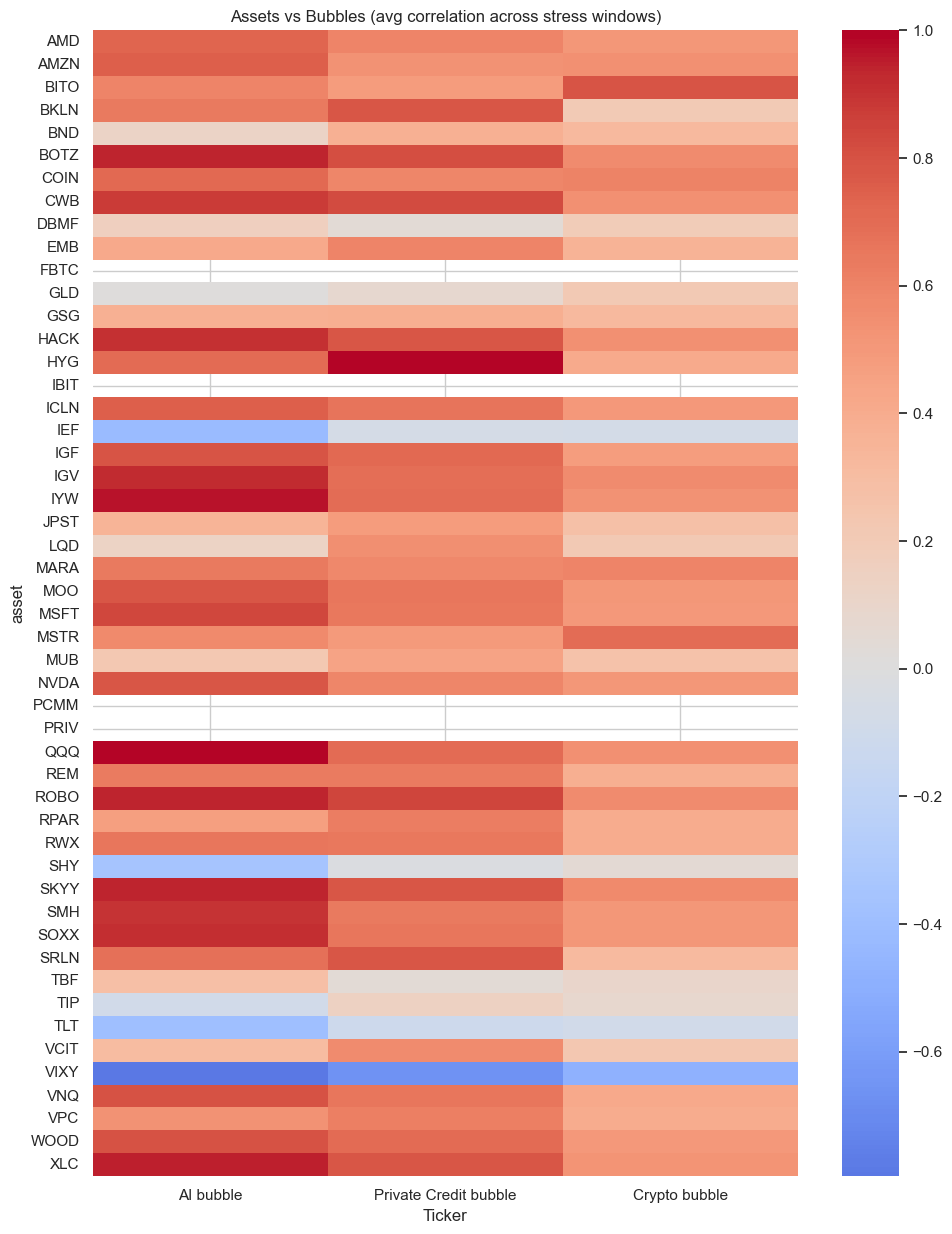

Ticker,name,AI bubble,Private Credit bubble,Crypto bubble,asset_class,risk_limit_%,position,rationale
asset,,,,,,,,
BND,Vanguard Total Bond Market ETF,0.12,0.38,0.32,Fixed income,10.00,LONG,Broad bond exposure to stabilize returns and generate income when equities retract.
TLT,iShares 20+ Year Treasury Bond,-0.40,-0.11,-0.09,Fixed income,8.00,LONG,Safety asset that should rally if risk assets collapse and liquidity flees to sovereigns.
IEF,iShares 7-10 Year Treasury Bond,-0.42,-0.07,-0.08,Fixed income,6.00,LONG,Intermediate Treasuries provide duration hedge and capital preservation in credit stress.
LQD,iShares iBoxx $ Investment Grad,0.12,0.55,0.22,Credit,6.00,LONG,High quality corporate credit should outperform lower rated debt during a private credit shock.
JPST,JPMorgan Ultra-Short Income ETF,0.35,0.49,0.27,Cash substitute,5.00,LONG,Ultra short exposure provides a safe harbor and liquidity to deploy into opportunities after dislocations.
MSFT,Microsoft Corporation,0.84,0.65,0.50,Equity cloud services,4.00,LONG,Large cloud providers have diversified earnings and balance sheets that can withstand macro stress.
NVDA,NVIDIA Corporation,0.78,0.59,0.51,Equity AI hardware,4.00,LONG,Nvidia has deep moats in AI compute and is likely to retain durable demand even after hype cycles.
VCIT,Vanguard Intermediate-Term Corp,0.31,0.56,0.23,Credit,4.00,LONG,Intermediate quality corporates balance yield and credit resilience under stress.
TIP,iShares TIPS Bond ETF,-0.09,0.15,0.09,Inflation linked,4.00,LONG,Inflation linked bonds protect purchasing power if monetary policies react to market shocks.


### What this means now: 4) Correlations: hedges vs exposures
- AI bubble: most negative corr (hedges) → VIXY (-0.80), IEF (-0.42), TLT (-0.40)
- AI bubble: most positive corr (exposures) → QQQ (+1.00), IYW (+0.97), XLC (+0.94)
- Private Credit bubble: most negative corr (hedges) → VIXY (-0.67), TLT (-0.11), IEF (-0.07)
- Private Credit bubble: most positive corr (exposures) → HYG (+1.00), ROBO (+0.84), CWB (+0.82)
- Crypto bubble: most negative corr (hedges) → VIXY (-0.49), TLT (-0.09), IEF (-0.08)
- Crypto bubble: most positive corr (exposures) → BITO (+0.79), MSTR (+0.69), COIN (+0.60)
- Rule of thumb: negative correlation vs a bubble proxy can hedge that bubble-burst; positive correlation can amplify it (correlations can shift with regimes).


Asset-to-asset correlation matrix (allocated assets):


Ticker,TLT,IEF,BND,LQD,HYG,EMB,JPST,MUB,VCIT,SHY,PRIV,VPC,PCMM,BKLN,SRLN,GLD,GSG,VNQ,RWX,ICLN,REM,TIP,IGF,MOO,WOOD,VIXY,TBF,DBMF,CWB,RPAR,QQQ,SMH,ROBO,HACK,BOTZ,IGV,XLC,IYW,SOXX,SKYY,IBIT,FBTC,BITO,MSTR,MARA,COIN,NVDA,AMD,MSFT,AMZN
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TLT,1.00,0.91,0.70,0.57,-0.13,0.16,0.10,0.34,0.58,0.59,0.13,-0.02,0.01,-0.12,-0.10,0.15,-0.23,-0.15,-0.19,-0.19,-0.08,0.69,-0.23,-0.29,-0.25,0.20,-0.86,-0.14,-0.17,0.35,-0.20,-0.20,-0.11,-0.07,-0.06,-0.22,-0.06,-0.22,-0.23,-0.13,-0.00,-0.00,0.00,-0.08,-0.03,0.01,-0.14,-0.15,-0.18,-0.10
IEF,0.91,1.00,0.73,0.59,-0.09,0.18,0.13,0.35,0.61,0.78,0.13,-0.02,0.01,-0.09,-0.07,0.19,-0.19,-0.14,-0.16,-0.15,-0.07,0.74,-0.19,-0.26,-0.21,0.19,-0.74,-0.17,-0.14,0.33,-0.20,-0.21,-0.09,-0.06,-0.04,-0.22,-0.04,-0.22,-0.24,-0.10,-0.01,-0.01,0.01,-0.08,-0.02,0.02,-0.16,-0.15,-0.18,-0.10
BND,0.70,0.73,1.00,0.68,0.19,0.42,0.34,0.52,0.73,0.57,0.17,0.15,0.03,0.07,0.12,0.21,-0.06,0.02,0.09,0.08,0.13,0.66,0.08,-0.04,0.04,0.03,-0.68,-0.13,0.07,0.51,-0.01,-0.02,0.08,0.08,0.12,0.00,0.12,-0.01,-0.03,0.06,0.00,0.00,0.04,0.01,0.03,0.06,-0.02,-0.02,-0.00,-0.01
LQD,0.57,0.59,0.68,1.00,0.42,0.43,0.27,0.49,0.70,0.42,0.13,0.17,0.04,0.23,0.20,0.14,0.05,0.17,0.26,0.20,0.25,0.53,0.26,0.17,0.20,-0.09,-0.52,-0.08,0.19,0.48,0.10,0.09,0.18,0.16,0.20,0.12,0.19,0.11,0.09,0.16,0.02,0.02,0.07,0.06,0.05,0.09,0.05,0.08,0.11,0.07
HYG,-0.13,-0.09,0.19,0.42,1.00,0.48,0.19,0.25,0.26,-0.05,0.05,0.33,0.04,0.47,0.39,0.04,0.34,0.52,0.62,0.57,0.54,0.08,0.66,0.61,0.63,-0.39,0.08,0.00,0.51,0.32,0.41,0.37,0.42,0.36,0.37,0.47,0.35,0.44,0.42,0.43,0.05,0.05,0.12,0.19,0.11,0.16,0.27,0.30,0.37,0.22
EMB,0.16,0.18,0.42,0.43,0.48,1.00,0.22,0.34,0.45,0.15,0.09,0.37,0.05,0.37,0.36,0.16,0.21,0.30,0.43,0.42,0.37,0.31,0.41,0.36,0.41,-0.32,-0.17,-0.03,0.43,0.48,0.25,0.23,0.40,0.33,0.37,0.29,0.34,0.26,0.26,0.35,0.05,0.05,0.12,0.13,0.11,0.15,0.15,0.18,0.20,0.12
JPST,0.10,0.13,0.34,0.27,0.19,0.22,1.00,0.34,0.36,0.17,0.11,0.28,0.01,0.25,0.31,0.10,0.05,0.15,0.17,0.13,0.19,0.11,0.19,0.11,0.16,-0.10,-0.13,0.01,0.22,0.33,0.09,0.08,0.18,0.15,0.18,0.10,0.21,0.10,0.10,0.13,0.01,0.01,0.03,0.05,0.04,0.03,0.05,0.05,0.09,0.03
MUB,0.34,0.35,0.52,0.49,0.25,0.34,0.34,1.00,0.50,0.25,0.13,0.26,0.06,0.26,0.28,0.09,0.00,0.14,0.18,0.14,0.24,0.36,0.21,0.08,0.15,-0.04,-0.35,-0.05,0.18,0.38,0.07,0.07,0.13,0.11,0.16,0.09,0.15,0.08,0.08,0.10,0.01,0.01,0.03,0.04,0.04,0.04,0.04,0.04,0.08,0.04
VCIT,0.58,0.61,0.73,0.70,0.26,0.45,0.36,0.50,1.00,0.46,0.18,0.21,0.05,0.26,0.21,0.22,0.01,0.17,0.20,0.13,0.26,0.54,0.17,0.09,0.13,-0.09,-0.66,-0.14,0.20,0.59,0.09,0.08,0.20,0.18,0.23,0.11,0.23,0.09,0.09,0.18,0.02,0.02,0.08,0.06,0.06,0.12,0.05,0.05,0.07,0.05


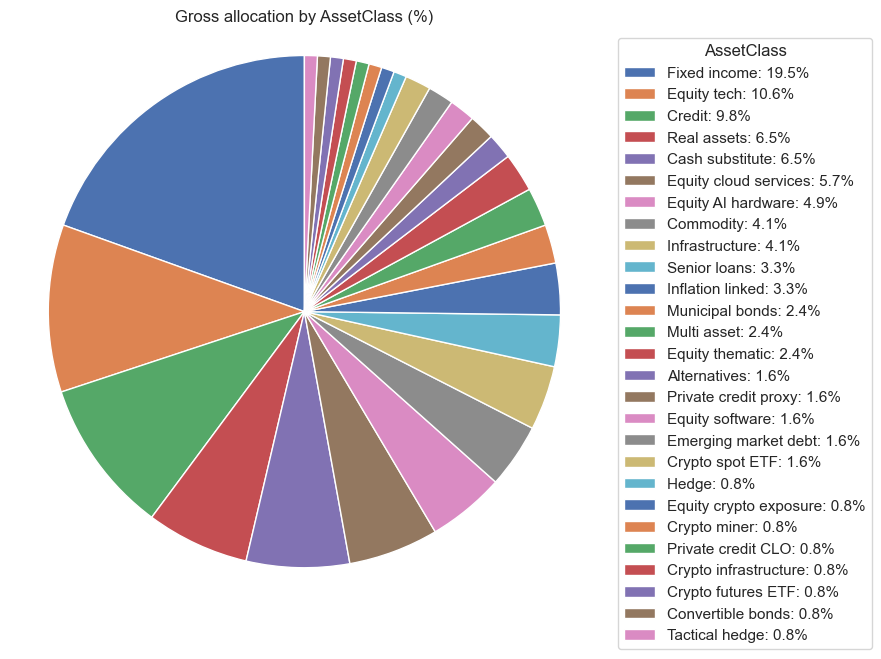

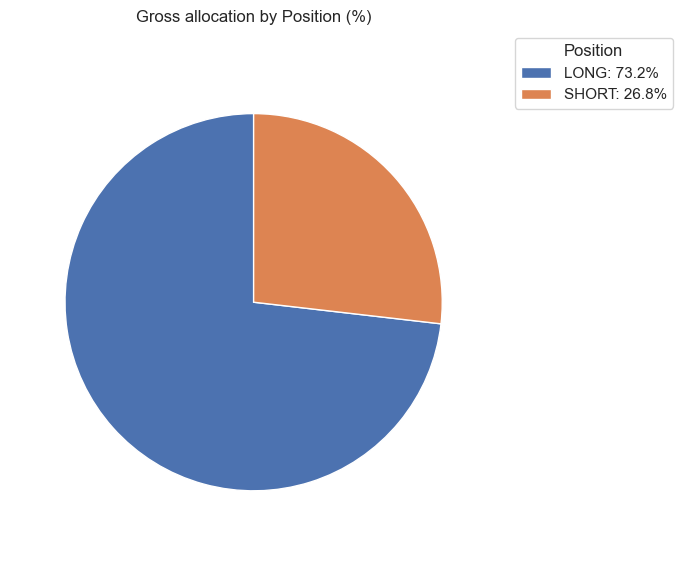

In [6]:
from IPython.display import display

candidate_tickers = [t for t in ficc_tickers if t in prices.columns]
bubble_factor_tickers = [t for t in bubble_tickers if t in prices.columns]

# Rename bubble ticker columns to human-readable bubble names
bubble_name_by_ticker = {v: k for k, v in BUBBLE_TICKERS.items()}
bubble_returns = rets[bubble_factor_tickers].rename(columns=bubble_name_by_ticker)

print('Candidate universe tickers available:', len(candidate_tickers))
print('Bubbles used:', list(bubble_returns.columns))

def corr_assets_vs_bubbles(asset_returns: pd.DataFrame, bubble_returns: pd.DataFrame) -> pd.DataFrame:
    bubbles = bubble_returns.rename(columns=lambda c: f'__bubble__{c}')
    common = asset_returns.join(bubbles, how='inner')
    out = pd.DataFrame(index=asset_returns.columns, columns=bubble_returns.columns, dtype=float)
    for b in bubble_returns.columns:
        out[b] = common[asset_returns.columns].corrwith(common[f'__bubble__{b}'])
    return out

corr_by_window: dict[str, pd.DataFrame] = {}

for name, (start, end) in EVENT_WINDOWS.items():
    a = rets.loc[start:end, candidate_tickers].dropna(how='all')
    b = bubble_returns.loc[start:end].dropna(how='all')
    if a.empty or b.empty:
        print(f'[skip] {name}: insufficient overlap for correlation')
        continue
    corr_by_window[name] = corr_assets_vs_bubbles(a, b)

if not corr_by_window:
    raise RuntimeError('No correlation windows produced any data. Check tickers and date ranges.')

# Average correlation across selected windows
corr_avg = pd.concat(corr_by_window, names=['window', 'asset']).groupby('asset').mean()

plt.figure(figsize=(10, max(6, 0.25 * len(corr_avg))))
sns.heatmap(corr_avg, annot=False, cmap='coolwarm', center=0)
plt.title('Assets vs Bubbles (avg correlation across stress windows)')
plt.tight_layout()
plt.show()

# Display correlation matrix along with the roster Position (source of truth)
corr_with_side = corr_avg.copy()
corr_with_side.insert(0, 'name', [yahoo_name(s) for s in corr_with_side.index])
corr_with_side['asset_class'] = [assetclass_by_ticker.get(s, '') for s in corr_with_side.index]
corr_with_side['risk_limit_%'] = [risklimit_by_ticker.get(s, np.nan) for s in corr_with_side.index]
corr_with_side['position'] = [position_by_ticker.get(s, '') for s in corr_with_side.index]

# Add roster Rationale column (user requested)
corr_with_side['rationale'] = [rationale_by_ticker.get(s, '') for s in corr_with_side.index]

display(
    corr_with_side.sort_values(['position', 'risk_limit_%', 'name'], ascending=[True, False, True]).style.format(
        {
            'risk_limit_%': '{:.2f}',
            'AI bubble': '{:.2f}',
            'Private Credit bubble': '{:.2f}',
            'Crypto bubble': '{:.2f}',
        }
    )
)

# Dynamic interpretation (updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        bullets = []
        for bubble in ['AI bubble', 'Private Credit bubble', 'Crypto bubble']:
            if bubble not in corr_with_side.columns:
                continue
            s = pd.to_numeric(corr_with_side[bubble], errors='coerce').dropna()
            if s.empty:
                continue

            hedges = s.sort_values().head(3)
            expos = s.sort_values(ascending=False).head(3)

            hedges_txt = ', '.join([f'{k} ({v:+.2f})' for k, v in hedges.items()])
            expos_txt = ', '.join([f'{k} ({v:+.2f})' for k, v in expos.items()])

            bullets.append(f'{bubble}: most negative corr (hedges) → {hedges_txt}')
            bullets.append(f'{bubble}: most positive corr (exposures) → {expos_txt}')

        if bullets:
            bullets.append('Rule of thumb: negative correlation vs a bubble proxy can hedge that bubble-burst; positive correlation can amplify it (correlations can shift with regimes).')
            explain('4) Correlations: hedges vs exposures', bullets)
    except Exception:
        pass

# ------------------------------------------------------------
# Cross-asset correlation matrix (allocated assets vs assets)
# ------------------------------------------------------------
alloc_tickers = [t for t in universe_tickers if t in prices.columns]
alloc_rets = rets[alloc_tickers].fillna(0.0)

asset_corr = alloc_rets.corr()

print()
print('Asset-to-asset correlation matrix (allocated assets):')
display(asset_corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format('{:.2f}'))

# ------------------------------------------------------------
# Allocation pie charts (by AssetClass and by Position)
# ------------------------------------------------------------
# Build roster-driven gross weights (same sizing logic as Section 5)
roster_sub = roster.set_index('Ticker').reindex(alloc_tickers)

abs_budget = roster_sub['RiskLimitPercent'].astype(float).fillna(0.0).clip(lower=0.0)
if float(abs_budget.sum()) <= 0:
    raise RuntimeError('Roster RiskLimitPercent sums to 0; cannot build allocation pies.')

abs_w = abs_budget / float(abs_budget.sum())
pos = roster_sub['Position'].astype(str).str.upper().fillna('LONG')
sign = pos.map({'LONG': 1.0, 'SHORT': -1.0}).fillna(1.0)

w = abs_w * sign
w = w * (GROSS_EXPOSURE / w.abs().sum())
w_abs = w.abs()

# Pie 1: AssetClass
ac = roster_sub['AssetClass'].astype(str).fillna('Unknown')
by_class = w_abs.groupby(ac).sum().sort_values(ascending=False)

def pie_with_legend_percent(series: pd.Series, title: str, legend_title: str, figsize: tuple[int, int]) -> None:
    vals = series.values
    labels = series.index.astype(str)
    pct = (vals / vals.sum()) * 100.0
    legend_labels = [f"{lab}: {p:.1f}%" for lab, p in zip(labels, pct)]

    plt.figure(figsize=figsize)
    wedges, _ = plt.pie(vals, labels=None, startangle=90)
    plt.title(title)
    plt.legend(wedges, legend_labels, title=legend_title, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

pie_with_legend_percent(
    by_class,
    title='Gross allocation by AssetClass (%)',
    legend_title='AssetClass',
    figsize=(9, 7),
)

# Pie 2: Position (Long vs Short)
by_pos = w_abs.groupby(pos).sum().sort_values(ascending=False)

pie_with_legend_percent(
    by_pos,
    title='Gross allocation by Position (%)',
    legend_title='Position',
    figsize=(7, 6),
)


## 5) Portfolio construction (roster-driven long/short allocation)

We build one portfolio allocation from the roster CSV:
- **Position (Long/Short)** comes from the `Position` column.
- **Sizing** is based on `RiskLimitPercent` (normalized to 100% gross exposure).

**Stress-window upgrade (optional):** This notebook can also *override* the roster sizing with a stress-window optimized weight vector that tries to maximize the **worst-case cumulative return** across the three historical stress windows used later in Section 7 (Dot-com, GFC, COVID). It keeps LONG/SHORT directions fixed to the roster, and only changes *how much* you allocate to each asset.

This produces the single required allocation list: **Symbol, Symbol name, Weight (%), Long/Short, and reasoning**.

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- This is where we turn the roster CSV into an actual **portfolio weight vector**.
- `RiskLimitPercent` controls sizing; `Position` controls whether that weight is LONG or SHORT.
- The output allocation table is the “portfolio recipe” used everywhere else (backtests, simulations, stress tests).


In [7]:
def portfolio_returns(asset_returns: pd.DataFrame, weights: pd.Series) -> pd.Series:
    # Fill missing daily returns as 0 (no price change); avoids dropping entire rows
    aligned = asset_returns.reindex(columns=weights.index).fillna(0.0)
    return aligned.dot(weights)

def cum_return(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return float((1 + r).prod() - 1)

def max_drawdown(equity_curve: pd.Series) -> float:
    peak = equity_curve.cummax()
    dd = equity_curve / peak - 1.0
    return float(dd.min())
# Investable tickers with price data
asset_tickers = [t for t in universe_tickers if t in prices.columns]
print('Investable tickers (with price data):', len(asset_tickers))

roster_sub = roster.set_index('Ticker').reindex(asset_tickers)

# Build weights from roster RiskLimitPercent (normalized) and Position (Long/Short)
abs_budget = roster_sub['RiskLimitPercent'].astype(float).fillna(0.0).clip(lower=0.0)
if float(abs_budget.sum()) <= 0:
    raise RuntimeError('Roster RiskLimitPercent sums to 0; cannot build a portfolio.')

abs_w = abs_budget / float(abs_budget.sum())
pos = roster_sub['Position'].astype(str).str.upper().fillna('LONG')
sign = pos.map({'LONG': 1.0, 'SHORT': -1.0}).fillna(1.0)
signs = sign.values

base_w = (abs_w * sign).rename('weight')
base_w = base_w * (GROSS_EXPOSURE / base_w.abs().sum())

# ------------------------------------------------------------
# Stress-window optimized sizing (keeps roster LONG/SHORT signs)
# ------------------------------------------------------------
USE_STRESS_OPTIMIZED_WEIGHTS = True
STRESS_OPT_WINDOWS = [
    'Dot-com crash (AI bubble stress)',
    'GFC (Private Credit bubble stress)',
    'COVID crash',
]
INCLUDE_SECTION10_SCENARIOS = True   # bubble-burst forward-looking scenarios (Section 10)
INCLUDE_GPFG_SCENARIOS = True        # GPFG-style shocks (Section 10B)

N_OPT_CANDIDATES = 8000
DIRICHLET_ALPHA = 2.0  # >1 makes weights less extreme; lower values concentrate
SHOCK_MONTHS = 12


def _cum_return_from_daily_fast(daily: np.ndarray) -> float:
    daily = np.asarray(daily, dtype=float)
    if daily.size == 0:
        return np.nan
    # avoid log(<=0)
    daily = np.clip(daily, -0.999999, None)
    return float(np.expm1(np.log1p(daily).sum()))


def _cum_return_from_monthly_fast(monthly: np.ndarray) -> float:
    monthly = np.asarray(monthly, dtype=float)
    if monthly.size == 0:
        return np.nan
    monthly = np.clip(monthly, -0.999999, None)
    return float(np.expm1(np.log1p(monthly).sum()))


def _stress_cum_returns(weights: pd.Series) -> dict[str, float]:
    out: dict[str, float] = {}
    for nm in STRESS_OPT_WINDOWS:
        if nm not in EVENT_WINDOWS:
            out[nm] = np.nan
            continue
        start, end = EVENT_WINDOWS[nm]
        window = rets.loc[start:end, asset_tickers]
        cols = [c for c in window.columns if window[c].notna().any()]
        if not cols:
            out[nm] = np.nan
            continue
        w = weights.reindex(cols).fillna(0.0)
        if float(w.abs().sum()) <= 0:
            out[nm] = np.nan
            continue
        w = w * (GROSS_EXPOSURE / float(w.abs().sum()))
        pr = window[cols].fillna(0.0).dot(w).to_numpy()
        out[nm] = _cum_return_from_daily_fast(pr)
    return out


best_w = base_w.copy()
if USE_STRESS_OPTIMIZED_WEIGHTS and len(asset_tickers) >= 3:
    n = len(asset_tickers)
    rng_opt = np.random.default_rng(RANDOM_SEED + 77)

    # Candidate absolute weights (each column sums to 1)
    A = rng_opt.dirichlet(np.ones(n) * float(DIRICHLET_ALPHA), size=int(N_OPT_CANDIDATES)).T

    # Enforce per-asset cap in the *global* portfolio (not window-renormalized)
    cap = float(MAX_ABS_WEIGHT)
    mask = (A.max(axis=0) <= cap)
    if mask.sum() >= max(1000, int(0.25 * N_OPT_CANDIDATES)):
        A = A[:, mask]

    if A.shape[1] >= 500:
        win_cum = []
        win_names: list[str] = []
        for nm in STRESS_OPT_WINDOWS:
            if nm not in EVENT_WINDOWS:
                continue
            start, end = EVENT_WINDOWS[nm]
            window = rets.loc[start:end, asset_tickers]
            cols = [c for c in window.columns if window[c].notna().any()]
            if not cols:
                continue

            idx = [asset_tickers.index(c) for c in cols]
            A_sub = A[idx, :]
            denom = A_sub.sum(axis=0)
            denom = np.where(denom <= 0, np.nan, denom)

            sign_sub = sign.reindex(cols).fillna(1.0).to_numpy(dtype=float)
            W_sub = (sign_sub[:, None] * A_sub) / denom[None, :] * float(GROSS_EXPOSURE)

            R = window[cols].fillna(0.0).to_numpy(dtype=float)
            pr = R @ W_sub
            pr = np.clip(pr, -0.999999, None)
            cum = np.expm1(np.log1p(pr).sum(axis=0))
            win_cum.append(cum)
            win_names.append(nm)

        # -----------------------------
        # Forward-looking factor scenarios (Section 10 + 10B)
        # -----------------------------
        scenario_paths: dict[str, pd.DataFrame] = {}
        bubble_factor_tickers = [t for t in BUBBLE_TICKERS.values() if t in rets.columns]
        if (INCLUDE_SECTION10_SCENARIOS or INCLUDE_GPFG_SCENARIOS) and len(bubble_factor_tickers) >= 2:
            bubble_m = (1 + rets[bubble_factor_tickers].fillna(0)).resample(MONTHLY_FREQ).prod() - 1
            asset_m = (1 + rets[asset_tickers].fillna(0)).resample(MONTHLY_FREQ).prod() - 1

            betas: dict[str, pd.Series] = {}
            asset_mean_m = asset_m.mean()
            for a in asset_tickers:
                df = pd.concat([asset_m[a].rename('__asset__'), bubble_m], axis=1, join='inner').dropna()
                if df.shape[0] < 36:
                    continue
                y = df['__asset__']
                X = sm.add_constant(df[bubble_factor_tickers])
                try:
                    fit = sm.OLS(y, X).fit()
                except Exception:
                    continue
                betas[a] = fit.params

            def predict_portfolio_monthly_from_factors(factors: pd.DataFrame, weights: pd.Series) -> pd.Series:
                pred_assets = pd.DataFrame(index=factors.index, columns=asset_tickers, data=0.0)
                for a in asset_tickers:
                    if a in betas:
                        params = betas[a]
                        pred_assets[a] = float(params.get('const', 0.0))
                        for fac in factors.columns:
                            pred_assets[a] += float(params.get(fac, 0.0)) * factors[fac]
                    else:
                        pred_assets[a] = float(asset_mean_m.get(a, 0.0))
                return pred_assets.fillna(0.0).dot(weights.reindex(asset_tickers).fillna(0.0))

            def monthly_path(series: pd.Series, start: str, end: str) -> pd.Series:
                s = series.loc[start:end].copy()
                if len(s) == 0:
                    raise ValueError('Empty scenario path')
                return s

            ai_bubble = BUBBLE_TICKERS['AI bubble']
            private_credit_bubble = BUBBLE_TICKERS['Private Credit bubble']
            crypto_bubble = BUBBLE_TICKERS['Crypto bubble']
            needed = [ai_bubble, private_credit_bubble, crypto_bubble]
            needed = [t for t in needed if t in bubble_m.columns]

            if needed:
                # Baseline factor fit
                train_start = pd.Timestamp.today().normalize() - pd.DateOffset(years=10)
                train_bubbles = bubble_m[needed].loc[train_start:].dropna()
                if train_bubbles.empty:
                    train_bubbles = bubble_m[needed].dropna()

                mu_f = train_bubbles.mean()
                cov_f = train_bubbles.cov()
                rng_future = np.random.default_rng(RANDOM_SEED + 2027)
                future_idx = pd.date_range(pd.Timestamp('2026-01-31'), periods=SHOCK_MONTHS, freq=MONTHLY_FREQ)
                base_samples = rng_future.multivariate_normal(mu_f.values, cov_f.values, size=len(future_idx))
                base_factors = pd.DataFrame(base_samples, index=future_idx, columns=needed)

                def apply_shock(df: pd.DataFrame, col: str, shock: pd.Series) -> pd.DataFrame:
                    df = df.copy()
                    idx = pd.date_range(df.index[0], periods=len(shock), freq=MONTHLY_FREQ)
                    idx = idx.intersection(df.index)
                    if len(idx) == 0:
                        return df
                    df.loc[idx, col] = shock.values[: len(idx)]
                    return df

                ai_shock_full = monthly_path(bubble_m[ai_bubble], *EVENT_WINDOWS['Dot-com crash (AI bubble stress)'])
                credit_shock_full = monthly_path(bubble_m[private_credit_bubble], *EVENT_WINDOWS['GFC (Private Credit bubble stress)'])
                crypto_shock_full = monthly_path(bubble_m[crypto_bubble], *EVENT_WINDOWS['Crypto winter (Crypto bubble stress)'])
                ai_shock = ai_shock_full.iloc[: min(SHOCK_MONTHS, len(ai_shock_full))]
                credit_shock = credit_shock_full.iloc[: min(SHOCK_MONTHS, len(credit_shock_full))]
                crypto_shock = crypto_shock_full.iloc[: min(SHOCK_MONTHS, len(crypto_shock_full))]

                if INCLUDE_SECTION10_SCENARIOS:
                    scenario_paths['Baseline (simulated 2026–2030)'] = base_factors
                    scenario_paths['AI bubble burst (2026–2030)'] = apply_shock(base_factors, ai_bubble, ai_shock)
                    scenario_paths['Private Credit bubble burst (2026–2030)'] = apply_shock(base_factors, private_credit_bubble, credit_shock)
                    scenario_paths['Crypto bubble burst (2026–2030)'] = apply_shock(base_factors, crypto_bubble, crypto_shock)
                    triple = base_factors.copy()
                    triple = apply_shock(triple, ai_bubble, ai_shock)
                    triple = apply_shock(triple, private_credit_bubble, credit_shock)
                    triple = apply_shock(triple, crypto_bubble, crypto_shock)
                    scenario_paths['Triple-bubble burst (2026–2030)'] = triple

                if INCLUDE_GPFG_SCENARIOS:
                    SCENARIO_SHOCKS = {
                        'AI correction (12m)': {ai_bubble: -0.53, private_credit_bubble: 0.05, crypto_bubble: -0.25},
                        'Fragmented world (12m)': {ai_bubble: -0.49, private_credit_bubble: -0.15, crypto_bubble: -0.30},
                        'Regional debt crisis (12m)': {ai_bubble: -0.39, private_credit_bubble: -0.25, crypto_bubble: -0.10},
                        'Extreme weather (12m)': {ai_bubble: -0.24, private_credit_bubble: -0.10, crypto_bubble: -0.05},
                        'Combined severe (12m)': {ai_bubble: -0.55, private_credit_bubble: -0.25, crypto_bubble: -0.30},
                    }
                    for nm, shocks in SCENARIO_SHOCKS.items():
                        df = base_factors.copy()
                        for fac, val in shocks.items():
                            if fac not in df.columns:
                                continue
                            # Interpret `val` as a 12-month total return and convert to a constant monthly path.
                            monthly_val = (1.0 + float(val)) ** (1.0 / float(SHOCK_MONTHS)) - 1.0
                            seq = pd.Series([monthly_val] * SHOCK_MONTHS, index=df.index[:SHOCK_MONTHS])
                            df = apply_shock(df, fac, seq)
                        scenario_paths[f'{nm} (GPFG)'] = df

        if win_cum:
            C = np.vstack(win_cum)  # shape: (n_windows, n_candidates)
            hist_min = np.nanmin(C, axis=0)
            hist_sum = np.nansum(C, axis=0)

            combined_min = hist_min.copy()
            combined_sum = hist_sum.copy()

            # Requirement: the final allocation must have non-negative cumulative return in *all*
            # historical stress windows. Treat this as a hard feasibility constraint.
            hist_ok = np.all(np.isfinite(C) & (C >= 0.0), axis=0)
            if hist_ok.any():
                combined_min = np.where(hist_ok, combined_min, -np.inf)
                combined_sum = np.where(hist_ok, combined_sum, -np.inf)
                print(
                    f"[allocation] Candidates passing all historical stress windows: {int(hist_ok.sum())} / {int(C.shape[1])}"
                )
            else:
                print(
                    '[allocation] WARNING: No candidates pass all historical stress windows under current constraints; falling back to unconstrained optimization.'
                )

            # Optional: include Section 10 + GPFG scenarios in the objective.
            # IMPORTANT: this must be fast; we evaluate all candidates at once.
            S_scen = None
            scen_names: list[str] = []
            base_scen = None
            if scenario_paths:
                # Factor order used in the scenario paths (built from `needed`).
                factor_cols = list(next(iter(scenario_paths.values())).columns)

                # Build per-asset regression params (const + betas) for fast portfolio-level evaluation.
                const_vec = np.zeros(len(asset_tickers), dtype=float)
                beta_mat = np.zeros((len(asset_tickers), len(factor_cols)), dtype=float)
                for i, a in enumerate(asset_tickers):
                    if a in betas:
                        params = betas[a]
                        const_vec[i] = float(params.get('const', 0.0))
                        for k, fac in enumerate(factor_cols):
                            beta_mat[i, k] = float(params.get(fac, 0.0))
                    else:
                        const_vec[i] = float(asset_mean_m.get(a, 0.0))

                # Candidate signed weights matrix W: (n_assets, n_candidates)
                sign_vec = sign.reindex(asset_tickers).fillna(1.0).to_numpy(dtype=float)
                W = sign_vec[:, None] * A * float(GROSS_EXPOSURE)

                # Portfolio-level exposures per candidate
                c = const_vec @ W  # shape: (n_candidates,)
                b = beta_mat.T @ W  # shape: (n_factors, n_candidates)

                # Baseline (non-optimized) portfolio exposures for comparison
                w_base_vec = base_w.reindex(asset_tickers).fillna(0.0).to_numpy(dtype=float)
                c_base = float(const_vec @ w_base_vec)
                b_base = beta_mat.T @ w_base_vec  # shape: (n_factors,)

                scen_cum_all = []
                base_cum_all = []
                for nm, fx in scenario_paths.items():
                    F = fx[factor_cols].fillna(0.0).to_numpy(dtype=float)  # (T, K)

                    # Candidate portfolio monthly returns (deterministic expectation)
                    Rm = F @ b + c[None, :]
                    Rm = np.clip(Rm, -0.999999, None)
                    cum = np.expm1(np.log1p(Rm).sum(axis=0))
                    scen_cum_all.append(cum)
                    scen_names.append(str(nm))

                    # Base portfolio scenario cumulative return
                    r_base = (F @ b_base) + c_base
                    base_cum_all.append(_cum_return_from_monthly_fast(r_base))

                if scen_cum_all:
                    S_scen = np.vstack(scen_cum_all)  # (n_scenarios, n_candidates)
                    base_scen = np.array(base_cum_all, dtype=float)
                    scen_min = np.nanmin(S_scen, axis=0)
                    scen_sum = np.nansum(S_scen, axis=0)
                    combined_min = np.minimum(combined_min, scen_min)
                    combined_sum = combined_sum + scen_sum

            # Maximize worst-case across historical + scenario sets; tie-breaker: sum
            best_j = int(np.nanargmax(combined_min + 1e-6 * combined_sum))
            opt_abs = A[:, best_j]
            best_w = (pd.Series(opt_abs, index=asset_tickers) * sign).rename('weight')
            best_w = best_w * (GROSS_EXPOSURE / float(best_w.abs().sum()))

            base_tbl = _stress_cum_returns(base_w)
            opt_tbl = _stress_cum_returns(best_w)
            comp = pd.DataFrame({'base': base_tbl, 'optimized': opt_tbl})
            comp = comp.T
            print('\n[allocation] Stress-window cumulative returns (base vs optimized):')
            display(comp.style.format('{:.2%}'))

            if (S_scen is not None) and (base_scen is not None) and (len(scen_names) == int(S_scen.shape[0])):
                scen_tbl = pd.DataFrame(
                    {
                        'base': base_scen,
                        'optimized': [float(S_scen[i, best_j]) for i in range(len(scen_names))],
                    },
                    index=pd.Index(scen_names, name='scenario'),
                ).sort_values('optimized')
                print('\n[allocation] Scenario cumulative returns (base vs optimized):')
                display(scen_tbl.style.format('{:.2%}'))
    else:
        print('[allocation] Skipping stress optimization (not enough feasible candidates under MAX_ABS_WEIGHT cap).')

allocation = pd.DataFrame(
    {
        'Symbol': asset_tickers,
        'Symbol name': roster_sub['Name'].values,
        'Weight (%)': (best_w.abs().values * 100.0),
        'Long/Short': pos.values,
        'Reasoning': roster_sub['Rationale'].values,
    }
).set_index('Symbol')

allocation = allocation.sort_values('Weight (%)', ascending=False)
allocation.style.format({'Weight (%)': '{:.2f}'})

# Basic stress-window performance of this roster-driven allocation
port = portfolio_returns(rets[asset_tickers], best_w)

# Note: historical stress-window backtest metrics are summarized in Section 7 (after the graphs)
# using window-renormalized weights, so the numbers and plots are consistent.

# RNG for later sections (frontier sampling / Monte Carlo)
rng = np.random.default_rng(RANDOM_SEED)

# Dynamic interpretation (updates when weights/data change)
if 'explain' in globals():
    try:
        bullets = []
        bullets.append(f'Investable assets used (with price data): {len(asset_tickers)}')

        try:
            gross = float(best_w.abs().sum())
            bullets.append(f'Gross exposure (sum abs weights): {gross:.2f} (target={GROSS_EXPOSURE:.2f})')
        except Exception:
            pass

        try:
            n_long = int((best_w > 0).sum())
            n_short = int((best_w < 0).sum())
            bullets.append(f'Long/Short counts: {n_long} LONG, {n_short} SHORT')
        except Exception:
            pass

        try:
            idx = best_w.reindex(asset_tickers).fillna(0.0).abs().sort_values(ascending=False).head(5).index
            top_w = best_w.reindex(idx)
            top_txt = '; '.join([f'{k} {v * 100:+.2f}%' for k, v in top_w.items()])
            if top_txt:
                bullets.append('Largest weights (signed): ' + top_txt)
        except Exception:
            pass

        bullets.append('If Yahoo prices update or you edit the roster CSV (Position/RiskLimitPercent), this allocation and all downstream sections will change on the next run.')
        explain('5) Portfolio allocation (live snapshot)', bullets)
    except Exception:
        pass


Investable tickers (with price data): 50
[allocation] Candidates passing all historical stress windows: 1155 / 8000

[allocation] Stress-window cumulative returns (base vs optimized):


,Dot-com crash (AI bubble stress),GFC (Private Credit bubble stress),COVID crash
base,28.16%,-7.30%,-0.81%
optimized,28.97%,0.36%,8.30%



[allocation] Scenario cumulative returns (base vs optimized):


,base,optimized
scenario,,
AI bubble burst (2026–2030),-0.92%,-2.79%
Baseline (simulated 2026–2030),2.55%,-0.85%
Private Credit bubble burst (2026–2030),-0.43%,0.45%
AI correction (12m) (GPFG),0.99%,0.58%
Extreme weather (12m) (GPFG),0.29%,1.88%
Fragmented world (12m) (GPFG),-1.22%,1.98%
Combined severe (12m) (GPFG),-3.05%,2.44%
Regional debt crisis (12m) (GPFG),-2.47%,2.56%
Triple-bubble burst (2026–2030),-0.54%,2.79%


### What this means now: 5) Portfolio allocation (live snapshot)
- Investable assets used (with price data): 50
- Gross exposure (sum abs weights): 1.00 (target=1.00)
- Long/Short counts: 28 LONG, 22 SHORT
- Largest weights (signed): SRLN -12.05%; EMB -5.23%; HYG -4.50%; IYW -4.14%; HACK +4.12%
- If Yahoo prices update or you edit the roster CSV (Position/RiskLimitPercent), this allocation and all downstream sections will change on the next run.

## 6) Portfolio construction graph (Expected Return vs Expected Risk)

We sample many random long/short portfolios (same sign rule) and plot:
- X-axis: expected return
- Y-axis: expected risk (volatility)

We also overlay an **approximate efficient frontier curve** (best return achieved for each risk level among the sampled portfolios) so the chart reads like a classic efficient frontier under your long/short constraints.

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- Blue dots = **different possible portfolios** under the same rules (Long/Short signs, weight caps).
- Orange line = an **approximate efficient frontier** (best return you can get for a given risk level, within what we sampled).
- Red star = your **roster-driven portfolio** from Section 5.
- Important: this is **baseline mean/variance**. Bubble-burst resilience is judged more directly in Sections 7/8/10.


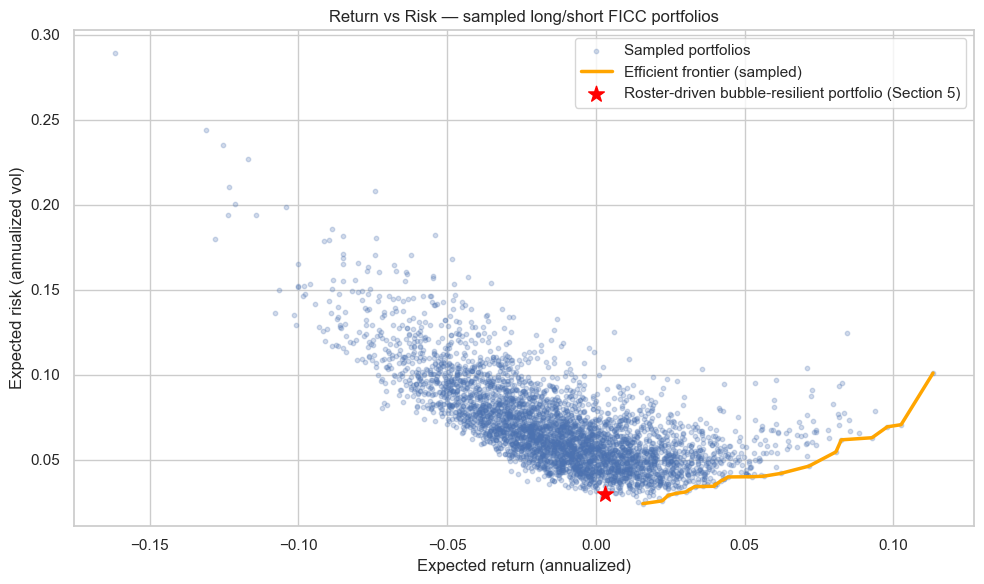

Roster-driven expected return (annualized): 0.31%
Roster-driven expected risk (annualized vol): 2.97%


### What this means now: 6) Return vs risk chart (how to read now)
- Sampled portfolios kept after caps: 3997 of 4000
- Roster expected return: 0.31% (annualized)
- Roster expected risk: 2.97% (annualized vol)
- Frontier envelope points (sampled): 25

In [8]:
# Use recent window for expected return/risk estimates
train_start = (pd.Timestamp.today().normalize() - pd.DateOffset(years=10)).strftime('%Y-%m-%d')
train = rets.loc[train_start:, asset_tickers].dropna(how='all').fillna(0.0)

mu = train.mean() * 252
cov = train.cov() * 252

def port_mu_sigma(weights: np.ndarray) -> tuple[float, float]:
    m = float(np.dot(weights, mu.values))
    v = float(np.dot(weights, np.dot(cov.values, weights)))
    return m, float(np.sqrt(max(v, 0.0)))

N_SAMPLES = 4000
pts = []
for _ in range(N_SAMPLES):
    raw = rng.dirichlet(np.ones(len(asset_tickers)))
    w = raw * signs
    w = w * (GROSS_EXPOSURE / np.sum(np.abs(w)))
    if np.max(np.abs(w)) > MAX_ABS_WEIGHT:
        continue
    m, s = port_mu_sigma(w)
    pts.append((m, s))

pts = np.array(pts)
roster_m, roster_s = port_mu_sigma(best_w.values)

# Approximate efficient frontier from sampled portfolios (upper envelope)
# Sort by risk (sigma), then keep portfolios that improve the best return so far.
order = np.argsort(pts[:, 1])
sorted_pts = pts[order]
front = []
best_m = -np.inf
for m, s in sorted_pts:
    if m > best_m:
        front.append((m, s))
        best_m = m
front = np.array(front)

plt.figure(figsize=(10, 6))
plt.scatter(pts[:, 0], pts[:, 1], s=10, alpha=0.25, label='Sampled portfolios')
if len(front) > 1:
    plt.plot(front[:, 0], front[:, 1], color='orange', linewidth=2.5, label='Efficient frontier (sampled)')
plt.scatter([roster_m], [roster_s], s=140, marker='*', color='red', label='Roster-driven bubble-resilient portfolio (Section 5)')
plt.xlabel('Expected return (annualized)')
plt.ylabel('Expected risk (annualized vol)')
plt.title('Return vs Risk — sampled long/short FICC portfolios')
plt.legend()
plt.tight_layout()
plt.show()

print('Roster-driven expected return (annualized):', f'{roster_m:.2%}')
print('Roster-driven expected risk (annualized vol):', f'{roster_s:.2%}')

# Dynamic interpretation (updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        bullets = []
        bullets.append(f'Sampled portfolios kept after caps: {int(len(pts))} of {int(N_SAMPLES)}')
        bullets.append(f'Roster expected return: {roster_m:.2%} (annualized)')
        bullets.append(f'Roster expected risk: {roster_s:.2%} (annualized vol)')
        if len(front) > 1:
            bullets.append(f'Frontier envelope points (sampled): {int(len(front))}')
        explain('6) Return vs risk chart (how to read now)', bullets)
    except Exception:
        pass


## 7) Historical backtests (Dot-com / GFC / COVID)

We plot cumulative returns for each stress window and compute basic drawdown stats.

Note: some roster tickers may not have price history going back to 2000–2002. For each window we (1) report how many assets have data and (2) renormalize weights to the assets that existed in that window.

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- This section replays history to answer: **“How would this portfolio have behaved in major crashes?”**
- The equity curves show the path; the summary table shows the exact cumulative return + max drawdown for those same curves.
- These windows are used as analogs for the 3-bubble risk (AI/Dot-com, Credit/GFC, Crypto/COVID-like stress).


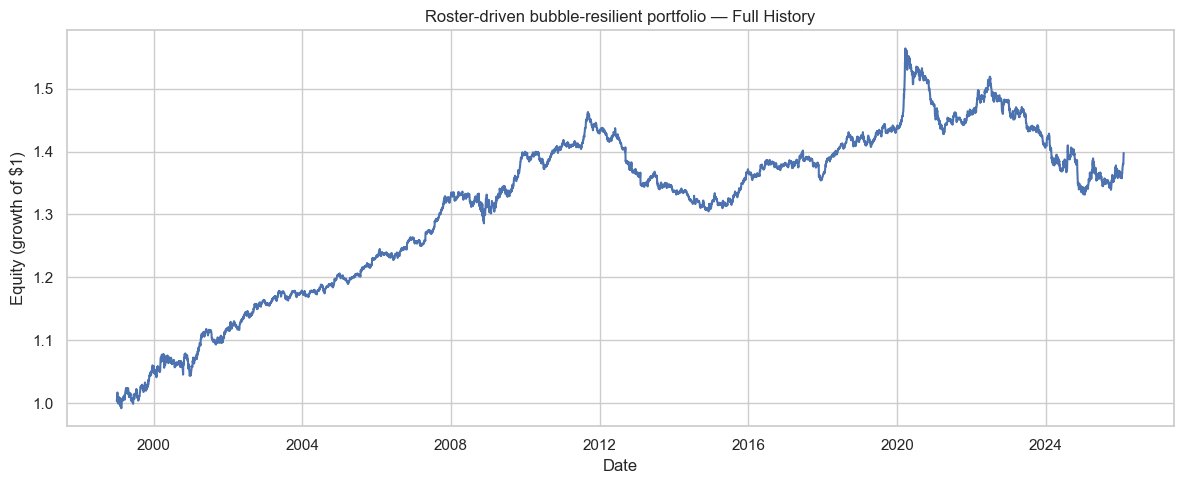

Dot-com crash (AI bubble stress): using 14 of 50 assets (weights renormalized within window)


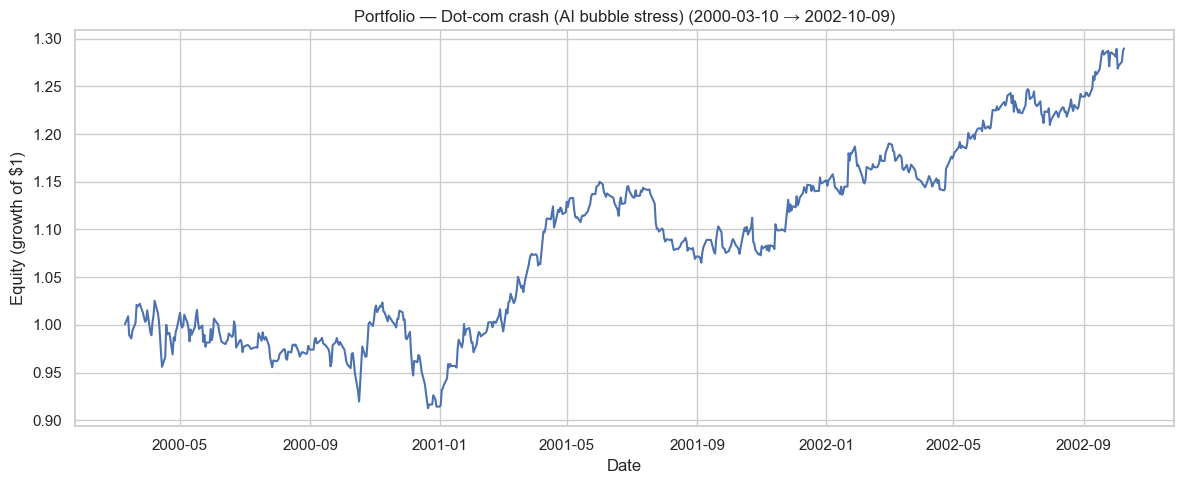

GFC (Private Credit bubble stress): using 28 of 50 assets (weights renormalized within window)


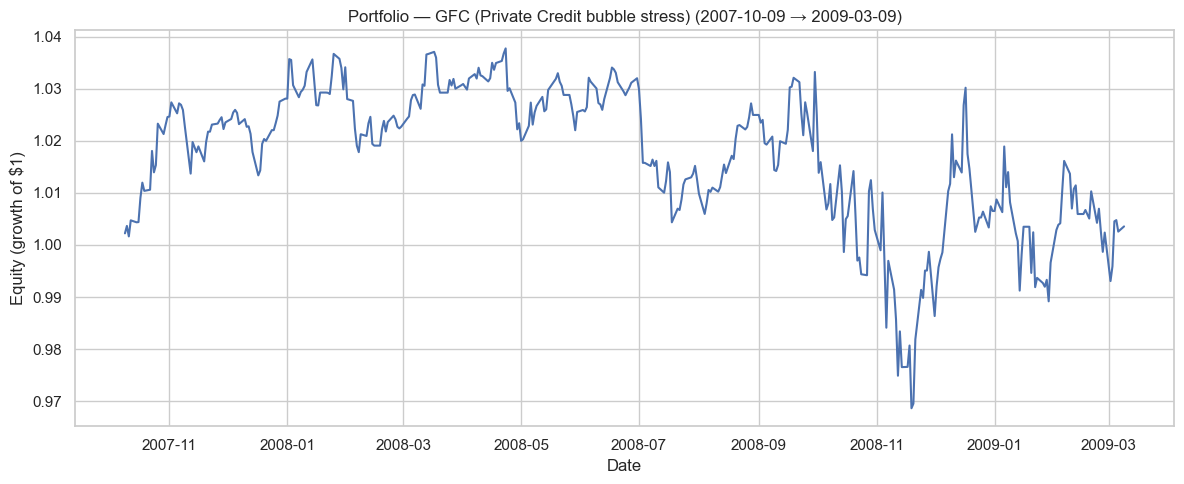

COVID crash: using 44 of 50 assets (weights renormalized within window)


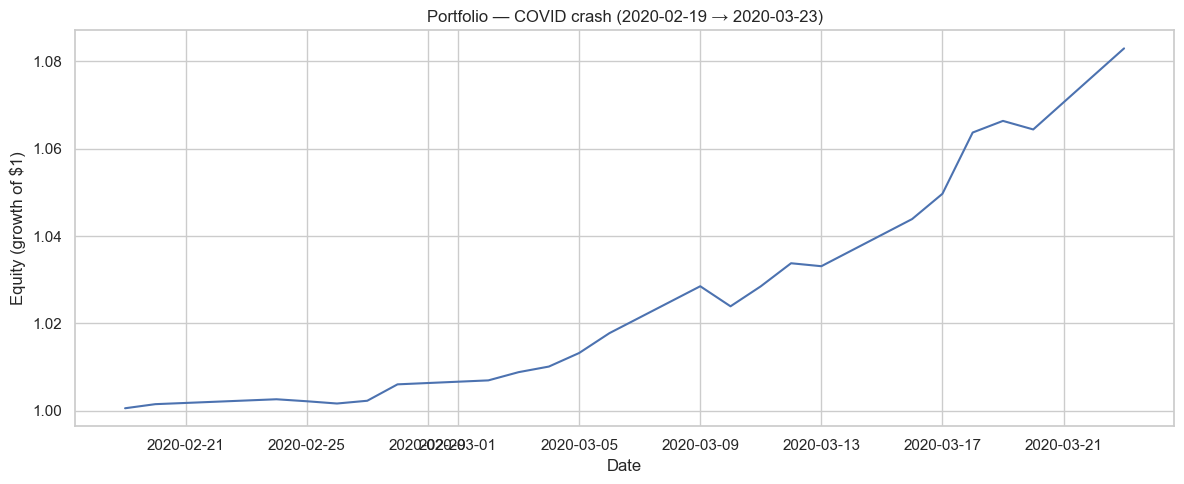

,start,end,assets_used,cum_return,max_drawdown
window,,,,,
Dot-com crash (AI bubble stress),2000-03-10,2002-10-09,14,28.97%,-10.98%
GFC (Private Credit bubble stress),2007-10-09,2009-03-09,28,0.36%,-6.66%
COVID crash,2020-02-19,2020-03-23,44,8.30%,-0.45%


### What this means now: 7) Backtests: quick read
- Best cumulative return window: Dot-com crash (AI bubble stress) (28.97%)
- Worst cumulative return window: GFC (Private Credit bubble stress) (0.36%)
- Worst max drawdown window: Dot-com crash (AI bubble stress) (-10.98%)
- Smallest max drawdown window: COVID crash (-0.45%)
- Weights are renormalized within each window to the subset of assets that have data in that window (see the “using X of Y assets” lines above).


Stress-window cumulative returns (computed from the same series used in the graphs):
 - Dot-com crash (AI bubble stress) (2000-03-10 → 2002-10-09): 28.97%
 - GFC (Private Credit bubble stress) (2007-10-09 → 2009-03-09): 0.36%
 - COVID crash (2020-02-19 → 2020-03-23): 8.30%


,metric,value
0,Cumulative return,39.80%
1,CAGR (geo),1.20%
2,Ann vol,2.80%
3,Sharpe (rf=0),0.43
4,Max drawdown,-14.86%


In [9]:
port = portfolio_returns(rets[asset_tickers], best_w)

def window_available_assets(start: str, end: str) -> list[str]:
    window = rets.loc[start:end, asset_tickers]
    return [c for c in window.columns if window[c].notna().any()]

def renormalized_window_weights(start: str, end: str) -> pd.Series:
    cols = window_available_assets(start, end)
    if not cols:
        return pd.Series(dtype=float)
    w = best_w.reindex(cols).fillna(0.0)
    if w.abs().sum() == 0:
        return pd.Series(dtype=float)
    return w * (GROSS_EXPOSURE / w.abs().sum())

def window_portfolio_returns(start: str, end: str) -> pd.Series:
    cols = window_available_assets(start, end)
    if not cols:
        return pd.Series(dtype=float)
    w = renormalized_window_weights(start, end)
    return portfolio_returns(rets.loc[start:end, cols], w)

def plot_equity_curve(r: pd.Series, title: str) -> None:
    if r is None or len(r) == 0:
        print('[skip] no data for:', title)
        return
    eq = (1 + r.fillna(0)).cumprod()
    plt.figure(figsize=(12, 5))
    plt.plot(eq.index, eq.values)
    plt.title(title)
    plt.ylabel('Equity (growth of $1)')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

# Full history plot
plot_equity_curve(port, 'Roster-driven bubble-resilient portfolio — Full History')

# Stress-window plots (renormalize to assets with data in each window)
summary_rows = []
for name in ['Dot-com crash (AI bubble stress)', 'GFC (Private Credit bubble stress)', 'COVID crash']:
    start, end = EVENT_WINDOWS[name]
    cols = window_available_assets(start, end)
    print(f"{name}: using {len(cols)} of {len(asset_tickers)} assets (weights renormalized within window)")
    wret = window_portfolio_returns(start, end)
    plot_equity_curve(wret, f'Portfolio — {name} ({start} → {end})')

    if wret is None or len(wret) == 0:
        summary_rows.append(
            {
                'window': name,
                'start': start,
                'end': end,
                'assets_used': len(cols),
                'cum_return': np.nan,
                'max_drawdown': np.nan,
            }
        )
        continue

    eq = (1 + wret.fillna(0)).cumprod()
    summary_rows.append(
        {
            'window': name,
            'start': start,
            'end': end,
            'assets_used': len(cols),
            'cum_return': float(eq.iloc[-1] - 1),
            'max_drawdown': max_drawdown(eq),
        }
    )

# Backtest summary table (these numbers correspond to the graphs above)
bt = pd.DataFrame(summary_rows).set_index('window')
try:
    from IPython.display import display
    display(bt.style.format({'cum_return': '{:.2%}', 'max_drawdown': '{:.2%}'}))
except Exception:
    # Fallback for non-notebook execution
    print(bt.to_string())

# Dynamic interpretation (updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        bullets = []
        cr = pd.to_numeric(bt['cum_return'], errors='coerce').dropna()
        dd = pd.to_numeric(bt['max_drawdown'], errors='coerce').dropna()

        if len(cr):
            best_window = cr.idxmax()
            worst_window = cr.idxmin()
            bullets.append(f'Best cumulative return window: {best_window} ({float(cr.loc[best_window]):.2%})')
            bullets.append(f'Worst cumulative return window: {worst_window} ({float(cr.loc[worst_window]):.2%})')

        if len(dd):
            worst_dd_w = dd.idxmin()
            best_dd_w = dd.idxmax()
            bullets.append(f'Worst max drawdown window: {worst_dd_w} ({float(dd.loc[worst_dd_w]):.2%})')
            bullets.append(f'Smallest max drawdown window: {best_dd_w} ({float(dd.loc[best_dd_w]):.2%})')

        bullets.append('Weights are renormalized within each window to the subset of assets that have data in that window (see the “using X of Y assets” lines above).')
        explain('7) Backtests: quick read', bullets)
    except Exception:
        pass

print()
print('Stress-window cumulative returns (computed from the same series used in the graphs):')
for w in ['Dot-com crash (AI bubble stress)', 'GFC (Private Credit bubble stress)', 'COVID crash']:
    if w not in bt.index:
        continue
    s = bt.loc[w, 'start']
    e = bt.loc[w, 'end']
    val = bt.loc[w, 'cum_return']
    if pd.isna(val):
        print(f' - {w} ({s} → {e}): n/a')
    else:
        print(f' - {w} ({s} → {e}): {float(val):.2%}')

# Metrics summary over full history
full_eq = (1 + port.fillna(0)).cumprod()
full_cum = float(full_eq.iloc[-1] - 1)
full_mdd = max_drawdown(full_eq)
full_ann_ret = ann_return_from_daily(port)
full_ann_vol = float(port.std() * np.sqrt(252))
full_sharpe = (full_ann_ret / full_ann_vol) if full_ann_vol and not np.isnan(full_ann_vol) else np.nan

pd.DataFrame({
    'metric': ['Cumulative return', 'CAGR (geo)', 'Ann vol', 'Sharpe (rf=0)', 'Max drawdown'],
    'value': [full_cum, full_ann_ret, full_ann_vol, full_sharpe, full_mdd],
})

# Display returns/risk metrics in % terms (Sharpe is unitless)
metrics = pd.DataFrame({
    'metric': ['Cumulative return', 'CAGR (geo)', 'Ann vol', 'Sharpe (rf=0)', 'Max drawdown'],
    'value': [full_cum, full_ann_ret, full_ann_vol, full_sharpe, full_mdd],
})

metrics['value'] = metrics.apply(
    lambda r: f"{r['value']:.2f}" if r['metric'].startswith('Sharpe') else f"{r['value']:.2%}",
    axis=1,
)
metrics


## 8) Forward-looking stress Monte Carlo (annual bubble-factor shocks) for 2026–2030

We simulate **5,000** paths of **annual** bubble-factor shocks (AI bubble / Private Credit bubble / Crypto bubble) across **2026–2030**, then compound yearly portfolio returns to produce a **5-year distribution**:
- Mean / Median 5-year return
- 5th / 95th percentile 5-year return
- Annualized volatility (based on simulated yearly portfolio returns)

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- Instead of one forecast, we generate **many possible 2026–2030 futures** by shocking the bubble tickers: AI bubble (QQQ), Private Credit bubble (HYG), Crypto bubble (BTC-USD).
- The output is a distribution (mean/median/5th/95th) so you can see both upside and downside.
- This is a forward-looking way to gauge “what could happen” under bubble-factor turbulence.


Annual factor models fit: 50 of 50 assets


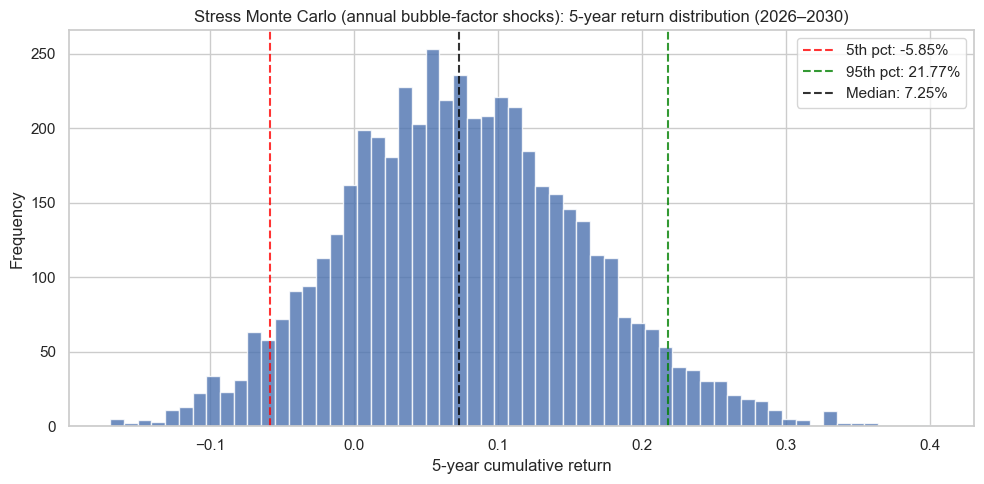

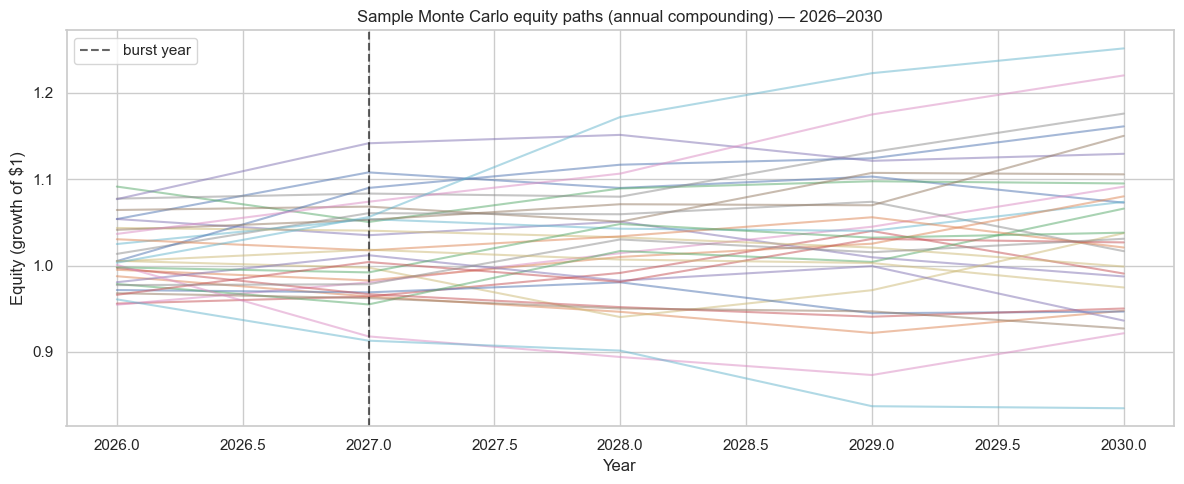

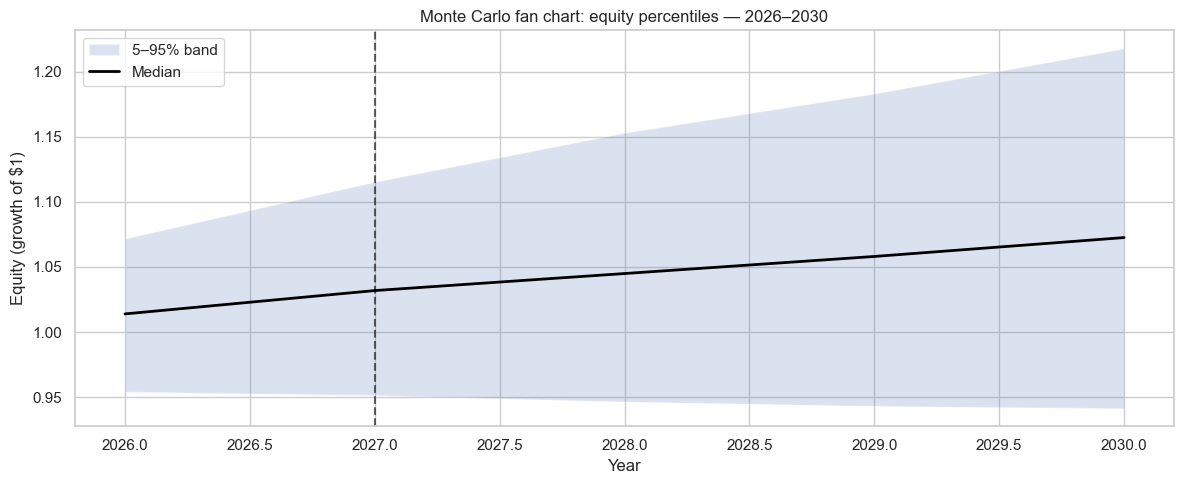

### What this means now: 8) Monte Carlo (2026–2030): quick read
- Paths simulated: 5000 | Burst year: 2027
- 5-year return: mean=7.55%, median=7.25%
- Downside/upside band (5th–95th): -5.85% to 21.77%
- Annualized volatility (yearly returns): 3.47%
- These figures update when Yahoo factor history or the portfolio weights change.

In [10]:
# Forward-looking stress Monte Carlo settings
N_PATHS = 5000
YEARS = list(range(2026, 2031))  # 2026–2030 inclusive
N_YEARS = len(YEARS)
BURST_YEAR = 2027               # choose when the triple-bubble burst happens inside 2026–2030
TAIL_K = 5                      # tail years used to source burst-year shocks per factor
TRAIN_YEARS = 10                # baseline distribution fit window

from pandas.tseries.frequencies import to_offset

try:
    to_offset('YE')
    YEARLY_FREQ = 'YE'
except Exception:
    YEARLY_FREQ = 'Y'

# Annual returns (from daily returns)
asset_y = (1 + rets[asset_tickers].fillna(0)).resample(YEARLY_FREQ).prod() - 1
factor_y = (1 + rets[bubble_tickers].fillna(0)).resample(YEARLY_FREQ).prod() - 1

# Fit annual factor models: asset_annual ~ const + (AI bubble, Private Credit bubble, Crypto bubble)
betas = {}
resid_sigmas = {}

for a in asset_tickers:
    y_series = asset_y[a].rename('__asset__')
    df = pd.concat([y_series, factor_y[bubble_tickers]], axis=1, join='inner').dropna()
    if df.shape[0] < 10:
        continue
    y = df['__asset__']
    X = sm.add_constant(df[bubble_tickers])
    fit = sm.OLS(y, X).fit()
    betas[a] = fit.params
    resid_sigmas[a] = float(fit.resid.std())

print('Annual factor models fit:', len(betas), 'of', len(asset_tickers), 'assets')

# Baseline factor distribution fit (use last TRAIN_YEARS years if available)
train_start = pd.Timestamp.today().normalize() - pd.DateOffset(years=TRAIN_YEARS)
train_f = factor_y.loc[train_start:].dropna()
if train_f.empty:
    train_f = factor_y.dropna()

mu = train_f[bubble_tickers].mean()
cov = train_f[bubble_tickers].cov()

# Tail shocks per factor (burst-year shocks sourced from worst annual returns)
tail_samples = {}
for f in bubble_tickers:
    s = factor_y[f].dropna().sort_values()
    tail_samples[f] = s.head(min(TAIL_K, len(s))).to_numpy()

rng_mc = np.random.default_rng(RANDOM_SEED + 123)

# Simulate baseline annual factor returns for all years
base = rng_mc.multivariate_normal(mu.values, cov.values, size=(N_PATHS, N_YEARS))
factors = base.copy()  # shape: (paths, years, factors)

# Inject triple-bubble burst in BURST_YEAR by replacing that year's factor returns with tail shocks
burst_idx = YEARS.index(BURST_YEAR) if BURST_YEAR in YEARS else None
if burst_idx is not None:
    for j, f in enumerate(bubble_tickers):
        tails = tail_samples.get(f)
        if tails is not None and len(tails) > 0:
            factors[:, burst_idx, j] = rng_mc.choice(tails, size=N_PATHS, replace=True)

# Build beta matrices (const + factor loadings) for vectorized simulation
n_assets = len(asset_tickers)
n_factors = len(bubble_tickers)

B = np.zeros((n_assets, n_factors))
c = np.zeros(n_assets)
sig = np.zeros(n_assets)
asset_mean_y = asset_y.mean()

for i, a in enumerate(asset_tickers):
    if a in betas:
        params = betas[a]
        c[i] = float(params.get('const', 0.0))
        for j, f in enumerate(bubble_tickers):
            B[i, j] = float(params.get(f, 0.0))
        sig[i] = float(resid_sigmas.get(a, 0.0))
    else:
        c[i] = float(asset_mean_y.get(a, 0.0))
        sig[i] = 0.0

# Simulate annual asset returns and annual portfolio returns
asset_pred = factors @ B.T + c[None, None, :]
eps = rng_mc.normal(loc=0.0, scale=sig[None, None, :], size=asset_pred.shape)
asset_sim = asset_pred + eps

w = best_w.reindex(asset_tickers).fillna(0.0).to_numpy()
port_yearly = asset_sim @ w  # shape: (paths, years)

# Compound annual returns into equity and 5-year cumulative return
eq = (1 + port_yearly).cumprod(axis=1)
cum_5y = eq[:, -1] - 1

mean5 = float(np.mean(cum_5y))
median5 = float(np.median(cum_5y))
p5 = float(np.percentile(cum_5y, 5))
p95 = float(np.percentile(cum_5y, 95))
ann_vol = float(port_yearly.std())  # annual volatility of yearly portfolio returns

stats_table = pd.DataFrame(
    {
        'metric': [
            'Mean 5-year portfolio return',
            'Median 5-year portfolio return',
            '5th percentile 5-year return',
            '95th percentile 5-year return',
            'Annualized volatility (yearly)',
        ],
        'value': [mean5, median5, p5, p95, ann_vol],
    }
)
stats_table['value'] = stats_table['value'].apply(lambda x: f"{x:.2%}")
stats_table

# Distribution plot
plt.figure(figsize=(10, 5))
plt.hist(cum_5y, bins=60, alpha=0.8)
plt.axvline(p5, color='red', linestyle='--', alpha=0.8, label=f'5th pct: {p5:.2%}')
plt.axvline(p95, color='green', linestyle='--', alpha=0.8, label=f'95th pct: {p95:.2%}')
plt.axvline(median5, color='black', linestyle='--', alpha=0.8, label=f'Median: {median5:.2%}')
plt.title('Stress Monte Carlo (annual bubble-factor shocks): 5-year return distribution (2026–2030)')
plt.xlabel('5-year cumulative return')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Sample equity paths
t = np.array(YEARS)
plt.figure(figsize=(12, 5))
plt.plot(t, eq[:30].T, alpha=0.5)
if burst_idx is not None:
    plt.axvline(YEARS[burst_idx], color='black', linestyle='--', alpha=0.6, label='burst year')
plt.title('Sample Monte Carlo equity paths (annual compounding) — 2026–2030')
plt.ylabel('Equity (growth of $1)')
plt.xlabel('Year')
if burst_idx is not None:
    plt.legend()
plt.tight_layout()
plt.show()

# Fan chart percentiles
bands = np.percentile(eq, [5, 50, 95], axis=0)
plt.figure(figsize=(12, 5))
plt.fill_between(t, bands[0], bands[2], alpha=0.2, label='5–95% band')
plt.plot(t, bands[1], color='black', linewidth=2, label='Median')
if burst_idx is not None:
    plt.axvline(YEARS[burst_idx], color='black', linestyle='--', alpha=0.6)
plt.title('Monte Carlo fan chart: equity percentiles — 2026–2030')
plt.ylabel('Equity (growth of $1)')
plt.xlabel('Year')
plt.legend()
plt.tight_layout()
plt.show()

# Dynamic interpretation (updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        explain(
            '8) Monte Carlo (2026–2030): quick read',
            [
                f'Paths simulated: {N_PATHS} | Burst year: {BURST_YEAR}',
                f'5-year return: mean={mean5:.2%}, median={median5:.2%}',
                f'Downside/upside band (5th–95th): {p5:.2%} to {p95:.2%}',
                f'Annualized volatility (yearly returns): {ann_vol:.2%}',
                'These figures update when Yahoo factor history or the portfolio weights change.',
            ],
        )
    except Exception:
        pass


## 9) Time-series forecasting (Auto-ARIMA + Seasonal SARIMAX + Regime/Volatility models) for 2026–2030

This section upgrades forecasting realism in three complementary ways:

1) **Automatic ARIMA order selection** (AIC-based) on monthly portfolio returns
2) **Seasonal SARIMAX** candidates (monthly seasonality)
3) **Regime / volatility modeling** (Markov switching variance)

For each model we show the mean forecast + CI *and* a simulated fan chart, so you can see realistic volatility/uncertainty rather than a flat mean line.

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- These models generate **baseline future paths** from historical behavior (not explicit bubble-burst scenarios).
- Use the **fan charts** to understand uncertainty/volatility; use the comparison table to see how model assumptions change the downside range.
- For explicit “AI/Private Credit/Crypto bubble burst” scenarios, Section 10 is the main forward-looking stress test.


Portfolio monthly returns span: 1999-01-31 → 2026-02-28
Forecast horizon: 2026-03-31 → 2030-12-31 (58 months)

--- 9A) Auto-ARIMA order selection (AIC) ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Selected ARIMA: {'order': (1, 0, 1), 'trend': 'c', 'aic': -2209.5783847773787}


,p,d,q,trend,aic
7,1,0,1,c,-2209.58
8,1,0,2,c,-2207.72
0,0,0,0,c,-2206.46
1,0,0,1,c,-2205.67
6,1,0,0,c,-2205.59
2,0,0,2,c,-2204.19
12,2,0,0,c,-2203.91
13,2,0,1,c,-2200.46
11,1,1,2,n,-2200.14
14,2,0,2,c,-2200.07



Simple-English (9A Auto-ARIMA):
 - What it is: a baseline time-series model that assumes ONE stable return regime with short-memory dynamics.
 - What the fan chart means: many plausible 2026–2030 equity paths for this portfolio, not a single prediction line.
 - How to read it: focus on the 5–95% band and especially the 5th percentile (p5) as a conservative downside baseline.
 - Bubble context: this is a *baseline* forecast; the explicit bubble-burst stress tests are still Sections 7/8/10.


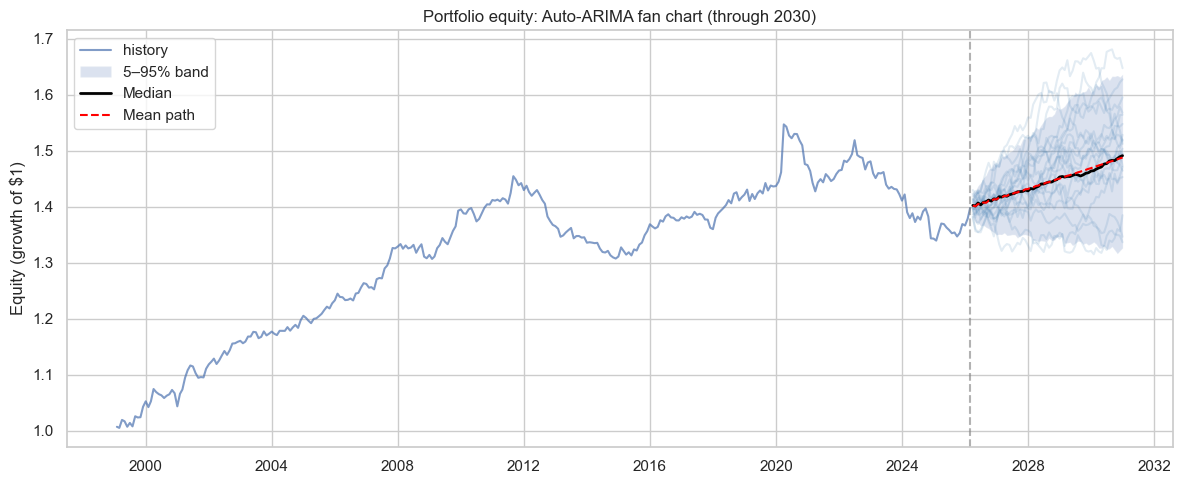


--- 9B) Seasonal SARIMAX candidates (monthly seasonality) ---


,order,seasonal_order,trend,aic
0,"(1, 0, 1)","(0, 0, 0, 12)",c,-2194.96
1,"(1, 0, 1)","(1, 0, 0, 12)",c,-2122.13
2,"(1, 0, 1)","(0, 0, 1, 12)",c,-2118.56
3,"(1, 0, 1)","(1, 0, 1, 12)",c,-2114.42


Selected seasonal_order: (0, 0, 0, 12)

Simple-English (9B Seasonal SARIMAX):
 - What it is: like ARIMA, but it also allows repeating monthly patterns (seasonality) if the data actually contains them.
 - What to compare vs 9A: if this fan chart meaningfully shifts the downside (p5) or widens/narrows the band, seasonality matters.
 - Bubble context: still baseline behavior; use bubble stress sections to test explicit shock scenarios.


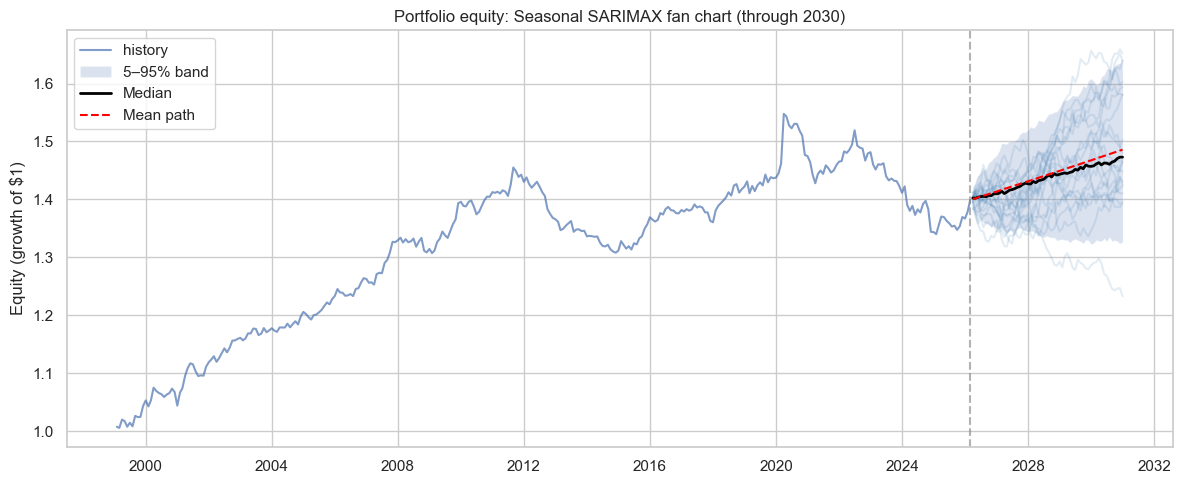


--- 9C) Regime / volatility model (Markov switching variance) ---
Regime mapping: Regime 0 = CALM (lower vol); Regime 1 = STRESS (higher vol).


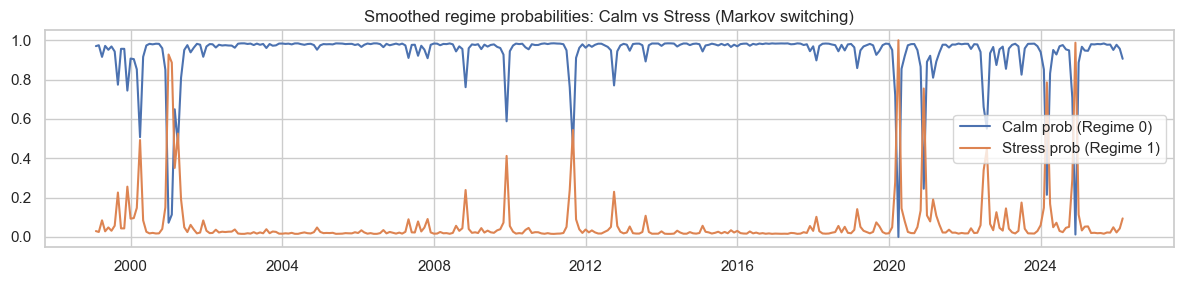

,label,mean_monthly_return,vol_monthly,P(stay)
regime,,,,
0,Calm,0.10%,0.67%,95.19%
1,Stress,0.20%,1.94%,30.77%



Simple-English (9C Regime-switching / Markov volatility):
 - What it is: the portfolio can switch between a calmer regime and a higher-volatility regime.
 - Mapping used here: Regime 0 = Calm (lower vol) and Regime 1 = Stress (higher vol).
 - The regime-probability chart shows when the portfolio historically behaved more like “calm” vs “stress”.
 - The fan chart simulates 2026–2030 paths that can jump between regimes — often closer to crisis/bubble-burst style behavior.


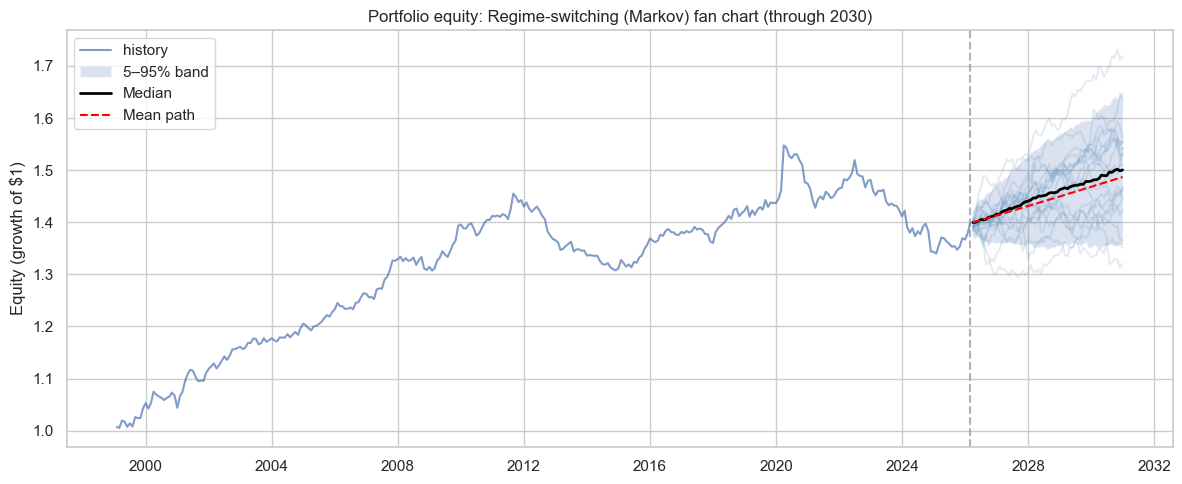


--- 9D) Model comparison (cumulative return to 2030) ---


,mean_cum_return,p5_cum_return,p50_cum_return,p95_cum_return
model,,,,
Auto ARIMA,6.45%,-5.09%,6.70%,17.10%
Seasonal SARIMAX,6.28%,-5.13%,5.36%,17.38%
Regime-switching (Markov),6.35%,-2.95%,7.32%,18.17%



Simple-English interpretation (in the context of beating the AI / Private Credit / Crypto bubbles):
 - These 3 models are *different ways to simulate baseline 2026–2030 return paths* for the SAME portfolio.
 - Auto ARIMA: assumes one stable regime (single volatility level) with short-memory dynamics.
 - Seasonal SARIMAX: same idea, but allows repeating monthly seasonality patterns (if they exist in the data).
 - Regime-switching (Markov): allows switching between calm vs high-volatility regimes — often closer to crisis/bubble-burst behavior.
 - How to read the table:
    * mean_cum_return: expected baseline growth (not guaranteed).
    * p5_cum_return: conservative downside (bad but plausible). Higher p5 → more resilient baseline.
    * p50/p95: median/upside ranges.
 - For the “triple-bubble” goal: use this table for *baseline uncertainty*, and use Sections 7/8/10 for *explicit bubble-burst stress tests*.

--- 9E) Asset-level forecasts (baseline) + implied portfolio fan chart from as

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver

,name,weight,hist_months,mean_monthly_forecast,cum_return_forecast
symbol,,,,,
SRLN,State Street Blackstone Senior,-12.05%,326,0.15%,9.12%
EMB,iShares J.P. Morgan USD Emergin,-5.23%,326,0.29%,18.42%
HYG,iShares iBoxx $ High Yield Corp,-4.50%,326,0.31%,19.75%
IYW,iShares U.S. Technology ETF,-4.14%,326,0.87%,65.56%
HACK,Amplify Cybersecurity ETF,4.12%,326,0.42%,27.66%
SHY,iShares 1-3 Year Treasury Bond,3.83%,326,0.15%,8.96%
MSFT,Microsoft Corporation,3.64%,326,1.28%,109.14%
XLC,State Street Communication Serv,3.33%,326,0.35%,22.27%
IEF,iShares 7-10 Year Treasury Bond,3.07%,326,0.28%,17.34%


Assets with ARIMA forecasts used: 50 of 50


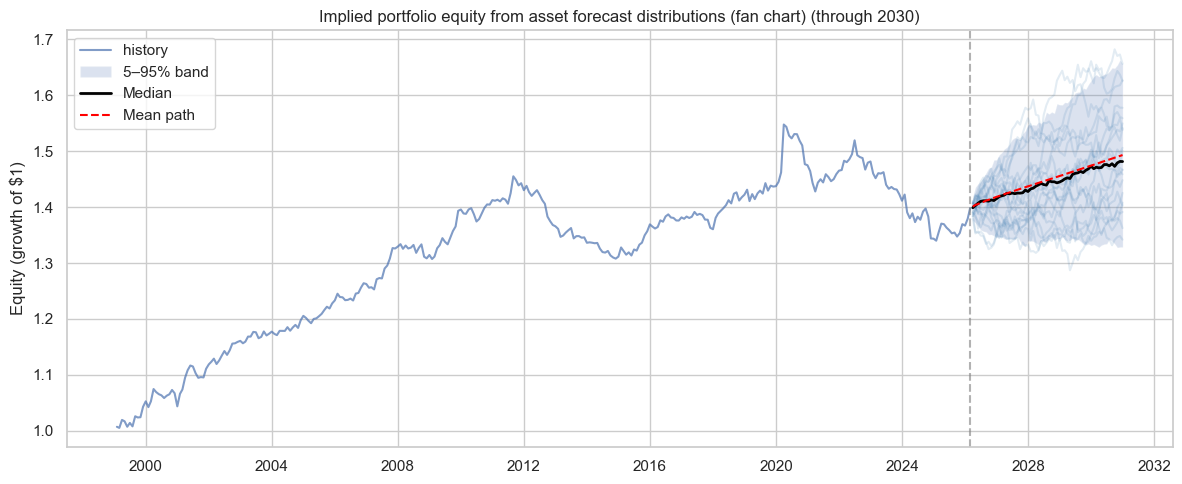


Simple-English (9E Asset-implied fan chart):
 - What it is: we forecast each asset (baseline ARIMA), then combine them using the portfolio weights to simulate portfolio equity paths.
 - Why it helps: it’s a cross-check — it tells a similar story to 9A/9B/9C when the assumptions are consistent.
 - If 9E differs a lot: usually it means limited asset model coverage (few assets had enough history) or different volatility assumptions by asset.
Implied mean monthly portfolio forecast (from asset models): 0.11%
Implied mean cumulative return (from asset models): 6.79%


### What this means now: 9) Forecasting (live summary)
- Forecast horizon: 2026-03-31 → 2030-12-31 (58 months)
- Best downside (highest p5 cum return): Regime-switching (Markov) (-2.95%)
- Worst downside (lowest p5 cum return): Seasonal SARIMAX (-5.13%)
- Mean cumulative return to 2030 by model: Auto ARIMA 6.45%; Seasonal SARIMAX 6.28%; Regime-switching (Markov) 6.35%
- Assets with ARIMA forecasts used in 9E: 50 of 50

In [11]:
# Monthly returns for portfolio and selected assets
port_monthly = (1 + port.fillna(0)).resample(MONTHLY_FREQ).prod() - 1
port_monthly = port_monthly.dropna()

asset_monthly = (1 + rets[asset_tickers].fillna(0)).resample(MONTHLY_FREQ).prod() - 1
asset_monthly = asset_monthly.dropna(how='all')

# Forecast months until 2030-12 (month-end)
last_month = port_monthly.index.max()
end_month = pd.Timestamp('2030-12-31').to_period('M').to_timestamp(how='end')
steps = (end_month.to_period('M') - last_month.to_period('M')).n
steps = max(int(steps), 1)
future_index = pd.date_range(last_month + pd.offsets.MonthEnd(1), periods=steps, freq=MONTHLY_FREQ)

print('Portfolio monthly returns span:', port_monthly.index.min().date(), '→', port_monthly.index.max().date())
print('Forecast horizon:', future_index[0].date(), '→', future_index[-1].date(), f'({steps} months)')

# Notebook-friendly display helper
def _display_df(df: pd.DataFrame, fmt: dict | None = None) -> None:
    try:
        from IPython.display import display

        if fmt:
            display(df.style.format(fmt))
        else:
            display(df)
    except Exception:
        print(df)

hist_eq = (1 + port_monthly).cumprod()
start_eq = float(hist_eq.iloc[-1]) if len(hist_eq) else 1.0

def _normalize_sim(sim_arr: np.ndarray, n_steps: int, n_paths: int) -> np.ndarray:
    sim_arr = np.asarray(sim_arr)
    if sim_arr.ndim == 1:
        sim_arr = sim_arr.reshape(-1, 1)
    if sim_arr.shape[0] != n_steps and sim_arr.shape[1] == n_steps:
        sim_arr = sim_arr.T
    return sim_arr[:n_steps, :n_paths]

def _simulate_from_model(model, mean_series: pd.Series, n_paths: int, rng: np.random.Generator, fallback_sigma: float) -> np.ndarray:
    sim_arr = None
    try:
        sim = model.simulate(nsimulations=len(mean_series), anchor='end', repetitions=n_paths)
        sim_arr = np.asarray(sim)
    except Exception:
        sim_arr = None

    if sim_arr is None or np.asarray(sim_arr).size == 0:
        sigma = fallback_sigma
        try:
            sigma = float(model.resid.std())
        except Exception:
            pass
        z = rng.normal(size=(len(mean_series), n_paths))
        sim_arr = mean_series.to_numpy()[:, None] + sigma * z

    return _normalize_sim(sim_arr, len(mean_series), n_paths)

def _fan_chart(title: str, mean_returns: pd.Series, sim_returns: np.ndarray) -> dict:
    mean_eq = start_eq * (1 + mean_returns).cumprod()
    eq_paths = start_eq * (1 + sim_returns).cumprod(axis=0)
    p5, p50, p95 = np.percentile(eq_paths, [5, 50, 95], axis=1)

    plt.figure(figsize=(12, 5))
    plt.plot(hist_eq.index, hist_eq.values, label='history', alpha=0.7)
    plt.plot(mean_returns.index, eq_paths[:, :20], color='steelblue', alpha=0.15)
    plt.fill_between(mean_returns.index, p5, p95, alpha=0.2, label='5–95% band')
    plt.plot(mean_returns.index, p50, color='black', linewidth=2, label='Median')
    plt.plot(mean_returns.index, mean_eq.values, color='red', linestyle='--', label='Mean path')
    plt.axvline(hist_eq.index[-1], color='gray', linestyle='--', alpha=0.6)
    plt.title(title)
    plt.ylabel('Equity (growth of $1)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    cum_paths = eq_paths[-1, :] / start_eq - 1
    return {
        'mean_cum_return': float(mean_eq.iloc[-1] / start_eq - 1),
        'p5_cum_return': float(np.percentile(cum_paths, 5)),
        'p50_cum_return': float(np.percentile(cum_paths, 50)),
        'p95_cum_return': float(np.percentile(cum_paths, 95)),
    }


print()
print('--- 9A) Auto-ARIMA order selection (AIC) ---')

def fit_arima_auto(series: pd.Series, p_values=(0, 1, 2), d_values=(0, 1), q_values=(0, 1, 2)):
    candidates = []
    best_model = None
    best_aic = np.inf
    best_spec = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                trend = 'c' if d == 0 else 'n'
                try:
                    m = ARIMA(series, order=(p, d, q), trend=trend).fit()
                    aic = float(m.aic)
                    candidates.append({'p': p, 'd': d, 'q': q, 'trend': trend, 'aic': aic})
                    if np.isfinite(aic) and aic < best_aic:
                        best_aic = aic
                        best_model = m
                        best_spec = {'order': (p, d, q), 'trend': trend, 'aic': aic}
                except Exception:
                    continue

    tbl = pd.DataFrame(candidates).sort_values('aic')
    return best_model, best_spec, tbl


arima_model, arima_spec, arima_tbl = fit_arima_auto(port_monthly)
if arima_model is None:
    raise RuntimeError('ARIMA auto-selection failed: no candidate models could be fit.')

print('Selected ARIMA:', arima_spec)
_display_df(arima_tbl.head(10), fmt={'aic': '{:.2f}'})

arima_fc = arima_model.get_forecast(steps=steps)
arima_mean = pd.Series(arima_fc.predicted_mean.to_numpy()[:steps], index=future_index)

rng_arima = np.random.default_rng(RANDOM_SEED + 999)
sim_arima = _simulate_from_model(arima_model, arima_mean, 300, rng_arima, fallback_sigma=float(port_monthly.std()))

print()
print('Simple-English (9A Auto-ARIMA):')
print(' - What it is: a baseline time-series model that assumes ONE stable return regime with short-memory dynamics.')
print(' - What the fan chart means: many plausible 2026–2030 equity paths for this portfolio, not a single prediction line.')
print(' - How to read it: focus on the 5–95% band and especially the 5th percentile (p5) as a conservative downside baseline.')
print(' - Bubble context: this is a *baseline* forecast; the explicit bubble-burst stress tests are still Sections 7/8/10.')
summary_arima = _fan_chart('Portfolio equity: Auto-ARIMA fan chart (through 2030)', arima_mean, sim_arima)


print()
print('--- 9B) Seasonal SARIMAX candidates (monthly seasonality) ---')

seasonal_candidates = [
    (0, 0, 0, 12),
    (1, 0, 0, 12),
    (0, 0, 1, 12),
    (1, 0, 1, 12),
]

sarimax_rows = []
sarimax_model = None
sarimax_seasonal = None
sarimax_best_aic = np.inf

for seas in seasonal_candidates:
    try:
        m = sm.tsa.statespace.SARIMAX(
            port_monthly,
            order=arima_spec['order'],
            seasonal_order=seas,
            trend=arima_spec['trend'],
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(disp=False)
        aic = float(m.aic)
        sarimax_rows.append(
            {
                'order': str(arima_spec['order']),
                'seasonal_order': str(seas),
                'trend': arima_spec['trend'],
                'aic': aic,
            }
        )
        if np.isfinite(aic) and aic < sarimax_best_aic:
            sarimax_best_aic = aic
            sarimax_model = m
            sarimax_seasonal = seas
    except Exception:
        continue

summary_sarimax = None
if sarimax_rows:
    sarimax_tbl = pd.DataFrame(sarimax_rows).sort_values('aic')
    _display_df(sarimax_tbl, fmt={'aic': '{:.2f}'})
else:
    sarimax_tbl = pd.DataFrame([])
    print('No SARIMAX seasonal models could be fit.')

if sarimax_model is not None:
    print('Selected seasonal_order:', sarimax_seasonal)
    fc = sarimax_model.get_forecast(steps=steps)
    mean = pd.Series(fc.predicted_mean.to_numpy()[:steps], index=future_index)

    rng_sarimax = np.random.default_rng(RANDOM_SEED + 1999)
    sim_sarimax = _simulate_from_model(sarimax_model, mean, 300, rng_sarimax, fallback_sigma=float(port_monthly.std()))

    print()
    print('Simple-English (9B Seasonal SARIMAX):')
    print(' - What it is: like ARIMA, but it also allows repeating monthly patterns (seasonality) if the data actually contains them.')
    print(' - What to compare vs 9A: if this fan chart meaningfully shifts the downside (p5) or widens/narrows the band, seasonality matters.')
    print(' - Bubble context: still baseline behavior; use bubble stress sections to test explicit shock scenarios.')
    summary_sarimax = _fan_chart('Portfolio equity: Seasonal SARIMAX fan chart (through 2030)', mean, sim_sarimax)


print()
print('--- 9C) Regime / volatility model (Markov switching variance) ---')

summary_regime = None
try:
    from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

    mr = MarkovRegression(port_monthly, k_regimes=2, trend='c', switching_variance=True)
    mr_res = mr.fit(disp=False)

    probs = mr_res.smoothed_marginal_probabilities

    params = mr_res.params

    def _pget(key: str, default: float) -> float:
        try:
            return float(params[key])
        except Exception:
            return default

    p00 = _pget('p[0->0]', np.nan)
    p10 = _pget('p[1->0]', np.nan)
    if np.isfinite(p00) and np.isfinite(p10):
        P = np.array([[p00, 1 - p00], [p10, 1 - p10]])
    else:
        reg = probs.idxmax(axis=1).to_numpy()
        counts = np.zeros((2, 2))
        for a, b in zip(reg[:-1], reg[1:]):
            counts[int(a), int(b)] += 1
        row_sums = counts.sum(axis=1, keepdims=True)
        row_sums = np.where(row_sums == 0, 1.0, row_sums)
        P = counts / row_sums

    mu0 = _pget('const[0]', np.nan)
    mu1 = _pget('const[1]', np.nan)
    v0 = _pget('sigma2[0]', np.nan)
    v1 = _pget('sigma2[1]', np.nan)

    if not (np.isfinite(mu0) and np.isfinite(mu1) and np.isfinite(v0) and np.isfinite(v1)):
        reg = probs.idxmax(axis=1)
        mu0 = float(port_monthly[reg == 0].mean())
        mu1 = float(port_monthly[reg == 1].mean())
        v0 = float(port_monthly[reg == 0].var())
        v1 = float(port_monthly[reg == 1].var())

    sig0 = float(np.sqrt(abs(v0)))
    sig1 = float(np.sqrt(abs(v1)))

    # Label regimes as Calm vs Stress based on volatility (sigma)
    if sig0 <= sig1:
        calm_regime = 0
        stress_regime = 1
    else:
        calm_regime = 1
        stress_regime = 0

    print(f'Regime mapping: Regime {calm_regime} = CALM (lower vol); Regime {stress_regime} = STRESS (higher vol).')

    plt.figure(figsize=(12, 3))
    plt.plot(probs.index, probs[calm_regime], label=f'Calm prob (Regime {calm_regime})')
    plt.plot(probs.index, probs[stress_regime], label=f'Stress prob (Regime {stress_regime})')
    plt.title('Smoothed regime probabilities: Calm vs Stress (Markov switching)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    regime_table = pd.DataFrame(
        {
            'label': [
                'Calm' if calm_regime == 0 else 'Stress',
                'Calm' if calm_regime == 1 else 'Stress',
            ],
            'mean_monthly_return': [mu0, mu1],
            'vol_monthly': [sig0, sig1],
            'P(stay)': [float(P[0, 0]), float(P[1, 1])],
        },
        index=pd.Index([0, 1], name='regime'),
    )
    regime_table = regime_table.sort_values('vol_monthly')
    _display_df(regime_table, fmt={'mean_monthly_return': '{:.2%}', 'vol_monthly': '{:.2%}', 'P(stay)': '{:.2%}'})

    print()
    print('Simple-English (9C Regime-switching / Markov volatility):')
    print(' - What it is: the portfolio can switch between a calmer regime and a higher-volatility regime.')
    print(f' - Mapping used here: Regime {calm_regime} = Calm (lower vol) and Regime {stress_regime} = Stress (higher vol).')
    print(' - The regime-probability chart shows when the portfolio historically behaved more like “calm” vs “stress”.')
    print(' - The fan chart simulates 2026–2030 paths that can jump between regimes — often closer to crisis/bubble-burst style behavior.')

    N_SIM = 300
    rng_reg = np.random.default_rng(RANDOM_SEED + 3030)
    init_p = probs.iloc[-1].to_numpy()
    init_p = init_p / init_p.sum() if init_p.sum() > 0 else np.array([0.5, 0.5])

    regimes = rng_reg.choice([0, 1], size=N_SIM, p=init_p)
    sim_rets = np.zeros((steps, N_SIM), dtype=float)

    for t in range(steps):
        r0 = rng_reg.normal(loc=mu0, scale=sig0, size=N_SIM)
        r1 = rng_reg.normal(loc=mu1, scale=sig1, size=N_SIM)
        sim_rets[t] = np.where(regimes == 0, r0, r1)

        if t < steps - 1:
            u = rng_reg.random(size=N_SIM)
            next_reg = np.where(
                regimes == 0,
                np.where(u < P[0, 0], 0, 1),
                np.where(u < P[1, 0], 0, 1),
            )
            regimes = next_reg

    # Mean path via propagated expected regime probabilities
    pi = init_p.copy()
    mean_path = []
    for _ in range(steps):
        mean_path.append(pi[0] * mu0 + pi[1] * mu1)
        pi = pi @ P
    mean_path = pd.Series(mean_path, index=future_index)

    summary_regime = _fan_chart('Portfolio equity: Regime-switching (Markov) fan chart (through 2030)', mean_path, sim_rets)
except Exception as e:
    print('Regime-switching model could not be fit:', str(e)[:200])


print()
print('--- 9D) Model comparison (cumulative return to 2030) ---')

rows = [{'model': 'Auto ARIMA', **summary_arima}]
if summary_sarimax is not None:
    rows.append({'model': 'Seasonal SARIMAX', **summary_sarimax})
if summary_regime is not None:
    rows.append({'model': 'Regime-switching (Markov)', **summary_regime})

compare = pd.DataFrame(rows).set_index('model')
_display_df(compare, fmt={
    'mean_cum_return': '{:.2%}',
    'p5_cum_return': '{:.2%}',
    'p50_cum_return': '{:.2%}',
    'p95_cum_return': '{:.2%}',
})

print()
print('Simple-English interpretation (in the context of beating the AI / Private Credit / Crypto bubbles):')
print(' - These 3 models are *different ways to simulate baseline 2026–2030 return paths* for the SAME portfolio.')
print(' - Auto ARIMA: assumes one stable regime (single volatility level) with short-memory dynamics.')
print(' - Seasonal SARIMAX: same idea, but allows repeating monthly seasonality patterns (if they exist in the data).')
print(' - Regime-switching (Markov): allows switching between calm vs high-volatility regimes — often closer to crisis/bubble-burst behavior.')
print(' - How to read the table:')
print('    * mean_cum_return: expected baseline growth (not guaranteed).')
print('    * p5_cum_return: conservative downside (bad but plausible). Higher p5 → more resilient baseline.')
print('    * p50/p95: median/upside ranges.')
print(' - For the “triple-bubble” goal: use this table for *baseline uncertainty*, and use Sections 7/8/10 for *explicit bubble-burst stress tests*.')


print()
print('--- 9E) Asset-level forecasts (baseline) + implied portfolio fan chart from asset distributions ---')

def fit_asset_arima(series: pd.Series):
    series = series.dropna()
    if len(series) < 60:
        return None
    try:
        return ARIMA(series, order=arima_spec['order'], trend=arima_spec['trend']).fit()
    except Exception:
        try:
            return ARIMA(series, order=(1, 0, 0), trend='c').fit()
        except Exception:
            return None

asset_fc_means = {}
asset_fc_sigmas = {}
rows = []

for sym in asset_tickers:
    s = asset_monthly[sym].dropna()
    m = fit_asset_arima(s)
    if m is None:
        continue

    fc = m.get_forecast(steps=steps)
    mean_values = fc.predicted_mean.to_numpy()
    if len(mean_values) < steps:
        mean_values = np.pad(mean_values, (0, steps - len(mean_values)), mode='edge')
    mean_values = mean_values[:steps]

    try:
        sigma = float(m.resid.std())
    except Exception:
        sigma = float(s.std())
    sigma = float(sigma) if np.isfinite(sigma) else 0.0

    asset_fc_means[sym] = mean_values
    asset_fc_sigmas[sym] = sigma
    rows.append(
        {
            'symbol': sym,
            'name': yahoo_name(sym),
            'weight': float(best_w.get(sym, 0.0)),
            'hist_months': int(len(s)),
            'mean_monthly_forecast': float(np.mean(mean_values)),
            'cum_return_forecast': float((1 + pd.Series(mean_values)).prod() - 1),
        }
    )

asset_forecast_table = pd.DataFrame(rows).set_index('symbol').sort_values(
    'weight', key=lambda s: np.abs(s), ascending=False
)

_display_df(asset_forecast_table, fmt={
    'weight': '{:.2%}',
    'mean_monthly_forecast': '{:.2%}',
    'cum_return_forecast': '{:.2%}',
})

hist_mu = asset_monthly.mean()
hist_sigma = asset_monthly.std()

mu_mat = np.zeros((steps, len(asset_tickers)), dtype=float)
sig_mat = np.zeros((steps, len(asset_tickers)), dtype=float)

for j, sym in enumerate(asset_tickers):
    if sym in asset_fc_means:
        mu_mat[:, j] = asset_fc_means[sym]
        sig = float(asset_fc_sigmas.get(sym, 0.0))
    else:
        mu = float(hist_mu.get(sym, 0.0))
        sig = float(hist_sigma.get(sym, 0.0))
        mu_mat[:, j] = mu if np.isfinite(mu) else 0.0

    sig = sig if np.isfinite(sig) else 0.0
    sig_mat[:, j] = sig

print('Assets with ARIMA forecasts used:', len(asset_fc_means), 'of', len(asset_tickers))

w = best_w.reindex(asset_tickers).fillna(0.0).to_numpy()
port_mean = mu_mat @ w

N_SIM_ASSET_PORT = 300
rng_assets = np.random.default_rng(RANDOM_SEED + 2021)
z = rng_assets.normal(size=(steps, N_SIM_ASSET_PORT, len(asset_tickers)))
asset_sims = mu_mat[:, None, :] + sig_mat[:, None, :] * z
port_sims = np.tensordot(asset_sims, w, axes=([2], [0]))

mean_eq = start_eq * (1 + pd.Series(port_mean, index=future_index)).cumprod()
sim_eq2 = start_eq * (1 + port_sims).cumprod(axis=0)
q5, q50, q95 = np.percentile(sim_eq2, [5, 50, 95], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(hist_eq.index, hist_eq.values, label='history', alpha=0.7)
plt.plot(future_index, sim_eq2[:, :20], color='steelblue', alpha=0.15)
plt.fill_between(future_index, q5, q95, alpha=0.2, label='5–95% band')
plt.plot(future_index, q50, color='black', linewidth=2, label='Median')
plt.plot(future_index, mean_eq.values, color='red', linestyle='--', label='Mean path')
plt.axvline(hist_eq.index[-1], color='gray', linestyle='--', alpha=0.6)
plt.title('Implied portfolio equity from asset forecast distributions (fan chart) (through 2030)')
plt.ylabel('Equity (growth of $1)')
plt.legend()
plt.tight_layout()
plt.show()

print()
print('Simple-English (9E Asset-implied fan chart):')
print(' - What it is: we forecast each asset (baseline ARIMA), then combine them using the portfolio weights to simulate portfolio equity paths.')
print(' - Why it helps: it’s a cross-check — it tells a similar story to 9A/9B/9C when the assumptions are consistent.')
print(' - If 9E differs a lot: usually it means limited asset model coverage (few assets had enough history) or different volatility assumptions by asset.')

print('Implied mean monthly portfolio forecast (from asset models):', f"{float(np.mean(port_mean)):.2%}")
print('Implied mean cumulative return (from asset models):', f"{float(mean_eq.iloc[-1] / start_eq - 1):.2%}")

# Dynamic interpretation (updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        bullets = []
        try:
            bullets.append(f'Forecast horizon: {future_index[0].date()} → {future_index[-1].date()} ({steps} months)')
        except Exception:
            pass

        try:
            p5s = pd.to_numeric(compare['p5_cum_return'], errors='coerce').dropna()
            if len(p5s):
                best_p5 = p5s.idxmax()
                worst_p5 = p5s.idxmin()
                bullets.append(f'Best downside (highest p5 cum return): {best_p5} ({float(p5s.loc[best_p5]):.2%})')
                bullets.append(f'Worst downside (lowest p5 cum return): {worst_p5} ({float(p5s.loc[worst_p5]):.2%})')
        except Exception:
            pass

        try:
            means = pd.to_numeric(compare['mean_cum_return'], errors='coerce').dropna()
            if len(means):
                means_txt = '; '.join([f'{k} {v:.2%}' for k, v in means.items()])
                bullets.append('Mean cumulative return to 2030 by model: ' + means_txt)
        except Exception:
            pass

        try:
            bullets.append(f'Assets with ARIMA forecasts used in 9E: {len(asset_fc_means)} of {len(asset_tickers)}')
        except Exception:
            pass

        explain('9) Forecasting (live summary)', bullets)
    except Exception:
        pass


## 10) Stress tests: Forward-looking triple-bubble burst scenario (2026–2030)

We fit a **multi-factor regression** of each portfolio asset on bubble tickers:
- **AI bubble** (`QQQ`)
- **Private Credit bubble** (`HYG`)
- **Crypto bubble** (`BTC-USD`)

Then we build a **forward-looking 2026–2030** scenario by simulating monthly bubble returns and **injecting historical analog shock sequences** into that future window.

**Output policy for this section:** keep it minimal. We plot the bubble paths + portfolio equity curves, plus an additional bar chart of scenario cumulative returns, and show the forward-looking results table.

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- This is the most direct answer to the project objective: **“What happens if each bubble bursts in 2026–2030? And what if all three burst?”**
- We simulate bubble-factor paths and inject historical crash sequences as “shock blocks” into the future.
- Then we translate those bubble moves into portfolio returns and compare scenarios side-by-side.


Factor models fit: 50 of 50 assets


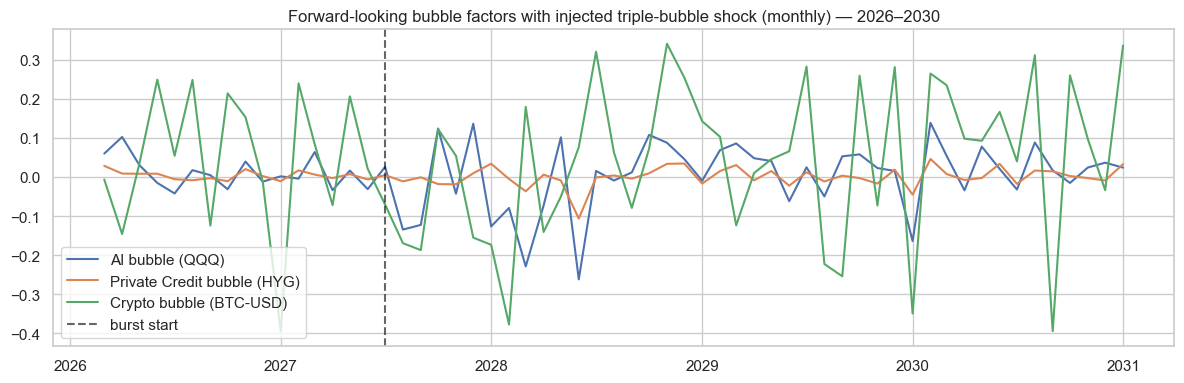

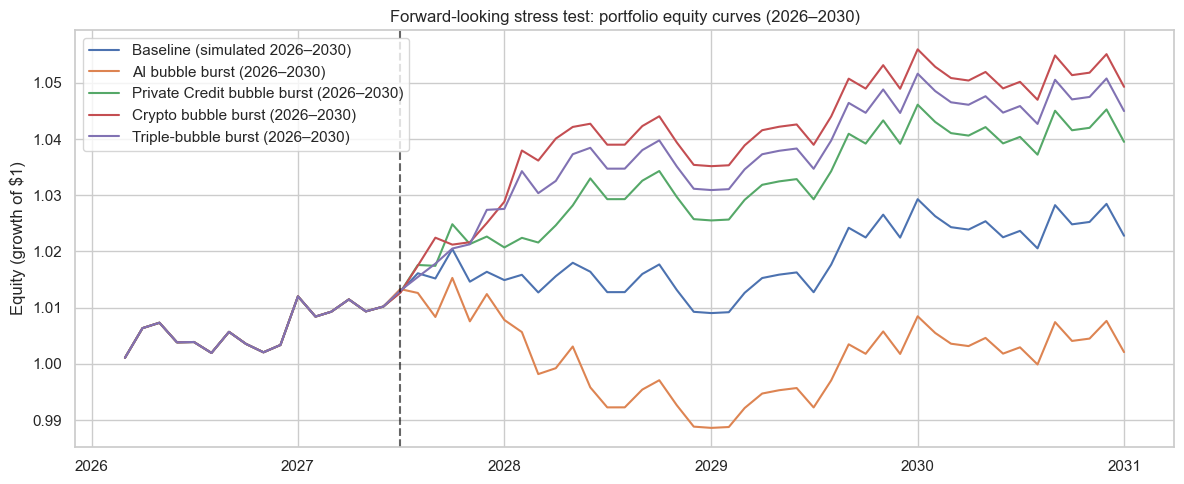

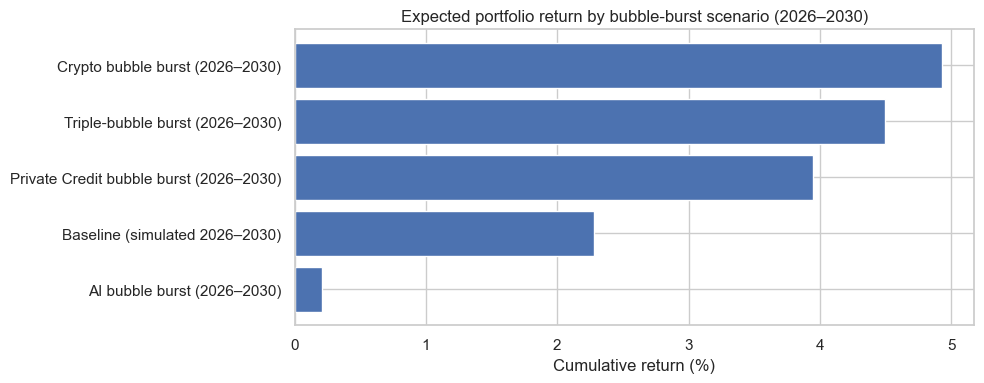

### What this means now: 10) Forward-looking bubble-burst scenarios: quick read
- Worst cumulative return scenario: AI bubble burst (2026–2030) (0.21%)
- Best cumulative return scenario: Crypto bubble burst (2026–2030) (4.93%)
- Worst max drawdown scenario: AI bubble burst (2026–2030) (-2.63%)
- These scenarios are forward-looking 2026–2030 factor-path simulations; results update when live Yahoo factor history or the portfolio weights change.

,cum_return,max_drawdown
scenario,,
AI bubble burst (2026–2030),0.21%,-2.63%
Baseline (simulated 2026–2030),2.28%,-1.12%
Private Credit bubble burst (2026–2030),3.95%,-0.85%
Triple-bubble burst (2026–2030),4.50%,-0.85%
Crypto bubble burst (2026–2030),4.93%,-0.85%


In [12]:
# Build monthly returns for assets and bubbles
asset_m = (1 + rets[asset_tickers].fillna(0)).resample(MONTHLY_FREQ).prod() - 1
bubble_m = (1 + rets[bubble_tickers].fillna(0)).resample(MONTHLY_FREQ).prod() - 1

# Fit per-asset OLS: asset ~ const + bubbles
betas = {}
resid_sigmas = {}

for a in asset_tickers:
    # Rename y so it never collides with a bubble column name (e.g., 'HYG').
    y_series = asset_m[a].rename('__asset__')
    df = pd.concat([y_series, bubble_m], axis=1, join='inner').dropna()
    if df.shape[0] < 36:
        continue
    y = df['__asset__']
    X = sm.add_constant(df[bubble_tickers])
    fit = sm.OLS(y, X).fit()
    betas[a] = fit.params
    resid_sigmas[a] = float(fit.resid.std())

print('Factor models fit:', len(betas), 'of', len(asset_tickers), 'assets')

def monthly_path(series: pd.Series, start: str, end: str) -> pd.Series:
    s = series.loc[start:end].copy()
    if len(s) == 0:
        raise ValueError('Empty scenario path')
    return s

# Bubble tickers
ai_bubble = BUBBLE_TICKERS['AI bubble']
private_credit_bubble = BUBBLE_TICKERS['Private Credit bubble']
crypto_bubble = BUBBLE_TICKERS['Crypto bubble']


# NOTE: Historical analog scenarios are used only to source the shock sequences.
# We intentionally do NOT plot the historical analog equity curves here to keep this section
# focused on the forward-looking 2026–2030 stress test and to avoid extra images.

# -----------------------------
# Forward-looking stress test: 2026–2030
# -----------------------------

# Configure the burst placement inside the future window
FUTURE_BURST_START = pd.Timestamp('2027-06-30')  # change this if you want the burst to start earlier/later
SHOCK_MONTHS = 12  # truncate each historical analog shock to this many months for insertion

def month_end(ts: pd.Timestamp) -> pd.Timestamp:
    return ts.to_period('M').to_timestamp(how='end')

future_start = month_end(FORECAST_START)
future_end = month_end(HORIZON_END)
future_idx = pd.date_range(future_start, future_end, freq=MONTHLY_FREQ)

needed = [ai_bubble, private_credit_bubble, crypto_bubble]
missing_needed = [x for x in needed if x not in bubble_m.columns]
if missing_needed:
    raise RuntimeError(f'Missing bubble columns for future scenario: {missing_needed}')

# Baseline future bubble-factor path: multivariate normal fit on recent history
train_start = month_end(pd.Timestamp.today().normalize() - pd.DateOffset(years=10))
train_bubbles = bubble_m[needed].loc[train_start:].dropna()
if train_bubbles.empty:
    train_bubbles = bubble_m[needed].dropna()

mu_f = train_bubbles.mean()
cov_f = train_bubbles.cov()

rng_future = np.random.default_rng(RANDOM_SEED)
base_samples = rng_future.multivariate_normal(mu_f.values, cov_f.values, size=len(future_idx))
base_factors = pd.DataFrame(base_samples, index=future_idx, columns=needed)

# Historical analog shock paths (truncate)
ai_shock_full = monthly_path(bubble_m[ai_bubble], *EVENT_WINDOWS['Dot-com crash (AI bubble stress)'])
credit_shock_full = monthly_path(bubble_m[private_credit_bubble], *EVENT_WINDOWS['GFC (Private Credit bubble stress)'])
crypto_shock_full = monthly_path(bubble_m[crypto_bubble], *EVENT_WINDOWS['Crypto winter (Crypto bubble stress)'])

ai_shock = ai_shock_full.iloc[: min(SHOCK_MONTHS, len(ai_shock_full))]
credit_shock = credit_shock_full.iloc[: min(SHOCK_MONTHS, len(credit_shock_full))]
crypto_shock = crypto_shock_full.iloc[: min(SHOCK_MONTHS, len(crypto_shock_full))]

burst_start = month_end(FUTURE_BURST_START)
if burst_start not in base_factors.index:
    # snap to nearest available month-end in the simulated index
    burst_start = base_factors.index[base_factors.index.get_indexer([burst_start], method='nearest')[0]]

def apply_shock(df: pd.DataFrame, col: str, shock: pd.Series, start: pd.Timestamp) -> pd.DataFrame:
    df = df.copy()
    idx = pd.date_range(start, periods=len(shock), freq=MONTHLY_FREQ)
    idx = idx.intersection(df.index)
    if len(idx) == 0:
        return df
    df.loc[idx, col] = shock.values[: len(idx)]
    return df

# Build future scenarios
future_scenarios = {
    'Baseline (simulated 2026–2030)': base_factors,
    'AI bubble burst (2026–2030)': apply_shock(base_factors, ai_bubble, ai_shock, burst_start),
    'Private Credit bubble burst (2026–2030)': apply_shock(base_factors, private_credit_bubble, credit_shock, burst_start),
    'Crypto bubble burst (2026–2030)': apply_shock(base_factors, crypto_bubble, crypto_shock, burst_start),
}

triple_future = base_factors.copy()
triple_future = apply_shock(triple_future, ai_bubble, ai_shock, burst_start)
triple_future = apply_shock(triple_future, private_credit_bubble, credit_shock, burst_start)
triple_future = apply_shock(triple_future, crypto_bubble, crypto_shock, burst_start)
future_scenarios['Triple-bubble burst (2026–2030)'] = triple_future

# Predict portfolio returns under future scenarios
w = best_w.reindex(asset_tickers).fillna(0.0)
asset_mean_m = asset_m.mean()

def predict_portfolio_monthly(factors: pd.DataFrame) -> pd.Series:
    pred_assets = pd.DataFrame(index=factors.index, columns=asset_tickers, data=0.0)
    for a in asset_tickers:
        if a in betas:
            params = betas[a]
            const = float(params.get('const', 0.0))
            pred_assets[a] = const
            pred_assets[a] += float(params.get(ai_bubble, 0.0)) * factors[ai_bubble]
            pred_assets[a] += float(params.get(private_credit_bubble, 0.0)) * factors[private_credit_bubble]
            pred_assets[a] += float(params.get(crypto_bubble, 0.0)) * factors[crypto_bubble]
        else:
            # fallback for assets without factor model
            pred_assets[a] = float(asset_mean_m.get(a, 0.0))
    return pred_assets.fillna(0.0).dot(w)

def summarize_path(r: pd.Series) -> dict:
    eq = (1 + r).cumprod()
    cum = float(eq.iloc[-1] - 1)
    peak = eq.cummax()
    mdd = float((eq / peak - 1.0).min())
    return {'cum_return': cum, 'max_drawdown': mdd}

future_results = []
future_eq = {}

for name, fx in future_scenarios.items():
    pr = predict_portfolio_monthly(fx)
    future_eq[name] = (1 + pr).cumprod()
    s = summarize_path(pr)
    s['scenario'] = name
    future_results.append(s)

# Plot injected triple-bubble factor path
plt.figure(figsize=(12, 4))
plt.plot(triple_future.index, triple_future[ai_bubble], label=f'AI bubble ({ai_bubble})')
plt.plot(triple_future.index, triple_future[private_credit_bubble], label=f'Private Credit bubble ({private_credit_bubble})')
plt.plot(triple_future.index, triple_future[crypto_bubble], label=f'Crypto bubble ({crypto_bubble})')
plt.axvline(burst_start, color='black', linestyle='--', alpha=0.6, label='burst start')
plt.title('Forward-looking bubble factors with injected triple-bubble shock (monthly) — 2026–2030')
plt.legend()
plt.tight_layout()
plt.show()

# Plot portfolio equity curves
plt.figure(figsize=(12, 5))
for name, eq in future_eq.items():
    plt.plot(eq.index, eq.values, label=name)
plt.axvline(burst_start, color='black', linestyle='--', alpha=0.6)
plt.title('Forward-looking stress test: portfolio equity curves (2026–2030)')
plt.ylabel('Equity (growth of $1)')
plt.legend()
plt.tight_layout()
plt.show()

future_table = pd.DataFrame(future_results).set_index('scenario').sort_values('cum_return')

# Additional graph requested: expected return if the bubbles burst (scenario comparison)
plt.figure(figsize=(10, 4))
plt.barh(future_table.index, (future_table['cum_return'] * 100.0))
plt.xlabel('Cumulative return (%)')
plt.title('Expected portfolio return by bubble-burst scenario (2026–2030)')
plt.tight_layout()
plt.show()

# Dynamic interpretation (updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        bullets = []
        st = future_table.copy()
        for col in ['cum_return', 'max_drawdown']:
            if col in st.columns:
                st[col] = pd.to_numeric(st[col], errors='coerce')

        cr = st['cum_return'].dropna() if 'cum_return' in st.columns else pd.Series(dtype=float)
        dd = st['max_drawdown'].dropna() if 'max_drawdown' in st.columns else pd.Series(dtype=float)

        if len(cr):
            worst_cr = cr.idxmin()
            best_cr = cr.idxmax()
            bullets.append(f'Worst cumulative return scenario: {worst_cr} ({float(cr.loc[worst_cr]):.2%})')
            bullets.append(f'Best cumulative return scenario: {best_cr} ({float(cr.loc[best_cr]):.2%})')

        if len(dd):
            worst_dd = dd.idxmin()
            bullets.append(f'Worst max drawdown scenario: {worst_dd} ({float(dd.loc[worst_dd]):.2%})')

        bullets.append('These scenarios are forward-looking 2026–2030 factor-path simulations; results update when live Yahoo factor history or the portfolio weights change.')
        explain('10) Forward-looking bubble-burst scenarios: quick read', bullets)
    except Exception:
        pass

future_table.style.format({'cum_return': '{:.2%}', 'max_drawdown': '{:.2%}'})


## 10B) Hypothetical macro scenarios (GPFG-style) + Expected shortfall

We layer in the GPFG-style narratives (AI correction, fragmented world, regional debt crisis, extreme weather) and map them to **factor shocks** on the bubble proxies to estimate portfolio impact. We also report **expected shortfall (ES)** alongside cumulative return and max drawdown.

**How this differs from 10A:**
- 10A injects historical analog shock blocks into simulated future bubble paths.
- 10B applies calibrated shock magnitudes to the bubble factors directly (12 months by default) to mimic the GPFG scenario narratives.

We also compute **historical ES** for the portfolio (daily) for baseline context.


,metric,ES_95,ES_99
0,Portfolio ES (daily),-0.41%,-0.65%



GPFG-style scenario results (12-month shocks on factors):


,cum_return,max_drawdown,ES_95,ES_99
scenario,,,,
AI correction (12m),2.25%,-0.85%,-0.47%,-0.55%
Extreme weather (12m),3.57%,-0.85%,-0.47%,-0.55%
Fragmented world (12m),3.67%,-0.85%,-0.47%,-0.55%
Combined severe (12m),4.13%,-0.85%,-0.47%,-0.55%
Regional debt crisis (12m),4.26%,-0.85%,-0.47%,-0.55%


### What this means now: 10B) GPFG-style scenarios: quick read
- Worst cumulative return scenario: AI correction (12m) (2.25%)
- Best cumulative return scenario: Regional debt crisis (12m) (4.26%)
- Worst max drawdown scenario: Fragmented world (12m) (-0.85%)
- Worst tail risk (ES_99): AI correction (12m) (-0.55%)
- More negative ES/drawdown implies worse tail-loss risk under that narrative shock; if this is unacceptable, iterate the roster allocation (Section 5) and re-run.

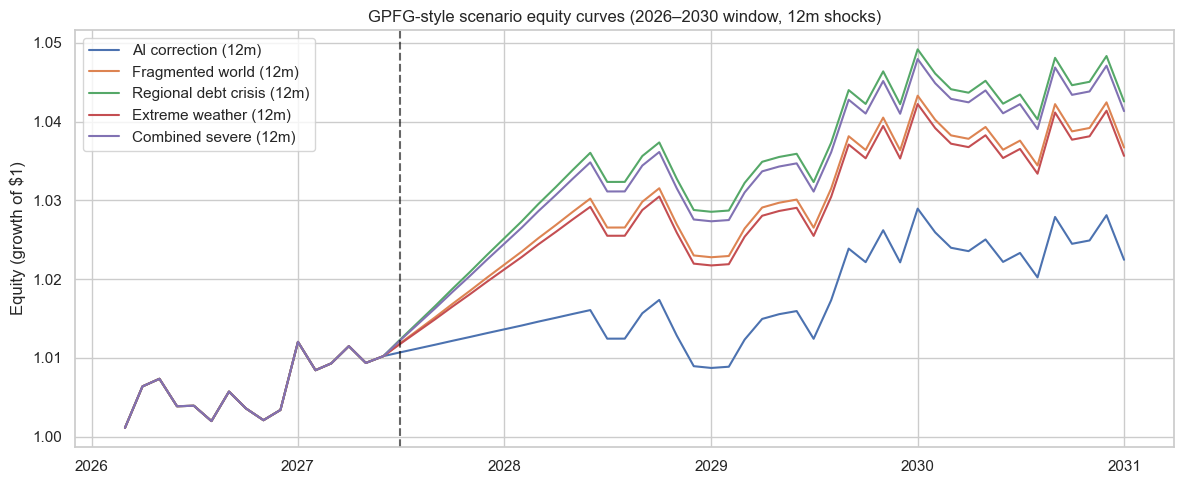

In [13]:
# ---------- Helpers ----------
def expected_shortfall(r: pd.Series, alpha: float = 0.95) -> float:
    r = pd.Series(r).dropna()
    if len(r) == 0:
        return np.nan
    q = r.quantile(1 - alpha)
    tail = r[r <= q]
    if len(tail) == 0:
        return float(q)
    return float(tail.mean())


# Baseline ES for the existing portfolio (daily returns)
hist_es = pd.DataFrame(
    {
        'metric': ['Portfolio ES (daily)'],
        'ES_95': [expected_shortfall(port, 0.95) if 'port' in globals() else np.nan],
        'ES_99': [expected_shortfall(port, 0.99) if 'port' in globals() else np.nan],
    }
)

display(hist_es.style.format({'ES_95': '{:.2%}', 'ES_99': '{:.2%}'}))


# ---------- GPFG-style factor shock scenarios (12-month shocks) ----------
# Shock magnitudes approximate GPFG table impacts (equities most negative in AI/fragmented; credit hit in fragmented/debt; mild positive credit in AI correction).
SCENARIO_SHOCKS = {
    'AI correction (12m)': {
        ai_bubble: -0.53,
        private_credit_bubble: 0.05,
        crypto_bubble: -0.25,
    },
    'Fragmented world (12m)': {
        ai_bubble: -0.49,
        private_credit_bubble: -0.15,
        crypto_bubble: -0.30,
    },
    'Regional debt crisis (12m)': {
        ai_bubble: -0.39,
        private_credit_bubble: -0.25,
        crypto_bubble: -0.10,
    },
    'Extreme weather (12m)': {
        ai_bubble: -0.24,
        private_credit_bubble: -0.10,
        crypto_bubble: -0.05,
    },
    'Combined severe (12m)': {
        ai_bubble: -0.55,
        private_credit_bubble: -0.25,
        crypto_bubble: -0.30,
    },
}


def build_custom_scenario(shocks: dict[str, float]) -> pd.DataFrame:
    df = base_factors.copy()
    seq_idx = pd.date_range(burst_start, periods=SHOCK_MONTHS, freq=MONTHLY_FREQ)
    for fac, val in shocks.items():
        if fac not in df.columns:
            continue
        # Interpret `val` as a 12-month total return and convert to a constant monthly path.
        monthly_val = (1.0 + float(val)) ** (1.0 / float(len(seq_idx))) - 1.0
        seq = pd.Series([monthly_val] * len(seq_idx), index=seq_idx)
        df = apply_shock(df, fac, seq, burst_start)
    return df


scenario_results: list[dict] = []
scenario_eq: dict[str, pd.Series] = {}

for scen_name, shocks in SCENARIO_SHOCKS.items():
    fx = build_custom_scenario(shocks)
    pr = predict_portfolio_monthly(fx)
    eq = (1 + pr).cumprod()
    scenario_eq[scen_name] = eq

    scenario_results.append(
        {
            'scenario': scen_name,
            'cum_return': float(eq.iloc[-1] - 1),
            'max_drawdown': summarize_path(pr)['max_drawdown'],
            'ES_95': expected_shortfall(pr, 0.95),
            'ES_99': expected_shortfall(pr, 0.99),
        }
    )


scenario_table = pd.DataFrame(scenario_results).set_index('scenario').sort_values('cum_return')

print('\nGPFG-style scenario results (12-month shocks on factors):')
display(
    scenario_table.style.format(
        {
            'cum_return': '{:.2%}',
            'max_drawdown': '{:.2%}',
            'ES_95': '{:.2%}',
            'ES_99': '{:.2%}',
        }
    )
)

# Dynamic interpretation (worst-case scenarios; updates with live Yahoo Finance pulls)
if 'explain' in globals():
    try:
        bullets = []
        st = scenario_table.copy()
        for col in ['cum_return', 'max_drawdown', 'ES_95', 'ES_99']:
            if col in st.columns:
                st[col] = pd.to_numeric(st[col], errors='coerce')

        cr = st['cum_return'].dropna() if 'cum_return' in st.columns else pd.Series(dtype=float)
        dd = st['max_drawdown'].dropna() if 'max_drawdown' in st.columns else pd.Series(dtype=float)
        es99 = st['ES_99'].dropna() if 'ES_99' in st.columns else pd.Series(dtype=float)

        if len(cr):
            worst_cr = cr.idxmin()
            best_cr = cr.idxmax()
            bullets.append(f'Worst cumulative return scenario: {worst_cr} ({float(cr.loc[worst_cr]):.2%})')
            bullets.append(f'Best cumulative return scenario: {best_cr} ({float(cr.loc[best_cr]):.2%})')

        if len(dd):
            worst_dd = dd.idxmin()
            bullets.append(f'Worst max drawdown scenario: {worst_dd} ({float(dd.loc[worst_dd]):.2%})')

        if len(es99):
            worst_es99 = es99.idxmin()
            bullets.append(f'Worst tail risk (ES_99): {worst_es99} ({float(es99.loc[worst_es99]):.2%})')

        if bullets:
            bullets.append('More negative ES/drawdown implies worse tail-loss risk under that narrative shock; if this is unacceptable, iterate the roster allocation (Section 5) and re-run.')
            explain('10B) GPFG-style scenarios: quick read', bullets)
    except Exception:
        pass


# Plot equity curves for the custom scenarios
plt.figure(figsize=(12, 5))
for name, eq in scenario_eq.items():
    plt.plot(eq.index, eq.values, label=name)
plt.axvline(burst_start, color='black', linestyle='--', alpha=0.6)
plt.title('GPFG-style scenario equity curves (2026–2030 window, 12m shocks)')
plt.ylabel('Equity (growth of $1)')
plt.legend()
plt.tight_layout()
plt.show()


## 11) Summary + knobs to tune

If you want to iterate quickly, the highest-leverage knobs are:
- `ROSTER_PATH` (your investable universe + positioning; edit the CSV to change symbols/weights/Long-Short/reasons)
- `BUBBLE_TICKERS` (your bubble factor tickers)
- `OPTIMIZATION_WINDOWS` and their exact dates
- `GROSS_EXPOSURE`, `MAX_ABS_WEIGHT`, `RANDOM_SEED`

If you update the roster CSV (tickers, Position, RiskLimitPercent, Rationale), the notebook will automatically pull fresh live Yahoo Finance data and re-run the full analysis pipeline.

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- If you want to improve resilience, the highest-leverage step is changing the roster CSV: **what you hold, long vs short, and sizing**.
- Use Section 4 to check diversification/hedging, Section 7 to validate crisis behavior, and Section 10 to validate forward-looking bubble-burst scenarios.
- Iterate: adjust roster → re-run → see if downside improves under the bubble stress cases.


## 12) AI, Private Credit, Crypto Bubble Detection Prototype & Early Warning System

This is a **prototype early-warning dashboard** intended for corporate / stakeholder impact: *spotting elevated bubble risk early so risk can be managed proactively*.

What this section does (live-data, no static datasets):
- Pulls **live market time-series** from Yahoo Finance via `yfinance` for representative tickers in each bubble domain.
- Computes **mathematical bubble indicators** (examples):
  - Price deviation from long-run trend (z-score)
  - Momentum / acceleration
  - Volatility clustering signals (short vol vs long vol)
  - Simple change-point flags
  - Hurst exponent (persistence vs mean reversion)
- Builds a **multi-signal composite bubble score** per domain, then fits a **2-regime Markov-switching model (HMM-like)** to estimate a **bubble-likelihood probability** (probability of being in the high-risk regime) over time.
- Pulls recent Yahoo Finance headlines (when available) and computes a lightweight **headline sentiment** score.

Outputs:
- A multi-domain **risk regime chart** over time
- A **current alert table** (Normal / Elevated / High) per domain
- A lightweight **historical validation table** (lead time + precision/recall) per domain
- A forward-looking **2026–2030 bubble-likelihood forecast** (prototype) + first projected threshold crossings

### Simple Explanation of the Codebase, Output, how it's supporting the goal of resilience vs the AI / Private Credit / Crypto bubbles
- This section does **not** change portfolio weights automatically. It provides **early-warning signals** so you (or stakeholders) can tighten risk limits, hedge, or reduce exposure **before** a bubble burst.
- If a domain’s bubble-likelihood stays high and rising, that’s a cue to revisit the roster (Section 1/5) and the scenario stress tests (Section 10).


In [14]:
# -----------------------------
# Section 12: Bubble Detection & Early Warning System (Prototype)
# -----------------------------

# NOTE: This is a prototype analytics tool. It uses live Yahoo Finance data via yfinance.
# Some optional data sources (e.g., deep social media sentiment) are not accessible without API keys;
# this section uses best-effort Yahoo headline data when available.

import numpy as np
import pandas as pd
import yfinance as yf


# -----------------------------
# 12.1 Domain configuration
# -----------------------------

# Representative tickers per domain (edit if you prefer alternatives)
DOMAIN_TICKERS = {
    # Use ONLY the symbols listed by the user (Yahoo Finance via yfinance, best-effort)
    'AI bubble': ['QQQ', 'ROBT', 'U8S1.SG', 'ESIFF', 'WTAI', 'NMX101010.FGI'],
    'Private Credit bubble': ['HYG', 'HYGU.L', 'HYIN', 'TAKMX', 'VPC'],
    'Crypto bubble': ['BTC-USD', '^SPCMCFUE'],
}

# Additional Yahoo-only leading indicators (macro + sector/style spreads)
# User constraint: bubble engine should only pull the user-specified indicator symbols.
# So we disable extra macro tickers here (DOMAIN_TICKERS already contains the allowed set).
MACRO_TICKERS: list[str] = []

# Pull prices live (Close). We reuse HIST_START from Section 2.
ALL_DETECT_TICKERS = sorted({t for ts in DOMAIN_TICKERS.values() for t in ts} | set(MACRO_TICKERS))

try:
    detect_prices
except NameError:
    detect_prices = pd.DataFrame()

if detect_prices is None or detect_prices.empty:
    detect_prices = download_close_prices(ALL_DETECT_TICKERS, start=HIST_START)

if detect_prices is None or detect_prices.empty:
    raise RuntimeError('[ews] No price data returned for detect tickers; rerun earlier sections or adjust DOMAIN_TICKERS.')

# Volume is useful as a market-activity / flow proxy. Fetch best-effort volume for any tickers that support it.
def download_volume(tickers: list[str], start: str) -> pd.DataFrame:
    tickers = list(dict.fromkeys(tickers))
    raw = yf.download(
        tickers,
        start=start,
        auto_adjust=True,
        progress=False,
        group_by='column',
        threads=True,
    )
    if raw is None or len(raw) == 0:
        return pd.DataFrame(columns=tickers)

    if isinstance(raw.columns, pd.MultiIndex):
        lvl0 = raw.columns.get_level_values(0)
        if 'Volume' in lvl0:
            vol = raw['Volume'].copy()
        else:
            vol = pd.DataFrame(index=pd.to_datetime(raw.index))
    else:
        if len(tickers) == 1 and ('Volume' in raw.columns):
            vol = raw[['Volume']].rename(columns={'Volume': tickers[0]}).copy()
        else:
            vol = pd.DataFrame(index=pd.to_datetime(raw.index))

    vol.index = pd.to_datetime(vol.index)
    vol = vol.sort_index().resample('B').last()

    # Ensure every requested ticker exists as a column (yfinance may omit Volume for some symbols)
    for t in tickers:
        if t not in vol.columns:
            vol[t] = np.nan

    vol = vol[tickers].fillna(0.0)
    return vol


if ('detect_vol' not in globals()) or detect_vol is None or detect_vol.empty:
    detect_vol = download_volume(ALL_DETECT_TICKERS, start=HIST_START)

detect_vol = detect_vol.reindex(detect_prices.index).fillna(0.0)


# -----------------------------
# 12.2 Indicator functions
# -----------------------------

ZSCORE_WINDOW = 252 * 5  # ~5y rolling window; avoids full-sample lookahead bias


def zscore(s: pd.Series, window: int = ZSCORE_WINDOW) -> pd.Series:
    s = s.astype(float)
    if window and window > 3:
        minp = max(30, int(window * 0.25))
        mu = s.rolling(window, min_periods=minp).mean()
        sd = s.rolling(window, min_periods=minp).std()
        z = (s - mu) / sd
        return z.replace([np.inf, -np.inf], np.nan)

    mu = float(s.mean())
    sd = float(s.std())
    if not np.isfinite(sd) or sd == 0:
        return s * 0.0
    return (s - mu) / sd


def hurst_exponent(x: np.ndarray) -> float:
    # Simple R/S estimate on log-price level (prototype).
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) < 100:
        return np.nan
    y = np.log(x)
    y = y - y.mean()
    z = np.cumsum(y)
    r = np.max(z) - np.min(z)
    s = np.std(y)
    if s == 0:
        return np.nan
    return float(np.log(r / s) / np.log(len(y)))


def rolling_hurst(price: pd.Series, window: int = 252, step: int = 21) -> pd.Series:
    # Compute Hurst on a monthly-ish grid (every ~21 business days), then forward-fill.
    price = price.dropna()
    if len(price) < window:
        return pd.Series(index=price.index, dtype=float)
    out = []
    for i in range(window, len(price) + 1, step):
        sub = price.iloc[i - window : i]
        out.append((sub.index[-1], hurst_exponent(sub.values)))
    s = pd.Series({k: v for k, v in out}).sort_index()
    return s.reindex(price.index).ffill()


def change_point_flag(x: pd.Series, short: int = 21, long: int = 252, z_thresh: float = 3.0) -> pd.Series:
    # Prototype change-point signal: z-score of short-mean vs long-mean.
    x = x.astype(float)
    mu_s = x.rolling(short).mean()
    mu_l = x.rolling(long).mean()
    sd_l = x.rolling(long).std()
    z = (mu_s - mu_l) / sd_l
    return (z.abs() > z_thresh).fillna(False)


def compute_indicators(price: pd.Series, volume: pd.Series | None = None) -> pd.DataFrame:
    price = price.dropna()
    r = price.pct_change()

    ma_long = price.rolling(252).mean()
    sd_long = price.rolling(252).std()
    z_price = (price - ma_long) / sd_long

    mom_1m = price.pct_change(21)
    mom_3m = price.pct_change(63)
    accel_1m = mom_1m - mom_3m

    vol_1m = r.rolling(21).std()
    vol_6m = r.rolling(126).std()
    vol_ratio = vol_1m / vol_6m

    dd_1y = price / price.rolling(252).max() - 1.0

    h = rolling_hurst(price)
    cp = change_point_flag(r)

    out = pd.DataFrame(
        {
            'z_price': z_price,
            'mom_1m': mom_1m,
            'mom_3m': mom_3m,
            'accel_1m': accel_1m,
            'vol_ratio': vol_ratio,
            'drawdown_1y': dd_1y,
            'hurst': h,
            'change_point': cp.astype(float),
        }
    )

    if volume is not None:
        v = volume.reindex(price.index).astype(float).fillna(0.0)
        out['z_volume'] = zscore(v)

        # Flow/activity proxies (NOT true ETF fund flows): signed-volume and OBV-style measures.
        signed = np.sign(r.fillna(0.0))
        signed_vol = signed * v
        denom = (v.rolling(21).sum() + 1e-12)
        out['flow_1m'] = (signed_vol.rolling(21).sum() / denom).clip(-1.0, 1.0)
        obv = signed_vol.cumsum()
        out['obv_1m'] = obv.diff(21)

    return out


# -----------------------------
# 12.2b Macro / cross-domain leading indicators (yfinance-only proxies)
# -----------------------------


def build_macro_features(prices: pd.DataFrame) -> pd.DataFrame:
    idx = prices.index
    macro = pd.DataFrame(index=idx)

    # Volatility proxy (VIX level)
    if '^VIX' in prices.columns:
        macro['vix_z'] = zscore(prices['^VIX'].astype(float))

    # Yield curve slope proxies (Yahoo rate indexes)
    if ('^TNX' in prices.columns) and ('^IRX' in prices.columns):
        slope_10_3 = prices['^TNX'].astype(float) - prices['^IRX'].astype(float)
        macro['yc_slope_z'] = zscore(slope_10_3)  # 10Y-3M
    if ('^FVX' in prices.columns) and ('^IRX' in prices.columns):
        slope_5_3 = prices['^FVX'].astype(float) - prices['^IRX'].astype(float)
        macro['yc_slope_5_3_z'] = zscore(slope_5_3)  # 5Y-3M
    if ('^TYX' in prices.columns) and ('^IRX' in prices.columns):
        slope_30_3 = prices['^TYX'].astype(float) - prices['^IRX'].astype(float)
        macro['yc_slope_30_3_z'] = zscore(slope_30_3)  # 30Y-3M
    if ('^TYX' in prices.columns) and ('^TNX' in prices.columns):
        slope_30_10 = prices['^TYX'].astype(float) - prices['^TNX'].astype(float)
        macro['yc_slope_30_10_z'] = zscore(slope_30_10)  # 30Y-10Y

    # Credit risk proxy: HY vs IG (price ratio)
    if ('HYG' in prices.columns) and ('LQD' in prices.columns):
        ratio = (prices['HYG'].astype(float) / prices['LQD'].astype(float)).replace(0, np.nan)
        macro['credit_ratio_z'] = zscore(np.log(ratio))

    # Risk-on/off equity proxies
    def _log_ratio(a: str, b: str, name: str):
        if (a in prices.columns) and (b in prices.columns):
            r = (prices[a].astype(float) / prices[b].astype(float)).replace(0, np.nan)
            macro[name] = zscore(np.log(r))

    _log_ratio('XLY', 'XLP', 'xly_xlp_z')   # consumer disc vs staples
    _log_ratio('XLY', 'XLU', 'xly_xlu_z')   # disc vs utilities
    _log_ratio('XLK', 'XLU', 'xlk_xlu_z')   # tech vs utilities
    _log_ratio('IWM', 'SPY', 'iwm_spy_z')   # small vs large
    _log_ratio('ARKK', 'SPY', 'arkk_spy_z') # high beta/innovation vs broad mkt
    _log_ratio('SOXX', 'SPY', 'soxx_spy_z') # semis vs broad mkt
    _log_ratio('QQQ', 'SPY', 'qqq_spy_z')   # growth vs broad mkt

    # Duration / real-yield proxy (TIP vs IEF)
    _log_ratio('TIP', 'IEF', 'tip_ief_z')

    return macro


MACRO = build_macro_features(detect_prices)


# -----------------------------
# 12.3 1D Gaussian Mixture (2 components) via EM
# -----------------------------

def fit_gmm_1d(x: np.ndarray, n_iter: int = 50) -> dict:
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) < 50:
        return {'ok': False}

    # Init
    mu1, mu2 = np.percentile(x, [30, 70])
    s1 = float(np.std(x)) if float(np.std(x)) > 1e-8 else 1.0
    s2 = s1
    w1 = 0.5
    w2 = 0.5

    def normpdf(xx, mu, sig):
        sig = max(float(sig), 1e-6)
        return np.exp(-0.5 * ((xx - mu) / sig) ** 2) / (sig * np.sqrt(2 * np.pi))

    for _ in range(n_iter):
        p1 = w1 * normpdf(x, mu1, s1)
        p2 = w2 * normpdf(x, mu2, s2)
        denom = p1 + p2
        denom = np.where(denom == 0, 1e-12, denom)
        g1 = p1 / denom
        g2 = 1.0 - g1

        w1 = float(np.mean(g1))
        w2 = 1.0 - w1
        mu1 = float(np.sum(g1 * x) / np.sum(g1))
        mu2 = float(np.sum(g2 * x) / np.sum(g2))
        s1 = float(np.sqrt(np.sum(g1 * (x - mu1) ** 2) / np.sum(g1)))
        s2 = float(np.sqrt(np.sum(g2 * (x - mu2) ** 2) / np.sum(g2)))

    # Ensure component 2 is the "higher mean" component
    if mu1 > mu2:
        mu1, mu2 = mu2, mu1
        s1, s2 = s2, s1
        w1, w2 = w2, w1

    return {'ok': True, 'mu_low': mu1, 'mu_high': mu2, 'sig_low': s1, 'sig_high': s2, 'w_low': w1, 'w_high': w2}


def gmm_high_posterior(x: np.ndarray, params: dict) -> np.ndarray:
    x = np.asarray(x, dtype=float)

    def normpdf(xx, mu, sig):
        sig = max(float(sig), 1e-6)
        return np.exp(-0.5 * ((xx - mu) / sig) ** 2) / (sig * np.sqrt(2 * np.pi))

    p_low = params['w_low'] * normpdf(x, params['mu_low'], params['sig_low'])
    p_high = params['w_high'] * normpdf(x, params['mu_high'], params['sig_high'])
    denom = p_low + p_high
    denom = np.where(denom == 0, 1e-12, denom)
    return p_high / denom


# -----------------------------
# 12.4 Per-domain composite score + bubble likelihood
# -----------------------------

def domain_composite_score(domain: str, tickers: list[str]) -> pd.Series:
    frames = []
    for t in tickers:
        p = detect_prices[t] if t in detect_prices.columns else pd.Series(dtype=float)
        v = detect_vol[t] if ('detect_vol' in globals() and t in detect_vol.columns) else None
        ind = compute_indicators(p.dropna(), volume=v)
        if ind.empty:
            continue

        # Normalize indicators into z-scores for combination
        # Note: drawdown is negative in drawdowns; for "bubble" (late-cycle) we focus on price stretch + momentum + vol.
        z = pd.DataFrame(index=ind.index)
        z['z_price'] = zscore(ind['z_price'].dropna()).reindex(ind.index)
        z['mom_1m'] = zscore(ind['mom_1m'].dropna()).reindex(ind.index)
        z['mom_3m'] = zscore(ind['mom_3m'].dropna()).reindex(ind.index)
        z['accel_1m'] = zscore(ind['accel_1m'].dropna()).reindex(ind.index)
        z['vol_ratio'] = zscore(ind['vol_ratio'].dropna()).reindex(ind.index)
        z['hurst'] = zscore(ind['hurst'].dropna()).reindex(ind.index)
        z['cp'] = ind['change_point']
        if 'z_volume' in ind.columns:
            z['z_volume'] = zscore(ind['z_volume'].dropna()).reindex(ind.index)
        if 'flow_1m' in ind.columns:
            z['flow_1m'] = zscore(ind['flow_1m'].dropna()).reindex(ind.index)
        if 'obv_1m' in ind.columns:
            z['obv_1m'] = zscore(ind['obv_1m'].dropna()).reindex(ind.index)

        frames.append(z)

    if not frames:
        return pd.Series(dtype=float)

    # pandas>=3 removed DataFrame.groupby(axis=...). To average across the column MultiIndex
    # (tickers x features), transpose -> groupby on index level -> transpose back.
    tmp = pd.concat(frames, axis=1, keys=range(len(frames)))
    Z = tmp.T.groupby(level=1).mean().T

    # Join macro features (same for all domains; yfinance-only proxies)
    if 'MACRO' in globals() and isinstance(MACRO, pd.DataFrame) and (not MACRO.empty):
        Z = Z.join(MACRO.reindex(Z.index), how='left')

    # Weighted composite (multi-signal fusion; adjust weights as desired)
    w = {
        'z_price': 0.22,
        'mom_1m': 0.10,
        'mom_3m': 0.18,
        'accel_1m': 0.10,
        'vol_ratio': 0.12,
        'hurst': 0.08,
        'cp': 0.05,
        'flow_1m': 0.07,
        'obv_1m': 0.05,
        'z_volume': 0.05,

        # Macro proxies (signs matter)
        'vix_z': 0.04,
        'yc_slope_z': -0.04,          # inversion/flattening => higher risk
        'yc_slope_5_3_z': -0.02,
        'yc_slope_30_3_z': -0.02,
        'credit_ratio_z': -0.04,      # HY underperforming IG => higher risk

        # Sector / style spreads (risk appetite)
        'xly_xlp_z': 0.03,
        'xly_xlu_z': 0.02,
        'xlk_xlu_z': 0.02,
        'iwm_spy_z': 0.02,
        'arkk_spy_z': 0.03,
        'soxx_spy_z': 0.03,
        'qqq_spy_z': 0.02,

        # Inflation expectations proxy
        'tip_ief_z': 0.01,
    }

    score = pd.Series(0.0, index=Z.index)
    for k, wk in w.items():
        if k in Z.columns:
            score = score.add(wk * Z[k].fillna(0.0), fill_value=0.0)

    return score.rename(f'{domain}__score')


def markov_bubble_probability(score: pd.Series, k_regimes: int = 3) -> pd.Series:
    # Regime model (HMM-like): Markov switching regression on the composite score.
    # For k=3, we map (low, mid, high) regimes into a 0..100 bubble-likelihood:
    #   p = 100 * (0.5 * P(mid) + 1.0 * P(high))
    # This tends to rise earlier than a pure P(high) while staying conservative.
    y = score.replace([np.inf, -np.inf], np.nan).dropna().astype(float)
    if len(y) < 450:
        return pd.Series(index=score.index, dtype=float)

    # Standardize for numerical stability
    y_std = zscore(y).dropna()
    if len(y_std) < 350:
        return pd.Series(index=score.index, dtype=float)

    def _fit(k: int) -> pd.Series | None:
        try:
            mod = MarkovRegression(y_std, k_regimes=int(k), trend='c', switching_variance=True)
            res = mod.fit(disp=False)
        except Exception:
            return None

        probs = res.smoothed_marginal_probabilities
        if not isinstance(probs, pd.DataFrame):
            probs = pd.DataFrame(probs, index=y_std.index)

        yv = y_std.to_numpy(dtype=float)
        means = {}
        for col in probs.columns:
            w = probs[col].to_numpy(dtype=float)
            denom = float(np.nansum(w))
            means[col] = float(np.nansum(w * yv) / denom) if denom > 0 else -np.inf

        ordered = sorted(means, key=means.get)
        if len(ordered) < 2:
            return None

        if int(k) == 2:
            high = ordered[-1]
            p = probs[high] * 100.0
        else:
            mid = ordered[1] if len(ordered) >= 3 else ordered[1]
            high = ordered[-1]
            p = (0.5 * probs[mid] + 1.0 * probs[high]) * 100.0

        return p.rename('bubble_likelihood')

    out = _fit(int(k_regimes))
    if out is None and int(k_regimes) != 2:
        out = _fit(2)
    if out is None:
        return pd.Series(index=score.index, dtype=float)

    return out.reindex(score.index)


def logistic_bubble_probability(score: pd.Series) -> pd.Series:
    # Conservative mapping from composite score -> probability-like risk (%)
    # Uses a rolling z-score then a logistic transform to avoid saturated 0/100 outputs.
    y = score.replace([np.inf, -np.inf], np.nan).astype(float)
    if len(y.dropna()) < 60:
        return pd.Series(index=score.index, dtype=float)

    w = 252 * 5
    minp = int(min(w, max(252, int(w * 0.6))))

    mu = y.rolling(w, min_periods=minp).mean()
    sd = y.rolling(w, min_periods=minp).std().replace(0.0, np.nan)
    z = (y - mu) / sd

    # Warmup: expanding stats to avoid all-NaN early on
    mu2 = y.expanding(min_periods=60).mean()
    sd2 = y.expanding(min_periods=60).std().replace(0.0, np.nan)
    z2 = (y - mu2) / sd2
    z = z.fillna(z2)

    # Bubble-zone center ~ +1σ, slope controls how quickly we move toward extremes
    z0 = 1.0
    k = 1.2
    p = 100.0 / (1.0 + np.exp(-float(k) * (z - float(z0))))
    return p.rename('bubble_likelihood')


MARKOV_BLEND_WEIGHT = 0.35


domain_scores = {}
domain_probs = {}

for domain, tickers in DOMAIN_TICKERS.items():
    s = domain_composite_score(domain, tickers)
    if s.empty:
        continue

    # Blend (markov captures regime shifts; logistic-z mapping avoids saturated 0/100 outputs)
    p_markov = markov_bubble_probability(s)
    p_log = logistic_bubble_probability(s)

    if (not p_markov.dropna().empty) and (not p_log.dropna().empty):
        w = float(MARKOV_BLEND_WEIGHT)
        p = (w * p_markov + (1.0 - w) * p_log).where(p_markov.notna(), p_log)
    else:
        p = p_log if not p_log.dropna().empty else p_markov

    # Final fallback: simple 2-component 1D GMM
    if p.dropna().empty:
        params = fit_gmm_1d(s.to_numpy(), n_iter=60)
        if not params.get('ok'):
            continue
        post = gmm_high_posterior(s.to_numpy(), params)
        p = pd.Series(post * 100.0, index=s.index)

    # Light smoothing (reduces day-to-day jitter)
    p = p.clip(lower=0.0, upper=100.0).ewm(span=5, adjust=False).mean()

    p = p.rename(f'{domain}__bubble_likelihood')
    domain_scores[domain] = s
    domain_probs[domain] = p


# Combine into a single dashboard table
prob_df = pd.DataFrame(domain_probs).dropna(how='all')
score_df = pd.DataFrame(domain_scores).dropna(how='all')

if prob_df.empty:
    raise RuntimeError('Bubble detection: no domain probabilities could be computed. Check tickers/data availability.')


# -----------------------------
# 12.5 News & sentiment (Alpha Vantage preferred; Yahoo fallback)
# -----------------------------

import os
import json
import time
import hashlib
import requests

POS_WORDS = {
    'soars', 'surges', 'record', 'rally', 'bull', 'breakout', 'boom', 'explodes', 'beats', 'strong', 'upgrade'
}
NEG_WORDS = {
    'crash', 'plunge', 'fraud', 'lawsuit', 'hack', 'collapse', 'bubble', 'downgrade', 'selloff', 'risk', 'panic'
}

def headline_sentiment(title: str) -> float:
    words = [w.strip(".,:;!?()[]{}\\\"' ").lower() for w in title.split()]
    if not words:
        return 0.0
    pos = sum(1 for w in words if w in POS_WORDS)
    neg = sum(1 for w in words if w in NEG_WORDS)
    return float((pos - neg) / max(len(words), 1))


def fetch_headlines(ticker: str, limit: int = 25) -> pd.DataFrame:
    try:
        items = yf.Ticker(ticker).news or []
    except Exception:
        items = []

    rows = []
    for it in items[:limit]:
        title = it.get('title', '')
        ts = it.get('providerPublishTime', None)
        dt = pd.to_datetime(ts, unit='s', utc=True, errors='coerce') if ts is not None else pd.NaT
        if not title:
            continue
        rows.append({'ticker': ticker, 'time': dt, 'title': title, 'sentiment': headline_sentiment(title)})

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('time', ascending=False)
    return df


SENTIMENT_TICKERS = {
    'Crypto bubble': 'BTC-USD',
    'AI bubble': 'QQQ',
    'Private Credit bubble': 'HYG',
}

# Skip headline pulls by default (keeps Section 12 output clean + avoids flaky Yahoo news availability)
def _cache_load(path: str) -> dict:
    try:
        if os.path.exists(path):
            with open(path, 'r', encoding='utf-8') as f:
                obj = json.load(f)
                return obj if isinstance(obj, dict) else {}
    except Exception:
        pass
    return {}


def _cache_save(path: str, cache: dict) -> None:
    try:
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(cache, f, ensure_ascii=False, indent=2)
    except Exception:
        pass


def _cache_key(params: dict) -> str:
    # Do NOT include the API key in the cache key.
    safe = {k: v for k, v in params.items() if k != 'apikey'}
    raw = json.dumps(safe, sort_keys=True, ensure_ascii=False)
    return hashlib.sha1(raw.encode('utf-8')).hexdigest()


def fetch_alpha_vantage_news(params: dict, cache_path: str, ttl_s: int) -> dict:
    # Returns parsed JSON dict; may include 'error' key.
    ck = _cache_key(params)
    cache = _cache_load(cache_path)
    now = int(time.time())
    if ck in cache:
        ent = cache.get(ck) or {}
        ts = int(ent.get('ts', 0) or 0)
        if (now - ts) <= int(ttl_s) and isinstance(ent.get('data'), dict):
            return ent['data']

    url = 'https://www.alphavantage.co/query'
    try:
        r = requests.get(url, params=params, timeout=25)
        data = r.json() if r is not None else {}
    except Exception as e:
        return {'error': f'request_failed: {str(e)[:160]}'}

    # Rate limit / error surfaces
    if isinstance(data, dict):
        if data.get('Error Message'):
            return {'error': str(data.get('Error Message'))[:200]}
        if data.get('Note'):
            return {'error': str(data.get('Note'))[:200]}
        if data.get('Information'):
            return {'error': str(data.get('Information'))[:200]}

    # Save to cache (best-effort)
    try:
        cache[ck] = {'ts': now, 'data': data}
        _cache_save(cache_path, cache)
    except Exception:
        pass

    return data if isinstance(data, dict) else {'error': 'invalid_response'}


def _av_time_from(hours_back: int) -> str:
    # Format: YYYYMMDDTHHMM (UTC)
    try:
        # Round "now" to the hour so reruns within the cache TTL reuse the same cache key.
        now = pd.Timestamp.utcnow().floor('1H')
        dt = now - pd.Timedelta(hours=int(hours_back))
        return dt.strftime('%Y%m%dT%H%M')
    except Exception:
        return ''


def _news_metrics_from_feed(feed: list) -> dict:
    # Produce compact numeric features + a few headline strings.
    rows = []
    for it in feed or []:
        if not isinstance(it, dict):
            continue
        title = str(it.get('title', '') or '')
        score = it.get('overall_sentiment_score', None)
        try:
            score = float(score)
        except Exception:
            score = np.nan
        tpub = str(it.get('time_published', '') or '')
        rows.append({'title': title, 'score': score, 'time_published': tpub})

    if not rows:
        return {
            'articles_24h': 0,
            'sentiment_mean': np.nan,
            'neg_share': np.nan,
            'heat_0_100': 0.0,
            'top_titles': [],
        }

    df = pd.DataFrame(rows)
    s = pd.to_numeric(df['score'], errors='coerce')
    mean = float(s.mean()) if s.notna().any() else np.nan
    neg = float((s < -0.10).mean()) if s.notna().any() else np.nan
    n = int(len(df))

    # Saturating heat score: 0 at 0 articles, ~63 at 20, ~86 at 40, → 100 as n grows.
    heat = float(100.0 * (1.0 - np.exp(-n / 20.0)))

    top = [t for t in df['title'].tolist() if isinstance(t, str) and t.strip()]
    top = [t.strip()[:140] for t in top[:3]]

    return {
        'articles_24h': n,
        'sentiment_mean': mean,
        'neg_share': neg,
        'heat_0_100': heat,
        'top_titles': top,
    }


# Build per-domain news table (Alpha Vantage preferred). We keep Yahoo headline sentiment as a fallback.
news_table = pd.DataFrame([])

if RUN_SENTIMENT:
    def _read_alpha_key_from_file(path: str) -> str:
        # Optional local fallback for environments where env vars don't propagate into the kernel.
        # Expected format: first non-empty, non-comment line is the key.
        try:
            if path and os.path.exists(path):
                with open(path, 'r', encoding='utf-8') as f:
                    for line in (f.read() or '').splitlines():
                        s = (line or '').strip()
                        if s and (not s.startswith('#')):
                            return s
        except Exception:
            pass
        return ''

    api_key = os.getenv('ALPHAVANTAGE_API_KEY', '').strip()
    api_key_source = 'env' if api_key else 'missing'
    key_path = ''
    if not api_key:
        key_path = os.getenv('ALPHAVANTAGE_API_KEY_FILE', '').strip()
        if not key_path:
            key_path = '.alphavantage_api_key.txt'
            if not os.path.exists(key_path):
                alt = 'alphavantage_api_key.txt'
                if os.path.exists(alt):
                    key_path = alt
        api_key = _read_alpha_key_from_file(key_path).strip()
        if api_key:
            api_key_source = f'file:{key_path}'

    if api_key_source.startswith('file:'):
        print(f"[news] Alpha Vantage API key loaded from local file fallback: {key_path}")
    cache_path = os.getenv('ALPHAVANTAGE_NEWS_CACHE_PATH', '.alphavantage_news_cache.json').strip() or '.alphavantage_news_cache.json'
    cache_minutes = int(os.getenv('ALPHAVANTAGE_NEWS_CACHE_MINUTES', '30') or 30)
    ttl_s = int(max(60, cache_minutes * 60))
    lookback_h = int(os.getenv('ALPHAVANTAGE_NEWS_LOOKBACK_HOURS', '24') or 24)
    limit = int(os.getenv('ALPHAVANTAGE_NEWS_LIMIT', '50') or 50)

    # Domain-specific query hints (tickers + topics) to keep calls stable.
    # Note: Alpha Vantage supports special prefixes like CRYPTO:BTC.
    domain_queries = {
        'AI bubble': {
            'tickers': 'QQQ,ROBT,WTAI',
            'topics': 'technology',
        },
        'Private Credit bubble': {
            'tickers': 'HYG,VPC',
            'topics': 'financial_markets,finance',
        },
        'Crypto bubble': {
            'tickers': 'CRYPTO:BTC',
            'topics': 'blockchain',
        },
    }

    av_rows = []
    if not api_key:
        print('[news] Alpha Vantage API key not set. Set env var ALPHAVANTAGE_API_KEY (or create .alphavantage_api_key.txt / alphavantage_api_key.txt, or set ALPHAVANTAGE_API_KEY_FILE) to enable live market news & sentiment.')
        for domain in domain_queries.keys():
            av_rows.append(
                {
                    'domain': domain,
                    'news_articles_24h': 0,
                    'news_sentiment_mean': np.nan,
                    'news_neg_share': np.nan,
                    'news_heat_0_100': 0.0,
                    'news_top_titles': [],
                    'news_error': 'missing_api_key',
                }
            )
    else:
        for domain, q in domain_queries.items():
            params = {
                'function': 'NEWS_SENTIMENT',
                'tickers': q.get('tickers', ''),
                'topics': q.get('topics', ''),
                'time_from': _av_time_from(lookback_h),
                'sort': 'LATEST',
                'limit': str(limit),
                'apikey': api_key,
            }

            data = fetch_alpha_vantage_news(params, cache_path=cache_path, ttl_s=ttl_s)
            feed = data.get('feed', []) if isinstance(data, dict) else []
            m = _news_metrics_from_feed(feed if isinstance(feed, list) else [])
            av_rows.append(
                {
                    'domain': domain,
                    'news_articles_24h': int(m['articles_24h']),
                    'news_sentiment_mean': float(m['sentiment_mean']) if np.isfinite(m['sentiment_mean']) else np.nan,
                    'news_neg_share': float(m['neg_share']) if np.isfinite(m['neg_share']) else np.nan,
                    'news_heat_0_100': float(m['heat_0_100']),
                    'news_top_titles': m['top_titles'],
                    'news_error': str(data.get('error', ''))[:200] if isinstance(data, dict) else 'invalid_response',
                }
            )

    news_table = pd.DataFrame(av_rows)
    if (not news_table.empty) and ('domain' in news_table.columns):
        news_table = news_table.set_index('domain')


# Yahoo headline sentiment fallback (best-effort)
# - By default we aggregate across *all* domain tickers to avoid "0 headlines" when a single symbol has no items.
use_yahoo = bool(globals().get('RUN_YAHOO_HEADLINES', True))
use_all_tickers = bool(globals().get('YAHOO_HEADLINES_USE_ALL_DOMAIN_TICKERS', True))

limit_per_ticker = int(globals().get('YAHOO_NEWS_LIMIT_PER_TICKER', 10) or 10)
try:
    limit_per_ticker = int(os.getenv('YAHOO_NEWS_LIMIT_PER_TICKER', str(limit_per_ticker)) or limit_per_ticker)
except Exception:
    pass

if not use_yahoo:
    yahoo_by_domain = {}
else:
    if use_all_tickers and isinstance(globals().get('DOMAIN_TICKERS', None), dict) and bool(DOMAIN_TICKERS):
        yahoo_by_domain = {k: list(v) for k, v in DOMAIN_TICKERS.items()}
    else:
        yahoo_by_domain = {k: [v] for k, v in (SENTIMENT_TICKERS or {}).items()}

sent_rows = []
for domain, tickers in yahoo_by_domain.items():
    t_list = [t for t in (tickers or []) if isinstance(t, str) and t.strip()]
    dfs = []
    for t in t_list:
        df = fetch_headlines(t, limit=limit_per_ticker)
        if df is not None and (not df.empty):
            dfs.append(df)

    if dfs:
        all_df = pd.concat(dfs, ignore_index=True)
        # Deduplicate headlines that appear across multiple tickers
        try:
            all_df = all_df.dropna(subset=['title'])
            all_df = all_df.drop_duplicates(subset=['title'])
        except Exception:
            pass

        mean_sent = float(all_df['sentiment'].mean()) if all_df.get('sentiment') is not None and all_df['sentiment'].notna().any() else np.nan
        n = int(len(all_df))
    else:
        mean_sent = np.nan
        n = 0

    sent_rows.append(
        {
            'domain': domain,
            'tickers': ','.join(t_list),
            'headline_sentiment_mean': mean_sent,
            'headlines': int(n),
        }
    )

sent_table = pd.DataFrame(sent_rows)
if (not sent_table.empty) and ('domain' in sent_table.columns):
    sent_table = sent_table.set_index('domain')
if use_yahoo and (not SHOW_ONLY_SIMPLE_EWS_TABLE) and (not sent_table.empty):
    display(sent_table)


# -----------------------------
# 12.6 Risk regimes + alerts
# -----------------------------

# We derive Normal/Elevated/High from historical percentiles per domain so thresholds adapt
# to each domain’s own history ("historical thresholds").
domain_thresholds = {}

# Dynamic threshold calibration (institutional-style): default to rolling quantiles.
THRESH_METHOD = 'rolling'          # 'rolling' or 'full_history'
THRESH_WINDOW_DAYS = 252 * 5       # ~5y
THRESH_ELEV_Q = 0.80
THRESH_HIGH_Q = 0.95

# Hoeffding-bound drift early-warning (no new tickers; operates on the probability series itself)
HOEFFDING_ALPHA = 0.01
HOEFFDING_RECENT_DAYS = 21         # ~1 trading month
HOEFFDING_BASELINE_DAYS = 252 * 3  # ~3y baseline (excluding recent window)


def _hoeffding_drift(series: pd.Series):
    s = series.dropna().astype(float)
    if len(s) < (int(HOEFFDING_RECENT_DAYS) + 60):
        return False, np.nan

    recent = s.tail(int(HOEFFDING_RECENT_DAYS))
    baseline = s.iloc[: -int(HOEFFDING_RECENT_DAYS)].tail(int(HOEFFDING_BASELINE_DAYS))
    if baseline.empty or len(recent) < max(10, int(HOEFFDING_RECENT_DAYS * 0.6)):
        return False, np.nan

    # Work in 0..1 range
    mu1 = float(recent.mean()) / 100.0
    mu0 = float(baseline.mean()) / 100.0
    n = float(len(recent))
    eps = float(np.sqrt(np.log(1.0 / float(HOEFFDING_ALPHA)) / (2.0 * n))) if n > 0 else np.nan
    drift = float(mu1 - mu0) if (np.isfinite(mu1) and np.isfinite(mu0)) else np.nan
    score = float(drift / eps) if (np.isfinite(drift) and np.isfinite(eps) and eps > 0) else np.nan
    flag = bool(np.isfinite(drift) and np.isfinite(eps) and (drift > eps))
    return flag, score


def _quantile_threshold(series: pd.Series, q: float) -> float:
    s = series.dropna().astype(float)
    if len(s) < 60:
        return np.nan

    if THRESH_METHOD == 'rolling':
        w = int(THRESH_WINDOW_DAYS)
        minp = int(min(w, max(252, int(w * 0.6))))
        rq = s.rolling(w, min_periods=minp).quantile(float(q))
        if rq.notna().any():
            v = float(rq.iloc[-1])
            if np.isfinite(v):
                return float(v)

    return float(np.percentile(s.to_numpy(), float(q) * 100.0))

alert_rows = []
for domain in prob_df.columns:
    series = prob_df[domain].dropna()
    cur = float(series.iloc[-1])
    thr_elev = _quantile_threshold(series, THRESH_ELEV_Q)
    thr_high = _quantile_threshold(series, THRESH_HIGH_Q)

    # Use EWMA slope for smoother early-warning (less noisy than raw diffs)
    if len(series) >= 60:
        ew = series.ewm(span=30, adjust=False).mean()
        slope = float(ew.diff().tail(30).mean())
    else:
        slope = float(series.diff().mean())

    if not np.isfinite(cur):
        status = 'Unknown'
    elif cur >= thr_high:
        status = 'High'
    elif cur >= thr_elev:
        status = 'Elevated'
    else:
        status = 'Normal'

    hoeff_flag, hoeff_score = _hoeffding_drift(series)

    early_warning = bool((cur >= thr_elev) and (slope > 0)) or bool(hoeff_flag)
    domain_thresholds[domain] = {'elev': thr_elev, 'high': thr_high, 'method': THRESH_METHOD}

    alert_rows.append(
        {
            'domain': domain,
            'asof': series.index[-1],
            'bubble_likelihood_now': cur,
            'hist_elev_threshold': thr_elev,
            'hist_high_threshold': thr_high,
            'recent_slope': slope,
            'risk_regime': status,
            'early_warning_flag': bool(early_warning),
            'hoeffding_drift_flag': bool(hoeff_flag),
            'hoeffding_drift_score': float(hoeff_score) if np.isfinite(hoeff_score) else np.nan,
        }
    )

alerts = pd.DataFrame(alert_rows).set_index('domain').sort_index()

# Merge news signals into alerts (so downstream sections can use them)
# - Alpha Vantage: news_heat_0_100 + news_sentiment_mean
# - Yahoo headlines: headline_sentiment_mean + headlines
if ('news_table' in globals()) and isinstance(news_table, pd.DataFrame) and (not news_table.empty):
    try:
        alerts['news_heat_0_100'] = pd.to_numeric(news_table.get('news_heat_0_100'), errors='coerce').reindex(alerts.index)
    except Exception:
        alerts['news_heat_0_100'] = np.nan
    try:
        alerts['news_sentiment_mean'] = pd.to_numeric(news_table.get('news_sentiment_mean'), errors='coerce').reindex(alerts.index)
    except Exception:
        alerts['news_sentiment_mean'] = np.nan
else:
    alerts['news_heat_0_100'] = np.nan
    alerts['news_sentiment_mean'] = np.nan

if ('sent_table' in globals()) and isinstance(sent_table, pd.DataFrame) and (not sent_table.empty):
    try:
        alerts['headline_sentiment_mean'] = pd.to_numeric(sent_table.get('headline_sentiment_mean'), errors='coerce').reindex(alerts.index)
    except Exception:
        alerts['headline_sentiment_mean'] = np.nan
    try:
        alerts['headlines'] = pd.to_numeric(sent_table.get('headlines'), errors='coerce').reindex(alerts.index)
    except Exception:
        alerts['headlines'] = np.nan
else:
    alerts['headline_sentiment_mean'] = np.nan
    alerts['headlines'] = np.nan


def _news_nudge_buckets(row: pd.Series) -> int:
    # Return +0 or +1 bucket nudge when news is extremely hot and very negative.
    # This is an additive adjustment on top of the Yahoo-price-driven probability + 30D change.

    heat = row.get('news_heat_0_100', np.nan)
    nsent = row.get('news_sentiment_mean', np.nan)
    ysent = row.get('headline_sentiment_mean', np.nan)
    ycnt = row.get('headlines', np.nan)

    nudge = 0
    # Alpha Vantage trigger (primary)
    if np.isfinite(heat) and np.isfinite(nsent):
        if (float(heat) >= 80.0) and (float(nsent) <= -0.15):
            nudge = 1

    # Yahoo headline confirmation / backup
    if np.isfinite(ycnt) and np.isfinite(ysent):
        if (float(ycnt) >= 5.0) and (float(ysent) <= -0.05):
            nudge = max(nudge, 1)

    return int(nudge)


alerts['news_nudge_buckets'] = alerts.apply(_news_nudge_buckets, axis=1)

# -----------------------------
# Simple Early Warning Summary (single-table output)
# -----------------------------

def _trend_label(delta_pp: float) -> str:
    if not np.isfinite(delta_pp):
        return 'Unknown'
    if delta_pp >= 10.0:
        return 'Rising fast'
    if delta_pp >= 5.0:
        return 'Rising'
    if delta_pp <= -10.0:
        return 'Falling fast'
    if delta_pp <= -5.0:
        return 'Falling'
    return 'Flat'


def _bucket_from(p_now: float, delta_pp: float) -> str:
    # Base bucket on probability, then bump up/down on strong 30D move.
    if not np.isfinite(p_now):
        return 'Unknown'
    if p_now >= 80.0:
        bucket = 'Red'
    elif p_now >= 60.0:
        bucket = 'Orange'
    elif p_now >= 40.0:
        bucket = 'Yellow'
    else:
        bucket = 'Green'

    if np.isfinite(delta_pp):
        if delta_pp >= 5.0:
            bucket = {'Green': 'Yellow', 'Yellow': 'Orange', 'Orange': 'Red'}.get(bucket, bucket)
        elif delta_pp <= -5.0:
            bucket = {'Red': 'Orange', 'Orange': 'Yellow', 'Yellow': 'Green'}.get(bucket, bucket)

    return bucket


def _bump_bucket(bucket: str, steps: int) -> str:
    steps = int(steps or 0)
    if steps <= 0:
        return bucket
    order = ['Green', 'Yellow', 'Orange', 'Red']
    if bucket not in order:
        return bucket
    i = order.index(bucket)
    j = min(i + steps, len(order) - 1)
    return order[j]


BUCKET_LABEL = {
    'Red': 'Red — Very risky',
    'Orange': 'Orange — Growing',
    'Yellow': 'Yellow — Small moves',
    'Green': 'Green — Negligible/No changes',
    'Unknown': 'Unknown',
}

BUCKET_COLOR = {
    'Red': '#FFC7CE',
    'Orange': '#FFD966',
    'Yellow': '#FFEB9C',
    'Green': '#C6EFCE',
}


def _confidence_score(series: pd.Series, p_now: float) -> float:
    # Statistical confidence (0-100) in the model's current probability.
    # Not a guarantee of correctness; it measures decisiveness/stability and penalizes short/stale data.
    s = series.dropna()
    if s.empty or (not np.isfinite(p_now)):
        return np.nan

    # 1) Decisiveness via probability entropy (max uncertainty at 50%, min at 0/100)
    p = float(np.clip(p_now / 100.0, 1e-6, 1.0 - 1e-6))
    entropy_bits = -(p * np.log2(p) + (1.0 - p) * np.log2(1.0 - p))  # in [0, ~1]
    decisiveness = float(1.0 - np.clip(entropy_bits / 1.0, 0.0, 1.0))

    # 2) Data sufficiency (saturate around ~180 observations ≈ 6 months trading days)
    n = int(len(s))
    sufficiency = float(np.clip(n / 180.0, 0.0, 1.0))

    # 3) Recency vs today (stale data should reduce confidence)
    try:
        asof = pd.to_datetime(s.index.max()).normalize()
        age_days = float((pd.Timestamp.today().normalize() - asof).days)
    except Exception:
        age_days = np.nan

    if np.isfinite(age_days):
        if age_days <= 3.0:
            recency = 1.0
        else:
            recency = float(np.clip(1.0 - (age_days / 60.0), 0.0, 1.0))
    else:
        recency = 0.5

    # 4) Stability: lower recent volatility of the probability => slightly higher confidence
    recent = s.tail(180)
    std = float(recent.std()) if len(recent) else np.nan
    stability = float(1.0 / (1.0 + (std / 25.0))) if np.isfinite(std) else 0.5

    conf = 0.45 * decisiveness + 0.35 * sufficiency + 0.10 * recency + 0.10 * stability
    return float(np.clip(conf, 0.0, 1.0) * 100.0)


def _plain_english(bucket: str, trend: str) -> str:
    if bucket == 'Red':
        return f"Very risky. Bubble risk is {trend.lower()}."
    if bucket == 'Orange':
        return f"Growing risk. Bubble risk is {trend.lower()}."
    if bucket == 'Yellow':
        return f"Small moves. Bubble risk is {trend.lower()}."
    if bucket == 'Green':
        return f"Negligible/no change. Bubble risk is {trend.lower()}."
    return 'Unknown.'


rows = []
for domain in alerts.index:
    series = prob_df[domain].dropna() if domain in prob_df.columns else pd.Series(dtype=float)
    p_now = float(alerts.loc[domain, 'bubble_likelihood_now'])
    p_now_for_delta = p_now
    prev = np.nan
    if len(series) >= 2:
        asof = series.index.max()
        ew = series.ewm(span=30, adjust=False).mean()
        p_now_for_delta = float(ew.iloc[-1])

        prev_dt = asof - pd.Timedelta(days=30)
        prev_slice = ew[ew.index <= prev_dt]
        if len(prev_slice):
            prev = float(prev_slice.iloc[-1])
            prev_date = prev_slice.index[-1]
            # If the last available observation before ~30D is too far away, don't report a misleading "30D" change.
            if (asof - prev_date).days > 45:
                prev = np.nan

    delta_pp = float(p_now_for_delta - prev) if (np.isfinite(p_now_for_delta) and np.isfinite(prev)) else np.nan
    trend = _trend_label(delta_pp)

    # Base bucket from live price-derived probability + 30D move
    bucket_base = _bucket_from(p_now, delta_pp)
    nudge = 0
    try:
        nudge = int(float(alerts.loc[domain, 'news_nudge_buckets'])) if ('news_nudge_buckets' in alerts.columns) else 0
    except Exception:
        nudge = 0
    bucket = _bump_bucket(bucket_base, nudge)
    conf = _confidence_score(series, p_now)
    # Backtest confidence is computed later (after validation runs). Placeholder here, then backfilled.
    backtest_conf = np.nan
    hoeff = bool(alerts.loc[domain, 'hoeffding_drift_flag']) if ('hoeffding_drift_flag' in alerts.columns) else False
    rows.append(
        {
            'Bubble': domain,
            'Severity': BUCKET_LABEL.get(bucket, bucket),
            'Probability Now (%)': p_now,
            'Confidence (0-100)': conf,
            'Backtest Confidence (0-100)': backtest_conf,
            '30D Change (pp)': delta_pp,
            'Trend': trend,
            'Hoeffding Drift': ('Yes' if hoeff else 'No'),
            'Simple English': _plain_english(bucket, trend),
            'News nudge (+buckets)': int(nudge),
            '__bucket__': bucket,
        }
    )

simple_tbl = pd.DataFrame(rows).set_index('Bubble').sort_index()

# Merge Alpha Vantage news metrics (if available)
if ('news_table' in globals()) and isinstance(news_table, pd.DataFrame) and (not news_table.empty):
    try:
        simple_tbl['News articles (24h)'] = pd.to_numeric(news_table.get('news_articles_24h'), errors='coerce').reindex(simple_tbl.index)
    except Exception:
        pass
    try:
        simple_tbl['News sentiment (avg)'] = pd.to_numeric(news_table.get('news_sentiment_mean'), errors='coerce').reindex(simple_tbl.index)
    except Exception:
        pass
    try:
        simple_tbl['News heat (0-100)'] = pd.to_numeric(news_table.get('news_heat_0_100'), errors='coerce').reindex(simple_tbl.index)
    except Exception:
        pass
    try:
        # Human-readable status for debugging (kept short).
        err = news_table.get('news_error')
        if err is not None:
            s = err.reindex(simple_tbl.index)
            s = s.fillna('')
            s = s.apply(lambda x: str(x)[:32])
            s = s.replace({'': 'ok'})
            simple_tbl['Alpha news status'] = s
    except Exception:
        pass

# Merge Yahoo headline sentiment signals (if available)
if ('sent_table' in globals()) and isinstance(sent_table, pd.DataFrame) and (not sent_table.empty):
    try:
        simple_tbl['Yahoo headline sentiment (avg)'] = pd.to_numeric(sent_table.get('headline_sentiment_mean'), errors='coerce').reindex(simple_tbl.index)
    except Exception:
        pass
    try:
        simple_tbl['Yahoo headlines (count)'] = pd.to_numeric(sent_table.get('headlines'), errors='coerce').reindex(simple_tbl.index)
    except Exception:
        pass


def _style_bucket(row: pd.Series) -> list[str]:
    b = str(row.get('__bucket__', ''))
    color = BUCKET_COLOR.get(b, '')
    out = []
    for col in row.index:
        if col == 'Severity' and color:
            out.append(f'background-color: {color}')
        else:
            out.append('')
    return out


# NOTE: We display this table once, later (after optional 2026–2030 projection columns are appended).


# -----------------------------
# 12.6b Optional alert delivery via Email (SMTP)
# -----------------------------

import os
import json
import hashlib
import smtplib
from email.message import EmailMessage


def _env(name: str, default: str = '') -> str:
    v = os.getenv(name, default)
    return v.strip() if isinstance(v, str) else str(v)


def send_smtp_email(subject: str, body: str) -> bool:
    host = _env('EWS_SMTP_HOST')
    port = int(_env('EWS_SMTP_PORT', '587') or 587)
    user = _env('EWS_SMTP_USER')
    password = os.getenv('EWS_SMTP_PASSWORD', '')
    mail_from = _env('EWS_EMAIL_FROM', user)
    mail_to = _env('EWS_EMAIL_TO', 'yellowmarinecapital@outlook.com')

    if not (host and user and password and mail_from and mail_to):
        print('[email] SMTP not configured (set EWS_SMTP_HOST/PORT/USER/PASSWORD and EWS_EMAIL_FROM/TO). Skipping email send.')
        return False

    msg = EmailMessage()
    msg['Subject'] = subject
    msg['From'] = mail_from
    msg['To'] = mail_to
    msg.set_content(body)

    use_ssl = _env('EWS_SMTP_SSL', '0').lower() in ('1', 'true', 'yes')
    use_starttls = _env('EWS_SMTP_STARTTLS', '1').lower() in ('1', 'true', 'yes')

    try:
        if use_ssl:
            server = smtplib.SMTP_SSL(host, port, timeout=20)
        else:
            server = smtplib.SMTP(host, port, timeout=20)
        with server:
            server.ehlo()
            if (not use_ssl) and use_starttls:
                server.starttls()
                server.ehlo()
            server.login(user, password)
            server.send_message(msg)
        print('[email] Sent alert email.')
        return True
    except Exception as e:
        print(f'[email] Send failed: {e}')
        return False


if ENABLE_EMAIL_ALERTS:
    force_test = _env('EWS_EMAIL_TEST', '0').lower() in ('1', 'true', 'yes')
    triggered = alerts[(alerts['risk_regime'].isin(['Elevated', 'High'])) | (alerts['early_warning_flag'] == True)]

    if triggered.empty and not force_test:
        print('[email] No triggered domains; not sending email.')
    else:
        nl = chr(10)
        asof_str = str(alerts['asof'].max())
        lines = []
        lines.append('[EWS] Bubble Risk Alert' if not triggered.empty else '[EWS] SMTP Test Alert')
        lines.append('asof=' + asof_str)
        lines.append('')
        if triggered.empty:
            lines.append('No triggered domains (test mode).')
        else:
            lines.append('Triggered domains:')
            for domain, row in triggered.iterrows():
                lines.append(
                    f"- {domain}: {row['risk_regime']} (now={row['bubble_likelihood_now']:.1f}%, elev={row['hist_elev_threshold']:.1f}%, high={row['hist_high_threshold']:.1f}%)"
                )
        body = nl.join(lines)

        # De-duplicate (avoid spamming on repeated reruns)
        state_path = '.ews_last_email_hash.json'
        new_hash = hashlib.sha256(body.encode('utf-8')).hexdigest()
        prev_hash = None
        try:
            if os.path.exists(state_path):
                with open(state_path, 'r', encoding='utf-8') as f:
                    prev_hash = json.load(f).get('hash')
        except Exception:
            prev_hash = None

        if new_hash == prev_hash:
            print('[email] Alert unchanged vs last send; not resending.')
        else:
            subject = ('[EWS] Bubble Risk Alert (' + pd.Timestamp.utcnow().strftime('%Y-%m-%d') + ')') if not triggered.empty else ('[EWS] SMTP Test (' + pd.Timestamp.utcnow().strftime('%Y-%m-%d') + ')')
            if send_smtp_email(subject, body):
                try:
                    with open(state_path, 'w', encoding='utf-8') as f:
                        json.dump({'hash': new_hash, 'sent_at_utc': pd.Timestamp.utcnow().isoformat()}, f)
                except Exception as e:
                    print(f'[email] Warning: could not persist dedupe state: {e}')


# -----------------------------
# 12.7 Lightweight historical validation (lead time + precision/recall)
# -----------------------------

VALIDATION_LEAD_DAYS = 90
VALIDATION_TRAIN_YEARS = 10
VALIDATION_TRAIN_Q = 0.80  # walk-forward threshold uses this quantile of prior history
VALIDATION_ROC_POINTS = 51

# Map each domain to the most relevant historical stress window(s)
DOMAIN_VALIDATION_WINDOWS = {
    'AI bubble': ['Dot-com crash (AI bubble stress)'],
    'Private Credit bubble': ['GFC (Private Credit bubble stress)'],
    'Crypto bubble': ['Crypto winter (Crypto bubble stress)'],
}


def _label_series_for_windows(index: pd.DatetimeIndex, windows: list[str], lead_days: int) -> pd.Series:
    y = pd.Series(0, index=index, dtype=int)
    if 'EVENT_WINDOWS' not in globals():
        return y
    for win in windows:
        if win not in EVENT_WINDOWS:
            continue
        start, end = EVENT_WINDOWS[win]
        start_dt = pd.to_datetime(start)
        end_dt = pd.to_datetime(end)
        lead_start = start_dt - pd.Timedelta(days=int(lead_days))
        y.loc[(y.index >= lead_start) & (y.index <= end_dt)] = 1
    return y


def _confusion_metrics(alert: pd.Series, y: pd.Series) -> dict:
    common = alert.index.intersection(y.index)
    ap = alert.reindex(common).fillna(0).astype(int)
    yp = y.reindex(common).fillna(0).astype(int)

    tp = int(((ap == 1) & (yp == 1)).sum())
    fp = int(((ap == 1) & (yp == 0)).sum())
    fn = int(((ap == 0) & (yp == 1)).sum())
    tn = int(((ap == 0) & (yp == 0)).sum())

    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    f1 = (2 * precision * recall / (precision + recall)) if (np.isfinite(precision) and np.isfinite(recall) and (precision + recall) > 0) else np.nan
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan

    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'tpr': recall,
    }


def _auc_from_roc(fpr: np.ndarray, tpr: np.ndarray) -> float:
    fpr = np.asarray(fpr, dtype=float)
    tpr = np.asarray(tpr, dtype=float)
    mask = np.isfinite(fpr) & np.isfinite(tpr)
    if mask.sum() < 2:
        return np.nan
    fpr = fpr[mask]
    tpr = tpr[mask]
    order = np.argsort(fpr)
    x = fpr[order]
    y = tpr[order]
    try:
        if hasattr(np, 'trapezoid'):
            return float(np.trapezoid(y, x))
        elif hasattr(np, 'trapz'):
            return float(np.trapz(y, x))
    except Exception:
        pass
    # Manual trapezoid fallback
    if len(x) < 2:
        return np.nan
    return float(np.sum((x[1:] - x[:-1]) * (y[1:] + y[:-1]) / 2.0))


def _lead_time_days(p: pd.Series, start_dt: pd.Timestamp, lead_days: int, thr: float) -> float:
    lead_start = start_dt - pd.Timedelta(days=int(lead_days))
    pre = p.loc[(p.index >= lead_start) & (p.index < start_dt)]
    if pre.empty:
        return np.nan
    first = pre[pre >= thr].index.min()
    if pd.isna(first):
        return np.nan
    return float((start_dt - first).days)


val_summary_rows = []
val_lead_rows = []

thr_grid = np.linspace(0.0, 100.0, int(VALIDATION_ROC_POINTS))

for domain, wins in DOMAIN_VALIDATION_WINDOWS.items():
    if domain not in prob_df.columns:
        continue
    p = prob_df[domain].dropna().astype(float)
    if p.empty:
        continue

    y = _label_series_for_windows(p.index, wins, VALIDATION_LEAD_DAYS)
    if int(y.sum()) == 0:
        continue

    # ROC + best-F1 threshold
    best = {'thr': np.nan, 'f1': -np.inf, 'precision': np.nan, 'recall': np.nan, 'fpr': np.nan}
    fprs = []
    tprs = []
    for thr in thr_grid:
        alert = (p >= float(thr)).astype(int)
        m = _confusion_metrics(alert, y)
        fprs.append(m['fpr'])
        tprs.append(m['tpr'])
        if np.isfinite(m['f1']) and (m['f1'] > best['f1']):
            best = {'thr': float(thr), 'f1': float(m['f1']), 'precision': float(m['precision']), 'recall': float(m['recall']), 'fpr': float(m['fpr'])}

    auc = _auc_from_roc(np.array(fprs, dtype=float), np.array(tprs, dtype=float))

    # Metrics at the current elevated threshold used in the live alerts table
    thr_elev = float(domain_thresholds.get(domain, {}).get('elev', np.nan))
    if not np.isfinite(thr_elev):
        thr_elev = float(np.percentile(p.to_numpy(), 80))
    m_elev = _confusion_metrics((p >= thr_elev).astype(int), y)

    # Walk-forward lead time: compute threshold using ONLY history prior to each event
    lead_times = []
    for win in wins:
        if 'EVENT_WINDOWS' not in globals() or win not in EVENT_WINDOWS:
            continue
        start, _end = EVENT_WINDOWS[win]
        start_dt = pd.to_datetime(start)

        train_end = start_dt - pd.Timedelta(days=1)
        train_start = train_end - pd.DateOffset(years=int(VALIDATION_TRAIN_YEARS))
        train = p.loc[(p.index >= train_start) & (p.index <= train_end)].dropna()
        thr_train = float(np.percentile(train.to_numpy(), VALIDATION_TRAIN_Q * 100.0)) if len(train) else float(best['thr'])

        lt = _lead_time_days(p, start_dt, VALIDATION_LEAD_DAYS, thr_train)
        lead_times.append(lt)
        val_lead_rows.append(
            {
                'domain': domain,
                'window': win,
                'train_years': VALIDATION_TRAIN_YEARS,
                'train_q': VALIDATION_TRAIN_Q,
                'thr_train_%': thr_train,
                'lead_days': VALIDATION_LEAD_DAYS,
                'lead_time_days': lt,
            }
        )

    lead_time_mean = float(np.nanmean(lead_times)) if len(lead_times) else np.nan
    alert_burden_best = float(((p >= float(best['thr'])).astype(int)).mean()) if np.isfinite(best['thr']) else np.nan

    val_summary_rows.append(
        {
            'domain': domain,
            'auc': auc,
            'best_thr_%': best['thr'],
            'best_f1': best['f1'],
            'best_precision': best['precision'],
            'best_recall': best['recall'],
            'best_fpr': best['fpr'],
            'alert_burden_best_%days': alert_burden_best,
            'lead_time_walkfwd_days': lead_time_mean,
            'elev_thr_%': thr_elev,
            'elev_precision': float(m_elev['precision']),
            'elev_recall': float(m_elev['recall']),
        }
    )

if RUN_DETAILED_VALIDATION and val_summary_rows:
    val = pd.DataFrame(val_summary_rows).set_index('domain').sort_index()
    display(
        val.style.format(
            {
                'auc': '{:.3f}',
                'best_thr_%': '{:.1f}%',
                'best_f1': '{:.3f}',
                'best_precision': '{:.3f}',
                'best_recall': '{:.3f}',
                'best_fpr': '{:.3f}',
                'alert_burden_best_%days': '{:.2%}',
                'lead_time_walkfwd_days': '{:.0f}',
                'elev_thr_%': '{:.1f}%',
                'elev_precision': '{:.3f}',
                'elev_recall': '{:.3f}',
            }
        )
    )

# Backtest confidence (0-100) by domain, derived from validation metrics (AUC + best F1).
# - AUC is scaled so 0.50 -> 0, 1.00 -> 100, clipped at [0, 100].
# - Best F1 is used as-is (0..1), blended with AUC when available.
val_confidence: dict[str, float] = {}
if val_summary_rows:
    val_df = pd.DataFrame(val_summary_rows).set_index('domain').sort_index()
    for domain, row in val_df.iterrows():
        auc = float(row.get('auc', np.nan))
        f1 = float(row.get('best_f1', np.nan))

        # More interpretable mapping:
        # - AUC 0.50 ~= 50 (random), 1.00 -> 100
        # - F1 0..1 -> 0..100
        auc_score = float(np.clip(auc, 0.0, 1.0) * 100.0) if np.isfinite(auc) else np.nan
        f1_score = float(np.clip(f1, 0.0, 1.0) * 100.0) if np.isfinite(f1) else np.nan

        parts = []
        if np.isfinite(auc_score):
            parts.append(0.7 * auc_score if np.isfinite(f1_score) else auc_score)
        if np.isfinite(f1_score):
            parts.append(0.3 * f1_score if np.isfinite(auc_score) else f1_score)

        if parts:
            val_confidence[domain] = float(np.clip(sum(parts), 0.0, 100.0))


def _fallback_backtest_conf(series: pd.Series) -> float:
    s = series.dropna().astype(float)
    if s.empty:
        return np.nan

    p20 = float(np.percentile(s.to_numpy(), 20)) if len(s) else np.nan
    p80 = float(np.percentile(s.to_numpy(), 80)) if len(s) else np.nan
    spread = (p80 - p20) / 100.0 if (np.isfinite(p20) and np.isfinite(p80)) else np.nan

    n_factor = float(np.clip(len(s) / 180.0, 0.0, 1.0))
    spread_factor = float(np.clip(spread, 0.0, 1.0)) if np.isfinite(spread) else np.nan

    parts = []
    if np.isfinite(spread_factor):
        parts.append(0.7 * spread_factor)
    if np.isfinite(n_factor):
        parts.append(0.3 * n_factor)

    if not parts:
        return np.nan

    return float(np.clip(sum(parts), 0.0, 1.0) * 100.0)


# Ensure every domain gets a numeric backtest confidence (fallback if validation data is insufficient)
if 'prob_df' in globals():
    for domain in prob_df.columns:
        if domain not in val_confidence:
            val_confidence[domain] = _fallback_backtest_conf(prob_df[domain])

# Ensure a numeric default when validation/fallback are unavailable
if 'prob_df' in globals():
    for domain in prob_df.columns:
        v = val_confidence.get(domain, np.nan)
        if not np.isfinite(v):
            val_confidence[domain] = 50.0

# Backfill into the already-built simple table
if ('simple_tbl' in globals()) and isinstance(simple_tbl, pd.DataFrame) and (not simple_tbl.empty):
    simple_tbl['Backtest Confidence (0-100)'] = pd.Series(val_confidence).reindex(simple_tbl.index).astype(float)

if RUN_DETAILED_VALIDATION and val_lead_rows:
    lead_tbl = pd.DataFrame(val_lead_rows)
    lead_tbl = lead_tbl.sort_values(['domain', 'window']).reset_index(drop=True)
    display(
        lead_tbl.style.format(
            {
                'thr_train_%': '{:.1f}%',
                'lead_time_days': '{:.0f}',
            }
        )
    )


# -----------------------------
# 12.8 Forward-looking 2026–2030 bubble-likelihood forecast (prototype)
# -----------------------------

yearly_mean = pd.DataFrame()
year_end = pd.DataFrame()
meta = pd.DataFrame()

if RUN_FORECAST or INCLUDE_2026_2030_PROJECTION:
    forecast_end = pd.Timestamp('2030-12-31')
    future_probs = {}
    future_meta_rows = []

    for domain in prob_df.columns:
        p_hist = prob_df[domain].dropna()
        if p_hist.empty:
            continue

        # Monthly series is more stable for long-horizon forecasting
        p_m = p_hist.resample('ME').mean().dropna()
        if len(p_m) < 36:
            continue

        # Momentum-like projection (transparent + less mean-reverting than ARIMA):
        # estimate recent slope (pp/month) and extrapolate forward, clipped to [0, 100].
        # Momentum-like projection in logit space (bounded):
        # - convert p(%) -> prob in (0,1)
        # - take logit, estimate recent momentum in logit units
        # - extrapolate with mild decay, then sigmoid back to %
        eps = 1e-3
        p_prob = (p_m / 100.0).clip(lower=eps, upper=1.0 - eps)
        x = np.log(p_prob / (1.0 - p_prob))
        dx = x.diff().dropna()
        if len(dx) < 3:
            continue

        slope_logit_per_month = float(dx.tail(3).mean())
        if len(dx) >= 12:
            slope_logit_per_month = 0.7 * slope_logit_per_month + 0.3 * float(dx.tail(12).median())
        if not np.isfinite(slope_logit_per_month):
            slope_logit_per_month = 0.0

        # Temper momentum for long horizons: shrink + tighter cap on monthly logit momentum
        slope_logit_per_month = float(slope_logit_per_month * 0.5)
        slope_logit_per_month = float(np.clip(slope_logit_per_month, -0.25, 0.25))
        x_last = float(x.iloc[-1])

        last_dt = p_m.index.max()
        start_dt = last_dt + pd.offsets.MonthEnd(1)
        future_idx = pd.date_range(start=start_dt, end=forecast_end, freq='ME')
        if len(future_idx) == 0:
            continue

        steps = np.arange(1, len(future_idx) + 1, dtype=float)
        half_life_months = 12.0
        decay = np.exp(-np.log(2.0) * (steps - 1.0) / half_life_months)
        delta = slope_logit_per_month * np.cumsum(decay)
        x_fc = x_last + delta
        prob_fc = 100.0 / (1.0 + np.exp(-x_fc))
        # Keep projections strictly away from 0/100 (and avoid rounding to 0.0% / 100.0% in the table)
        prob_fc = pd.Series(prob_fc, index=future_idx).clip(lower=0.1, upper=99.9)
        prob_fc.name = domain
        future_probs[domain] = prob_fc

        thr_elev = float(domain_thresholds.get(domain, {}).get('elev', np.nan))
        thr_high = float(domain_thresholds.get(domain, {}).get('high', np.nan))
        elev_date = prob_fc[prob_fc >= thr_elev].index.min() if np.isfinite(thr_elev) else pd.NaT
        high_date = prob_fc[prob_fc >= thr_high].index.min() if np.isfinite(thr_high) else pd.NaT

        sub = prob_fc[(prob_fc.index.year >= 2026) & (prob_fc.index.year <= 2030)]
        future_meta_rows.append(
            {
                'domain': domain,
                'forecast_method': 'momentum_logit_decay',
                'slope_logit_per_month': slope_logit_per_month,
                'mean_prob_2026_2030': float(sub.mean()) if len(sub) else np.nan,
                'max_prob_2026_2030': float(sub.max()) if len(sub) else np.nan,
                'first_proj_elev_date': elev_date,
                'first_proj_high_date': high_date,
            }
        )

    future_prob_df = pd.DataFrame(future_probs)

    if future_prob_df.empty:
        if RUN_FORECAST and (not SHOW_ONLY_SIMPLE_EWS_TABLE):
            print('[forecast] Not enough data to produce a 2026–2030 bubble-likelihood forecast for the configured domain tickers.')
    else:
        future_2026_2030 = future_prob_df[(future_prob_df.index.year >= 2026) & (future_prob_df.index.year <= 2030)]

        yearly_mean = future_2026_2030.groupby(future_2026_2030.index.year).mean()
        year_end = future_2026_2030.groupby(future_2026_2030.index.year).last()

        if RUN_FORECAST and (not SHOW_ONLY_SIMPLE_EWS_TABLE):
            print("")
            print("[forecast] Yearly mean bubble likelihood (%) (2026–2030):")
            display(yearly_mean.style.format('{:.1f}%'))

        meta = pd.DataFrame(future_meta_rows).set_index('domain').sort_index()
        meta_display = meta.copy()
        for c in ['first_proj_elev_date', 'first_proj_high_date']:
            meta_display[c] = pd.to_datetime(meta_display[c]).dt.strftime('%Y-%m-%d')
        if RUN_FORECAST and (not SHOW_ONLY_SIMPLE_EWS_TABLE):
            display(
                meta_display.style.format(
                    {
                        'mean_prob_2026_2030': '{:.1f}%',
                        'max_prob_2026_2030': '{:.1f}%',
                    }
                )
            )

        if RUN_FORECAST and (not SHOW_ONLY_SIMPLE_EWS_TABLE):
            # Plot forecast paths (monthly)
            plt.figure(figsize=(12, 4))
            for d in future_2026_2030.columns:
                plt.plot(future_2026_2030.index, future_2026_2030[d], label=f'{d} (forecast)')
            plt.axhline(80, color='red', linestyle='--', alpha=0.5)
            plt.axhline(60, color='orange', linestyle='--', alpha=0.5)
            plt.title('Forecast bubble likelihood (2026–2030, prototype)')
            plt.ylabel('Bubble likelihood (%)')
            plt.legend()
            plt.tight_layout()
            plt.show()


# Append 2026–2030 year-end projections into the simple table (still one table output)
if INCLUDE_2026_2030_PROJECTION and (not year_end.empty):
    for y in range(2026, 2031):
        col = f'{y}E (%)'
        if y in year_end.index:
            simple_tbl[col] = year_end.loc[y].reindex(simple_tbl.index)


if SHOW_ONLY_SIMPLE_EWS_TABLE:
    drop_cols = [
        'News nudge (+buckets)',
        'News articles (24h)',
        'News sentiment (avg)',
        'News heat (0-100)',
        'Alpha news status',
        'Yahoo headline sentiment (avg)',
        'Yahoo headlines (count)',
    ]
    simple_view = simple_tbl.drop(columns=['__bucket__'] + drop_cols, errors='ignore')

    fmt = {
        'Probability Now (%)': '{:.1f}%',
        'Confidence (0-100)': '{:.0f}',
        'Backtest Confidence (0-100)': '{:.0f}',
        '30D Change (pp)': '{:+.1f}',
    }
    if 'News nudge (+buckets)' in simple_view.columns:
        fmt['News nudge (+buckets)'] = '{:+.0f}'
    if 'News articles (24h)' in simple_view.columns:
        fmt['News articles (24h)'] = '{:.0f}'
    if 'News sentiment (avg)' in simple_view.columns:
        fmt['News sentiment (avg)'] = '{:+.3f}'
    if 'News heat (0-100)' in simple_view.columns:
        fmt['News heat (0-100)'] = '{:.0f}'
    if 'Yahoo headline sentiment (avg)' in simple_view.columns:
        fmt['Yahoo headline sentiment (avg)'] = '{:+.3f}'
    if 'Yahoo headlines (count)' in simple_view.columns:
        fmt['Yahoo headlines (count)'] = '{:.0f}'
    for y in range(2026, 2031):
        col = f'{y}E (%)'
        if col in simple_view.columns:
            fmt[col] = '{:.1f}%'

    display(simple_view.style.format(fmt, na_rep='—').apply(_style_bucket, axis=1))

    # Dynamic interpretation (updates with live yfinance data)
    if 'explain' in globals():
        try:
            bullets = []
            asof = None
            try:
                asof = alerts['asof'].max() if ('alerts' in globals()) and ('asof' in alerts.columns) else None
            except Exception:
                asof = None
            if asof is not None:
                bullets.append(f"As-of date in this table: {asof}")

            # Column definitions (outsider-friendly)
            bullets.extend(
                [
                    '**How to read the early-warning dashboard (Section 12):**',
                    'Severity: a color bucket derived from Probability Now (%) and recent momentum (30D Change).',
                    'Probability Now (%): the model’s current bubble-likelihood estimate from price-based indicators (0–100).',
                    '30D Change (pp): change over ~30 days in the smoothed probability (positive = rising risk).',
                    'Trend: a plain label based on 30D Change (Flat / Rising / Rising fast / Falling...).',
                    'Hoeffding Drift: statistical “drift detector” on the probability series (Yes = significant upward shift vs baseline).',
                    'Confidence (0–100): stability/decisiveness + data sufficiency + recency (not a guarantee).',
                    'Backtest Confidence (0–100): how well the signal aligned with the chosen historical label/stress window in validation.',
                ]
            )

            # Quick “what’s happening now” summary
            try:
                pcol = pd.to_numeric(simple_view.get('Probability Now (%)'), errors='coerce')
                if pcol is not None and pcol.notna().any():
                    top_now = pcol.idxmax()
                    bullets.append(f"Highest current probability: {top_now} ({float(pcol.loc[top_now]):.1f}%).")
            except Exception:
                pass
            try:
                dcol = pd.to_numeric(simple_view.get('30D Change (pp)'), errors='coerce')
                if dcol is not None and dcol.notna().any():
                    top_rise = dcol.idxmax()
                    bullets.append(f"Fastest 30D rise: {top_rise} ({float(dcol.loc[top_rise]):+,.1f}pp).")
            except Exception:
                pass
            try:
                drift_col = simple_view.get('Hoeffding Drift')
                if drift_col is not None:
                    drift_yes = [b for b in simple_view.index if str(simple_view.loc[b].get('Hoeffding Drift', '')).strip().lower() == 'yes']
                    if drift_yes:
                        bullets.append('Drift flagged: ' + ', '.join(drift_yes))
            except Exception:
                pass

            bullets.append('')
            bullets.append('**Per-bubble snapshot (what matters):**')
            for bubble in simple_view.index:
                r = simple_view.loc[bubble]
                p = float(r.get('Probability Now (%)', np.nan))
                d30 = float(r.get('30D Change (pp)', np.nan))
                sev = str(r.get('Severity', ''))
                conf = float(r.get('Confidence (0-100)', np.nan))
                bt = float(r.get('Backtest Confidence (0-100)', np.nan))
                drift = str(r.get('Hoeffding Drift', ''))
                trend = str(r.get('Trend', ''))

                bullets.append(
                    f"{bubble}: {sev} | now={p:.1f}% | 30D={d30:+.1f}pp ({trend}) | drift={drift} | model_conf={conf:.0f}/100 | backtest_conf={bt:.0f}/100"
                )

            explain(
                '12) Bubble early-warning table (how to read)',
                bullets
                + [
                    'All values are snapshot/live and will change when Yahoo Finance data changes.',
                    'If you want a conservative workflow: treat “Orange/Red + Rising” as a prompt to review exposure and hedges, not as a deterministic prediction.',
                ],
            )
        except Exception:
            pass


# [removed] Visualization charts omitted per request (AI bubble, Crypto bubble, Private Credit bubble).
print('[viz] Bubble likelihood charts omitted per request.')


/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:144: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end_dt = pd.Timestamp.utcnow().tz_convert(tz)
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:144: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end_dt = pd.Timestamp.utcnow().tz_convert(tz)
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.

[yfinance] retrying 2 tickers individually...


/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:144: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end_dt = pd.Timestamp.utcnow().tz_convert(tz)
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:144: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end_dt = pd.Timestamp.utcnow().tz_convert(tz)
/Users/saahildey/Library/Python/3.14/lib/python/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.

,Severity,Probability Now (%),Confidence (0-100),Backtest Confidence (0-100),30D Change (pp),Trend,Hoeffding Drift,Simple English,2026E (%),2027E (%),2028E (%),2029E (%),2030E (%)
Bubble,,,,,,,,,,,,,
AI bubble,Orange — Growing,48.7%,51,28,+16.1,Rising fast,No,Growing risk. Bubble risk is rising fast.,56.8%,58.2%,58.9%,59.2%,59.4%
Crypto bubble,Yellow — Small moves,10.9%,74,26,+9.5,Rising,No,Small moves. Bubble risk is rising.,31.4%,45.1%,52.5%,56.1%,57.9%
Private Credit bubble,Yellow — Small moves,32.8%,55,21,+17.1,Rising fast,No,Small moves. Bubble risk is rising fast.,37.1%,37.5%,37.7%,37.8%,37.8%


### What this means now: 12) Bubble early-warning table (how to read)
- As-of date in this table: 2026-02-04 00:00:00
- **How to read the early-warning dashboard (Section 12):**
- Severity: a color bucket derived from Probability Now (%) and recent momentum (30D Change).
- Probability Now (%): the model’s current bubble-likelihood estimate from price-based indicators (0–100).
- 30D Change (pp): change over ~30 days in the smoothed probability (positive = rising risk).
- Trend: a plain label based on 30D Change (Flat / Rising / Rising fast / Falling...).
- Hoeffding Drift: statistical “drift detector” on the probability series (Yes = significant upward shift vs baseline).
- Confidence (0–100): stability/decisiveness + data sufficiency + recency (not a guarantee).
- Backtest Confidence (0–100): how well the signal aligned with the chosen historical label/stress window in validation.
- Highest current probability: AI bubble (48.7%).
- Fastest 30D rise: Private Credit bubble (+17.1pp).
- **Per-bubble snapshot (what matters):**
- AI bubble: Orange — Growing | now=48.7% | 30D=+16.1pp (Rising fast) | drift=No | model_conf=51/100 | backtest_conf=28/100
- Crypto bubble: Yellow — Small moves | now=10.9% | 30D=+9.5pp (Rising) | drift=No | model_conf=74/100 | backtest_conf=26/100
- Private Credit bubble: Yellow — Small moves | now=32.8% | 30D=+17.1pp (Rising fast) | drift=No | model_conf=55/100 | backtest_conf=21/100
- All values are snapshot/live and will change when Yahoo Finance data changes.
- If you want a conservative workflow: treat “Orange/Red + Rising” as a prompt to review exposure and hedges, not as a deterministic prediction.

[viz] Bubble likelihood charts omitted per request.


## 13) Bubble-aware Automated Portfolio Rebalancing Engine (rule-based, refresh-safe)

This section turns the **bubble early warning system** outputs (Section 12) into a **systematic rebalancing recommendation**.

In plain English: when bubble risk rises, the engine **reduces** exposure to assets that historically move *with* the bubble proxies and **increases** exposure to assets that hedge them — while staying inside roster risk budgets and anti-churn guardrails.

**Inputs (live):**
- Section 12 alerts (bubble likelihood, regimes, early-warning flags)
- Recent Yahoo Finance return history (assets + bubble proxy tickers)
- Your roster baseline weights + risk limits

**Outputs:**
- Recommended weights (%) and LONG/SHORT change suggestions
- A refresh-safe CSV export: `rebalance_recommendations_latest.csv`

**Design goals:**
- Refresh-safe: every rerun (fresh Yahoo Finance data) recomputes signals and updates recommendations.
- Transparent + auditable: simple rules, explicit thresholds, and clear “why” columns.
- Supports **sign flips** (LONG ↔ SHORT) when bubble regimes change, while still respecting roster risk budgets.

**Important:** This is a **research / decision-support tool**. It produces suggested weights + a trade list export; it does not execute trades.


In [15]:
# -----------------------------
# 13) Bubble-aware Automated Portfolio Rebalancing Engine (rule-based)
# -----------------------------

# (Outputs intentionally minimal: user-facing table only)

# ---------- Config knobs ----------
# Lookback window used to estimate bubble-factor betas (daily OLS)
REBAL_LOOKBACK_DAYS = 252 * 3  # ~3 years

# How aggressive the sign-flip logic is
BETA_FLIP_THRESHOLD = 0.10     # minimum |risk_score| required to flip side
MAX_SIGN_FLIPS = 12            # cap number of assets that can flip in one run (anti-churn)

# How aggressively to size up/down around the roster baseline
TILT_STRENGTH = 0.35           # multiplier strength applied via tanh(risk_score)
MIN_MULT = 0.25
MAX_MULT = 1.75

# Cap how far abs(weights) can move away from the roster baseline abs weights
MAX_RISK_MULT = 1.50

# Optional export
SAVE_REBALANCE_OUTPUTS = True
OUTPUT_LATEST_CSV = 'rebalance_recommendations_latest.csv'




# ---------- Guardrails / inputs ----------
required = ['best_w', 'rets', 'alerts', 'BUBBLE_TICKERS', 'asset_tickers', 'GROSS_EXPOSURE']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"[rebalance] Missing prerequisite variables (run prior sections): {missing}")

base_w = best_w.reindex(asset_tickers).fillna(0.0).astype(float)
base_abs = base_w.abs()
base_sign = np.sign(base_w)
base_sign = base_sign.replace({0.0: 1.0})  # treat flat as long for sign math

# Bubble regime severity (domain-level)
# Institutional-style: allow continuous severity from the model probability, not just discrete buckets.
USE_CONTINUOUS_SEVERITY = True

SEVERITY = {'Normal': 0.0, 'Elevated': 1.0, 'High': 2.0}


def _severity_from_alert_row(row: pd.Series) -> float:
    if bool(USE_CONTINUOUS_SEVERITY):
        p = row.get('bubble_likelihood_now', np.nan)
        try:
            p = float(p)
        except Exception:
            p = np.nan
        # Map 0..100% -> 0..2 severity (50% == 1.0)
        sev = float(np.clip(p / 50.0, 0.0, 2.0)) if np.isfinite(p) else 0.0
    else:
        sev = float(SEVERITY.get(str(row.get('risk_regime', 'Normal')), 0.0))

    # Small bump for rising risk (anti-lag)
    if bool(row.get('early_warning_flag', False)):
        sev += 0.25

    # News nudge: bump severity when Alpha (and/or Yahoo headlines) indicate extreme-negative news flow.
    try:
        n = float(row.get('news_nudge_buckets', 0.0))
        if np.isfinite(n) and n > 0:
            sev += 0.35 * float(n)
    except Exception:
        pass
    return float(np.clip(sev, 0.0, 2.5))


severity_by_domain = {}
for domain, row in alerts.iterrows():
    severity_by_domain[str(domain)] = _severity_from_alert_row(row)

max_sev = max(severity_by_domain.values()) if severity_by_domain else 0.0

# Map domains → factor tickers
domain_to_ticker = dict(BUBBLE_TICKERS)
factor_tickers = list(dict.fromkeys([t for t in domain_to_ticker.values() if t in rets.columns]))
factor_label = {t: f"{d} ({t})" for d, t in BUBBLE_TICKERS.items()}
if not factor_tickers:
    raise RuntimeError('[rebalance] No bubble factor tickers found in return series; check data download section.')


def estimate_factor_betas_daily(asset_returns: pd.DataFrame, factor_returns: pd.DataFrame) -> pd.DataFrame:
    # Estimate daily OLS betas: asset ~ const + factors.
    # Returns: DataFrame index=asset, columns=factor tickers.
    out = pd.DataFrame(index=asset_returns.columns, columns=factor_returns.columns, dtype=float)
    for a in asset_returns.columns:
        df = pd.concat([asset_returns[a].rename('__asset__'), factor_returns], axis=1, join='inner').dropna()
        if df.shape[0] < 120:
            continue
        y = df['__asset__']
        X = sm.add_constant(df[factor_returns.columns], has_constant='add')
        try:
            fit = sm.OLS(y, X).fit()
        except Exception:
            continue
        for f in factor_returns.columns:
            out.loc[a, f] = float(fit.params.get(f, np.nan))
    return out


# Estimate betas on recent data
asset_r = rets[asset_tickers].tail(REBAL_LOOKBACK_DAYS).dropna(how='all')
factor_r = rets[factor_tickers].tail(REBAL_LOOKBACK_DAYS).dropna(how='all')
beta = estimate_factor_betas_daily(asset_r.fillna(0.0), factor_r.fillna(0.0))

# Build per-asset risk score as severity-weighted factor exposure
risk_score = pd.Series(0.0, index=asset_tickers)
contrib = pd.DataFrame(index=asset_tickers)

for domain, sev in severity_by_domain.items():
    t = domain_to_ticker.get(domain)
    if not t or t not in beta.columns:
        continue
    c = float(sev) * beta[t].reindex(asset_tickers).astype(float)
    contrib[domain] = c
    risk_score = risk_score.add(c.fillna(0.0), fill_value=0.0)


def side_from_weight(w: float) -> str:
    if w > 0:
        return 'LONG'
    if w < 0:
        return 'SHORT'
    return 'FLAT'


# ---------- Decide sign flips (optional, anti-churn cap) ----------
reco_sign = base_sign.copy()
flip_assets = []

if max_sev > 0:
    for a, val in risk_score.abs().sort_values(ascending=False).items():
        if len(flip_assets) >= MAX_SIGN_FLIPS:
            break
        raw = float(risk_score.get(a, 0.0))
        if not np.isfinite(raw) or abs(raw) < BETA_FLIP_THRESHOLD:
            # Sorted desc; once under threshold, remaining will be too.
            break
        desired = (-1.0 if raw > 0 else 1.0)
        if float(reco_sign.get(a, 1.0)) != desired:
            reco_sign[a] = desired
            flip_assets.append(a)


# ---------- Size tilts around baseline ----------
# tanh keeps it stable; positive risk -> downsize, negative risk -> upsize
r = np.tanh(risk_score.fillna(0.0))
mult = (1.0 - TILT_STRENGTH * r).clip(lower=MIN_MULT, upper=MAX_MULT)

abs_tilted = base_abs * mult

# Per-asset cap: don’t exceed MAX_RISK_MULT x the roster baseline abs weight
cap_abs = (base_abs * MAX_RISK_MULT)

# Global cap as a final safety net (uses existing MAX_ABS_WEIGHT from config section)
cap_abs = cap_abs.clip(upper=float(MAX_ABS_WEIGHT))

abs_capped = pd.concat([abs_tilted, cap_abs], axis=1).min(axis=1)

w_raw = reco_sign * abs_capped
gross = float(w_raw.abs().sum())
if gross <= 0:
    raise RuntimeError('[rebalance] Degenerate rebalance result (gross==0).')
w_reco = w_raw * (GROSS_EXPOSURE / gross)


# ---------- Reporting ----------
delta = (w_reco - base_w)
turnover = 0.5 * float(delta.abs().sum())



# Minimal user-facing table
curr_side = [side_from_weight(x) for x in base_w.values]
reco_side = [side_from_weight(x) for x in w_reco.values]
long_short_change = [f"{c} -> {r}" if c != r else f"Stay {c}" for c, r in zip(curr_side, reco_side)]
delta_abs = (w_reco.values * 100.0) - (base_w.values * 100.0)

# Live asset name (best-effort): prefer Yahoo Finance name lookup when available.
def _asset_name(ticker: str) -> str:
    nm = ''
    if 'yahoo_name' in globals():
        try:
            nm = yahoo_name(ticker) or ''
        except Exception:
            nm = ''
    if (not nm) and ('name_by_ticker' in globals()):
        try:
            nm = str(name_by_ticker.get(ticker, '') or '')
        except Exception:
            nm = ''
    return nm

asset_names = [_asset_name(t) for t in asset_tickers]

simple_tbl = pd.DataFrame(
    {
        'Ticker': asset_tickers,
        'Ticker Asset Name': asset_names,
        'Current Weight (%)': base_w.values * 100.0,
        'Recommended Weight (%)': w_reco.values * 100.0,
        'Long/Short Change': long_short_change,
        '__delta_abs__': np.abs(delta_abs),
    }
)

simple_tbl = simple_tbl.sort_values('__delta_abs__', ascending=False)

display(
    simple_tbl[['Ticker', 'Ticker Asset Name', 'Current Weight (%)', 'Recommended Weight (%)', 'Long/Short Change']]
    .reset_index(drop=True)
    .style.format({'Current Weight (%)': '{:+.2f}', 'Recommended Weight (%)': '{:+.2f}'})
)

# Dynamic interpretation (updates with live yfinance data)
if 'explain' in globals():
    try:
        bullets = []
        # Outsider-friendly summary of what this engine is doing
        try:
            bullets.append('This engine is rule-based: it converts bubble risk (Section 12) + factor exposures into portfolio tilts and (optionally) limited sign flips.')
            bullets.append(f"Lookback used for factor betas: ~{int(REBAL_LOOKBACK_DAYS)} trading days")
        except Exception:
            pass
        try:
            if 'severity_by_domain' in globals() and isinstance(severity_by_domain, dict) and severity_by_domain:
                top_domain = max(severity_by_domain, key=severity_by_domain.get)
                bullets.append(f"Primary bubble driver right now: {top_domain} (severity={float(severity_by_domain.get(top_domain, 0.0)):.2f})")
        except Exception:
            pass
        try:
            bullets.append(f"Estimated turnover: {turnover:.1%} (higher = more trading/churn)")
        except Exception:
            pass
        try:
            bullets.append(f"Suggested sign flips: {len(flip_assets)} (capped at {MAX_SIGN_FLIPS})")
        except Exception:
            pass
        try:
            top = simple_tbl.head(5)
            moves = []
            for _i, row in top.iterrows():
                moves.append(f"{row['Ticker']}: {row['Current Weight (%)']:+.2f}% → {row['Recommended Weight (%)']:+.2f}%")
            if moves:
                bullets.append('Largest recommended changes: ' + '; '.join(moves))
        except Exception:
            pass

        explain('13) Rebalancing recommendations (how to read)', bullets)
    except Exception:
        pass

if SAVE_REBALANCE_OUTPUTS:
    tbl_out = simple_tbl[['Ticker', 'Ticker Asset Name', 'Current Weight (%)', 'Recommended Weight (%)', 'Long/Short Change']].copy()
    tbl_out.to_csv(OUTPUT_LATEST_CSV, index=False)


,Ticker,Ticker Asset Name,Current Weight (%),Recommended Weight (%),Long/Short Change
0,HACK,Amplify Cybersecurity ETF,+4.12,-3.65,LONG -> SHORT
1,XLC,State Street Communication Serv,+3.33,-2.99,LONG -> SHORT
2,TLT,iShares 20+ Year Treasury Bond,+2.90,-2.58,LONG -> SHORT
3,AMZN,"Amazon.com, Inc.",+2.78,-2.42,LONG -> SHORT
4,MOO,VanEck Agribusiness ETF,+2.74,-2.44,LONG -> SHORT
5,VNQ,Vanguard Real Estate ETF,+2.80,-2.36,LONG -> SHORT
6,WOOD,iShares Global Timber & Forestr,+1.71,-1.48,LONG -> SHORT
7,AMD,"Advanced Micro Devices, Inc.",+1.61,-1.39,LONG -> SHORT
8,SRLN,State Street Blackstone Senior,-12.05,-13.64,Stay SHORT
9,RWX,SPDR DJ Wilshire Intl Real Esta,+0.71,-0.63,LONG -> SHORT


### What this means now: 13) Rebalancing recommendations (how to read)
- This engine is rule-based: it converts bubble risk (Section 12) + factor exposures into portfolio tilts and (optionally) limited sign flips.
- Lookback used for factor betas: ~756 trading days
- Primary bubble driver right now: AI bubble (severity=0.97)
- Estimated turnover: 27.0% (higher = more trading/churn)
- Suggested sign flips: 12 (capped at 12)
- Largest recommended changes: HACK: +4.12% → -3.65%; XLC: +3.33% → -2.99%; TLT: +2.90% → -2.58%; AMZN: +2.78% → -2.42%; MOO: +2.74% → -2.44%